In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [13]:
!unzip -q "/content/drive/MyDrive/flowers.zip" -d "/content/"

In [14]:
# Directory containing your images
data_dir = "/content/flowers"

# VGG16

In [17]:
import numpy as np
from tensorflow.keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [84]:
# Load the pre-trained VGG16 model (without the top layer)
vgg_model = VGG16(weights='imagenet', include_top=False)

In [85]:
# Function to extract features using VGG16
def extract_features_vgg16(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array)

    # Use VGG16 to extract features
    features = vgg_model.predict(img_preprocessed)

    # Flatten the features to use as input to other models or algorithms
    features_flattened = features.flatten()

    return features_flattened



In [86]:
# Directory containing your images
data_dir = "/content/flowers"

# Load images and extract features
image_paths = [os.path.join(data_dir, img) for img in os.listdir(data_dir)]
feature_vectors = []
image_feature_dic={}
for path in image_paths:
    features = extract_features_vgg16(path)
    image_feature_dic[path] = features
    feature_vectors.append(features)

np.save("/content/features_vgg16.npy", feature_vectors)

1/1 [==============================] - 0s 35ms/step


In [17]:
# Apply PCA for dimensionality reduction
features = np.load("/content/features_vgg16.npy")
features_loaded = np.array(features)

For n_clusters=3, the silhouette score is 0.07363664358854294
For n_clusters=4, the silhouette score is 0.03663334250450134
For n_clusters=5, the silhouette score is -0.001484076725319028
For n_clusters=6, the silhouette score is -0.002767845755442977
For n_clusters=7, the silhouette score is -0.007394410669803619
Best number of clusters: 3 with silhouette score: 0.07363664358854294


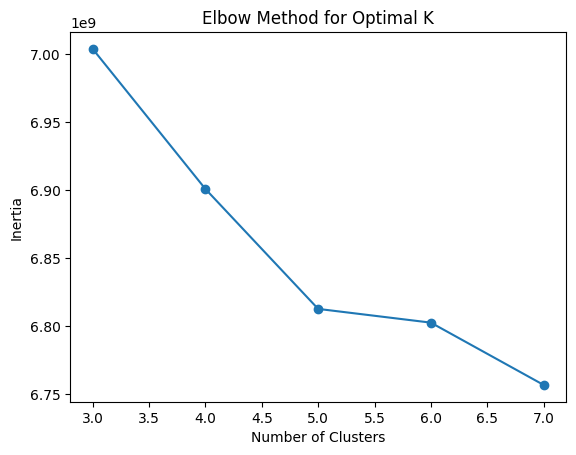

[7003651584.0, 6900794368.0, 6812760576.0, 6802670592.0, 6756940288.0]
Optimal number of clusters: 3
Cluster 2: 2684 images
Cluster 1: 519 images
Cluster 3: 466 images


In [18]:
#without standard scaler
best_n_clusters,distortions = find_Keams_Cluster(features_loaded)
PlotElowCurve(distortions,best_n_clusters)
kmeans_clusters = Get_ClusterItems(features_loaded,best_n_clusters)

In [19]:
# Standardize the features
scaler = StandardScaler()
feature_std = scaler.fit_transform(features_loaded)

For n_clusters=3, the silhouette score is 0.19986456632614136
For n_clusters=4, the silhouette score is 0.031461626291275024
For n_clusters=5, the silhouette score is 0.18301573395729065
For n_clusters=6, the silhouette score is 0.10711392015218735
For n_clusters=7, the silhouette score is 0.07565508037805557
Best number of clusters: 3 with silhouette score: 0.19986456632614136


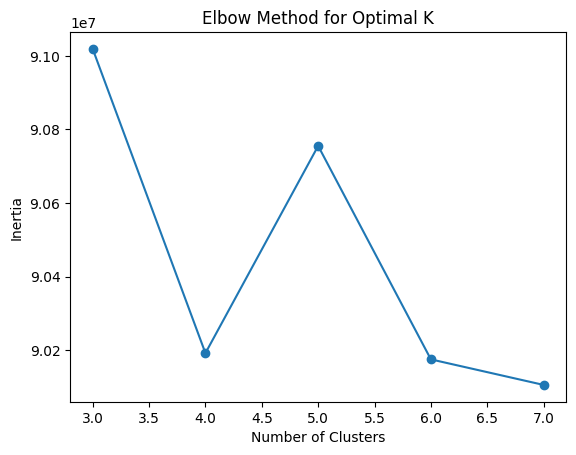

[91019024.0, 90191600.0, 90755232.0, 90174656.0, 90105144.0]
Optimal number of clusters: 3
Cluster 3: 2750 images
Cluster 2: 918 images
Cluster 1: 1 images


In [20]:
#with standard scaler
best_n_clusters,distortions = find_Keams_Cluster(feature_std)
PlotElowCurve(distortions,best_n_clusters)
kmeans_clusters = Get_ClusterItems(feature_std,best_n_clusters)

In [25]:
import matplotlib.pyplot as plt
def PlotPCAVariance(pca_obj):
  # Plot the explained variance
  fig, ax = plt.subplots()
  plt.plot(np.cumsum(pca_obj.explained_variance_ratio_))
  plt.axhline(y=0.95, color='r', linestyle='-')
  plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)
  plt.xlabel('Number of Components')
  plt.ylabel('Cumulative Explained Variance')
  plt.title('Explained Variance vs. Number of Components')
  ax.grid(axis='x')
  plt.show()

In [22]:
pca = PCA()
pca.fit(feature_std)
PlotPCAVariance(pca)

PCA()

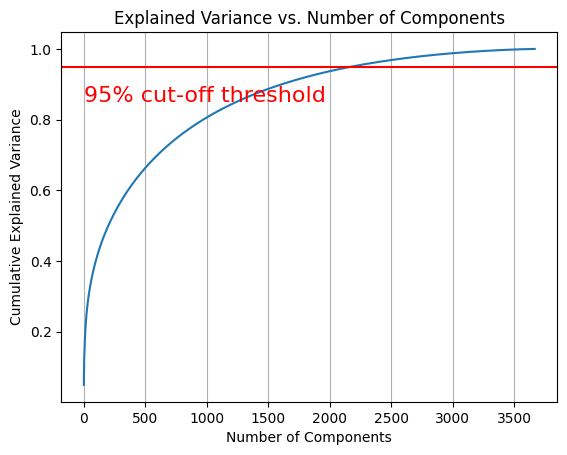

In [26]:
pca_withoutstd = PCA()
pca_withoutstd.fit(features_loaded)
PlotPCAVariance(pca_withoutstd)

In [ ]:
#with standard scaler and PCA
best_n_clusters,distortions = find_Keams_Cluster(feature_std)
PlotElowCurve(distortions,best_n_clusters)
kmeans_clusters = Get_ClusterItems(feature_std,best_n_clusters)

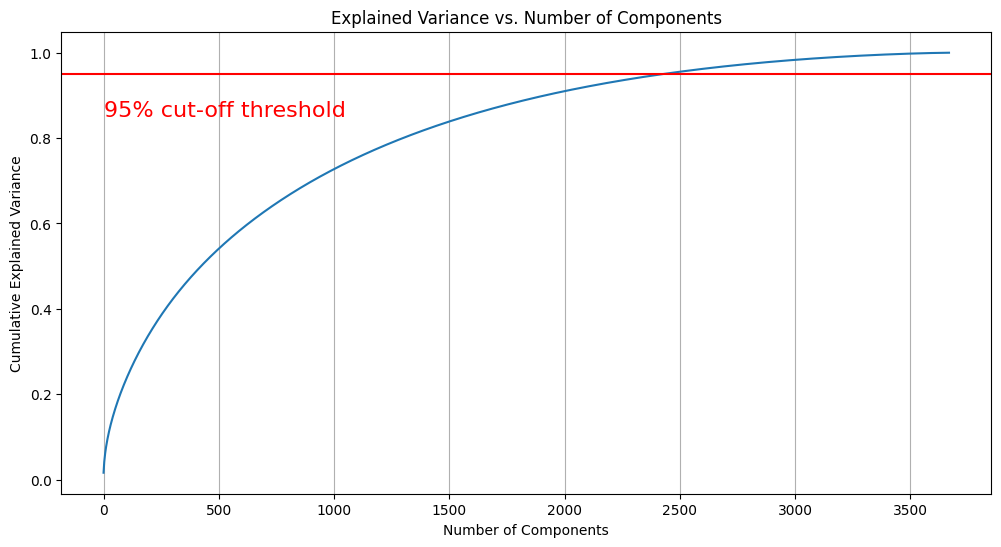

In [91]:
import matplotlib.pyplot as plt
# Plot the explained variance
fig, ax = plt.subplots()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
ax.grid(axis='x')
plt.show()

In [124]:
n_components = 50
pca = PCA(n_components=n_components)
all_features_pca = pca.fit_transform(feature_std)

In [101]:
# Choose a range of cluster numbers to test
cluster_range = range(4, 7)
distortions = []

# Find the optimal number of clusters using Silhouette Score
best_score = -1
best_n_clusters = -1

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(feature_std)
    silhouette_avg = silhouette_score(feature_std, cluster_labels)
    distortions.append(kmeans.inertia_)
    print(f"For n_clusters={n_clusters}, the silhouette score is {silhouette_avg}")

    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters

print(f"Best number of clusters: {best_n_clusters} with silhouette score: {best_score}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=4, the silhouette score is 0.031461626291275024


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=5, the silhouette score is 0.18301573395729065


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=6, the silhouette score is 0.10711392015218735
Best number of clusters: 5 with silhouette score: 0.18301573395729065


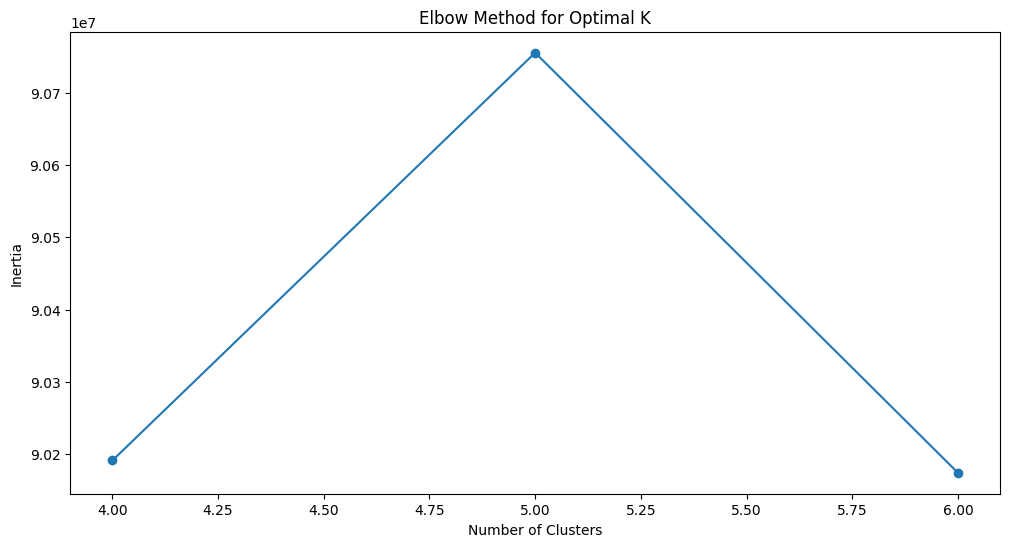

[90191600.0, 90755232.0, 90174656.0]
Optimal number of clusters: 3


In [109]:
# Plot the Elbow curve
# Adjust this visualization based on your specific needs
import matplotlib.pyplot as plt

# Plot the elbow method graph
plt.plot(range(4, 7), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()
print(distortions)
# Choose the optimal number of clusters based on the Elbow curve
optimal_k = distortions.index(min(distortions)) + 1
print(f"Optimal number of clusters: {best_n_clusters}")



In [125]:
# Apply K-means with the optimal number of clusters
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(all_features_pca)

# # Visualize clustered images using the first two principal components
# plt.scatter(feature_std[:, 0], feature_std[:, 1], c=cluster_labels, cmap='viridis')
# plt.title('Image Clustering (CNN Features)')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.show()

# Count the number of images in each cluster
cluster_counts = Counter(kmeans_labels)

# Print the count of images in each cluster
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster + 1}: {count} images")

#Visualize the clustering results or perform further analysis
#(visualization code depends on the dimensionality of your feature vectors)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 5: 1890 images
Cluster 4: 662 images
Cluster 2: 290 images
Cluster 3: 580 images
Cluster 1: 247 images


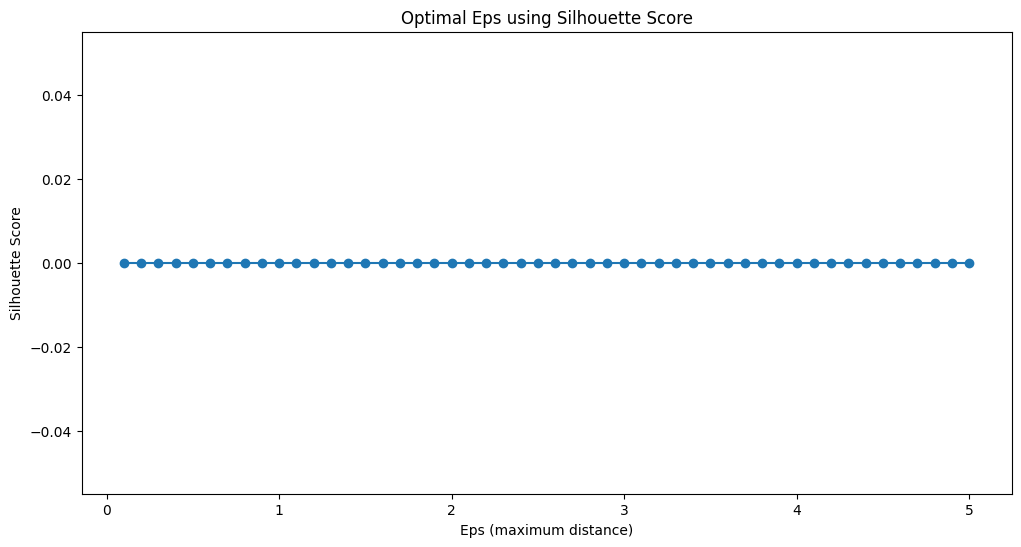

Optimal Eps: 0.1


In [126]:
from sklearn.cluster import DBSCAN
# Perform DBSCAN with different eps values
eps_values = np.linspace(0.1, 5, 50)
min_samples = 5  # You may adjust min_samples based on your data

# Calculate the average silhouette score for each eps value
silhouette_scores = []
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(all_features_pca)

    if len(set(labels)) > 1:  # Silhouette score requires at least 2 clusters
        from sklearn.metrics import silhouette_score
        score = silhouette_score(features, labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(0)

# Plot the results
plt.plot(eps_values, silhouette_scores, marker='o')
plt.xlabel('Eps (maximum distance)')
plt.ylabel('Silhouette Score')
plt.title('Optimal Eps using Silhouette Score')
plt.show()

# Find the index of the maximum silhouette score
optimal_eps_index = np.argmax(silhouette_scores)
optimal_eps = eps_values[optimal_eps_index]
print(f'Optimal Eps: {optimal_eps}')

Counter({0: 2937, -1: 732})
Cluster 0: 2937 points
Noise points: 732


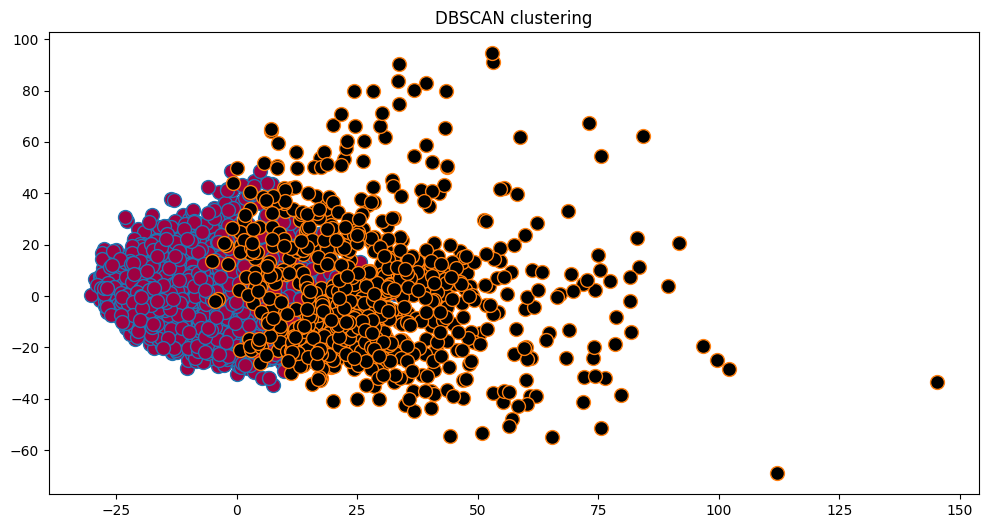

In [141]:
# Apply DBSCAN
eps = 50  # Adjust based on your data
min_samples = 250  # Adjust based on your data
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(all_features_pca)

# Count the points in each cluster
cluster_counts = Counter(labels)
print(cluster_counts)
# Print the counts
for cluster, count in cluster_counts.items():
    if cluster == -1:
        print(f'Noise points: {count}')
    else:
        print(f'Cluster {cluster}: {count} points')

# Visualize the clusters
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = all_features_pca[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markersize=10)

plt.title('DBSCAN clustering')
plt.show()

# ResNet50

In [1]:
import os
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt



In [2]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
# Load the pre-trained ResNet50 model
resnet_model = ResNet50(weights='imagenet', include_top=False)
x = resnet_model.output
x = GlobalAveragePooling2D()(x)
model = Model(inputs=resnet_model.input, outputs=x)

# Define a function for image preprocessing and feature extraction
def extract_resnet50_features(img_path):
    img = image.load_img(img_path, target_size=(100, 100))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array)
    features = model.predict(img_preprocessed)
    features_flattened = features.flatten()
    return features_flattened



94765736/94765736 [==============================] - 1s 0us/step


In [5]:
# Specify the path to the directory containing your images
data_dir = "/content/flowers"

# Get a list of image file names in the directory
image_files = [f for f in os.listdir(data_dir) if f.endswith(('.jpg', '.jpeg'))]




Extracting features:   0%|          | 0/3669 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


Extracting features:   0%|          | 1/3669 [00:01<1:55:28,  1.89s/it]

1/1 [==============================] - 0s 85ms/step


Extracting features:   0%|          | 2/3669 [00:02<53:33,  1.14it/s]  

1/1 [==============================] - 0s 81ms/step


Extracting features:   0%|          | 3/3669 [00:02<32:47,  1.86it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:   0%|          | 4/3669 [00:02<23:02,  2.65it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:   0%|          | 5/3669 [00:02<17:56,  3.40it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:   0%|          | 6/3669 [00:02<14:43,  4.15it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   0%|          | 7/3669 [00:02<12:47,  4.77it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:   0%|          | 8/3669 [00:02<11:27,  5.33it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:   0%|          | 9/3669 [00:03<10:45,  5.67it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:   0%|          | 10/3669 [00:03<09:58,  6.11it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:   0%|          | 11/3669 [00:03<09:21,  6.51it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:   0%|          | 12/3669 [00:03<10:21,  5.88it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:   0%|          | 13/3669 [00:03<11:01,  5.52it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:   0%|          | 14/3669 [00:03<12:46,  4.77it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:   0%|          | 15/3669 [00:04<21:32,  2.83it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:   0%|          | 16/3669 [00:04<19:10,  3.18it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:   0%|          | 17/3669 [00:05<18:19,  3.32it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:   0%|          | 18/3669 [00:05<16:27,  3.70it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:   1%|          | 19/3669 [00:05<15:50,  3.84it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:   1%|          | 20/3669 [00:05<14:49,  4.10it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:   1%|          | 21/3669 [00:06<14:21,  4.23it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:   1%|          | 22/3669 [00:06<14:20,  4.24it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:   1%|          | 23/3669 [00:06<14:05,  4.31it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:   1%|          | 24/3669 [00:06<14:56,  4.07it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:   1%|          | 25/3669 [00:07<14:38,  4.15it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:   1%|          | 26/3669 [00:07<14:14,  4.27it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:   1%|          | 27/3669 [00:07<13:49,  4.39it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:   1%|          | 28/3669 [00:07<13:07,  4.63it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:   1%|          | 29/3669 [00:07<12:38,  4.80it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:   1%|          | 30/3669 [00:08<13:10,  4.60it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:   1%|          | 31/3669 [00:08<13:39,  4.44it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:   1%|          | 32/3669 [00:08<13:25,  4.52it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:   1%|          | 33/3669 [00:08<13:46,  4.40it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:   1%|          | 34/3669 [00:08<14:08,  4.29it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:   1%|          | 35/3669 [00:09<13:29,  4.49it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:   1%|          | 36/3669 [00:09<13:58,  4.33it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:   1%|          | 37/3669 [00:09<13:23,  4.52it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:   1%|          | 38/3669 [00:09<13:49,  4.37it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:   1%|          | 39/3669 [00:10<14:08,  4.28it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:   1%|          | 40/3669 [00:10<14:10,  4.27it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:   1%|          | 41/3669 [00:10<12:42,  4.76it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:   1%|          | 42/3669 [00:10<11:20,  5.33it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:   1%|          | 43/3669 [00:10<10:29,  5.76it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   1%|          | 44/3669 [00:10<09:53,  6.11it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:   1%|          | 45/3669 [00:11<09:22,  6.44it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:   1%|▏         | 46/3669 [00:11<08:57,  6.74it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:   1%|▏         | 47/3669 [00:11<10:09,  5.94it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:   1%|▏         | 48/3669 [00:11<10:31,  5.74it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:   1%|▏         | 49/3669 [00:11<09:44,  6.19it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   1%|▏         | 50/3669 [00:11<09:27,  6.38it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:   1%|▏         | 51/3669 [00:12<09:03,  6.65it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:   1%|▏         | 52/3669 [00:12<09:31,  6.33it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:   1%|▏         | 53/3669 [00:12<09:28,  6.36it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:   1%|▏         | 54/3669 [00:12<09:10,  6.56it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:   1%|▏         | 55/3669 [00:12<08:50,  6.81it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:   2%|▏         | 56/3669 [00:12<08:38,  6.97it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:   2%|▏         | 57/3669 [00:12<08:31,  7.06it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:   2%|▏         | 58/3669 [00:13<08:53,  6.77it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:   2%|▏         | 59/3669 [00:13<09:20,  6.44it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:   2%|▏         | 60/3669 [00:13<10:35,  5.68it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:   2%|▏         | 61/3669 [00:13<10:23,  5.79it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:   2%|▏         | 62/3669 [00:13<11:11,  5.37it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:   2%|▏         | 63/3669 [00:14<10:46,  5.57it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:   2%|▏         | 64/3669 [00:14<11:25,  5.26it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:   2%|▏         | 65/3669 [00:14<11:57,  5.02it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:   2%|▏         | 66/3669 [00:14<12:18,  4.88it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:   2%|▏         | 67/3669 [00:14<11:28,  5.23it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:   2%|▏         | 68/3669 [00:15<12:21,  4.86it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:   2%|▏         | 69/3669 [00:15<12:39,  4.74it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:   2%|▏         | 70/3669 [00:15<12:54,  4.65it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:   2%|▏         | 71/3669 [00:15<12:56,  4.63it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:   2%|▏         | 72/3669 [00:15<13:06,  4.57it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:   2%|▏         | 73/3669 [00:16<13:17,  4.51it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:   2%|▏         | 74/3669 [00:16<13:17,  4.51it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:   2%|▏         | 75/3669 [00:16<13:26,  4.46it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:   2%|▏         | 76/3669 [00:16<13:21,  4.48it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:   2%|▏         | 77/3669 [00:17<13:33,  4.41it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   2%|▏         | 78/3669 [00:17<12:01,  4.98it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:   2%|▏         | 79/3669 [00:17<12:15,  4.88it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:   2%|▏         | 80/3669 [00:17<11:14,  5.32it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   2%|▏         | 81/3669 [00:17<10:21,  5.77it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   2%|▏         | 82/3669 [00:17<09:41,  6.17it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:   2%|▏         | 83/3669 [00:18<09:10,  6.51it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:   2%|▏         | 84/3669 [00:18<10:37,  5.62it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:   2%|▏         | 85/3669 [00:18<11:22,  5.25it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:   2%|▏         | 86/3669 [00:18<12:12,  4.89it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:   2%|▏         | 87/3669 [00:18<12:34,  4.75it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:   2%|▏         | 88/3669 [00:19<12:57,  4.61it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:   2%|▏         | 89/3669 [00:19<13:08,  4.54it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:   2%|▏         | 90/3669 [00:19<11:56,  4.99it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:   2%|▏         | 91/3669 [00:19<12:26,  4.79it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:   3%|▎         | 92/3669 [00:19<11:31,  5.17it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:   3%|▎         | 93/3669 [00:20<12:01,  4.96it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:   3%|▎         | 94/3669 [00:20<11:03,  5.39it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:   3%|▎         | 95/3669 [00:20<11:15,  5.29it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:   3%|▎         | 96/3669 [00:20<12:22,  4.81it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:   3%|▎         | 97/3669 [00:20<13:05,  4.55it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:   3%|▎         | 98/3669 [00:21<13:36,  4.37it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:   3%|▎         | 99/3669 [00:21<13:32,  4.39it/s]

1/1 [==============================] - 0s 160ms/step


Extracting features:   3%|▎         | 100/3669 [00:21<14:07,  4.21it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:   3%|▎         | 101/3669 [00:21<14:02,  4.24it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:   3%|▎         | 102/3669 [00:22<13:58,  4.25it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:   3%|▎         | 103/3669 [00:22<14:18,  4.16it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:   3%|▎         | 104/3669 [00:22<14:33,  4.08it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:   3%|▎         | 105/3669 [00:22<13:47,  4.31it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:   3%|▎         | 106/3669 [00:23<14:09,  4.19it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:   3%|▎         | 107/3669 [00:23<14:09,  4.19it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:   3%|▎         | 108/3669 [00:23<13:18,  4.46it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:   3%|▎         | 109/3669 [00:23<12:53,  4.60it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:   3%|▎         | 110/3669 [00:23<12:46,  4.64it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:   3%|▎         | 111/3669 [00:24<12:51,  4.61it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:   3%|▎         | 112/3669 [00:24<13:44,  4.31it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:   3%|▎         | 113/3669 [00:24<13:59,  4.24it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:   3%|▎         | 114/3669 [00:24<14:02,  4.22it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:   3%|▎         | 115/3669 [00:25<14:26,  4.10it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:   3%|▎         | 116/3669 [00:25<14:27,  4.09it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:   3%|▎         | 117/3669 [00:25<14:30,  4.08it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:   3%|▎         | 118/3669 [00:25<14:00,  4.23it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:   3%|▎         | 119/3669 [00:26<14:10,  4.18it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:   3%|▎         | 120/3669 [00:26<14:17,  4.14it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:   3%|▎         | 121/3669 [00:26<14:26,  4.10it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:   3%|▎         | 122/3669 [00:26<14:25,  4.10it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:   3%|▎         | 123/3669 [00:27<14:55,  3.96it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:   3%|▎         | 124/3669 [00:27<13:35,  4.35it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:   3%|▎         | 125/3669 [00:27<12:27,  4.74it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:   3%|▎         | 126/3669 [00:27<11:24,  5.18it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:   3%|▎         | 127/3669 [00:27<10:46,  5.48it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:   3%|▎         | 128/3669 [00:28<11:26,  5.16it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:   4%|▎         | 129/3669 [00:28<11:52,  4.97it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:   4%|▎         | 130/3669 [00:28<10:59,  5.37it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   4%|▎         | 131/3669 [00:28<10:09,  5.81it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:   4%|▎         | 132/3669 [00:28<11:03,  5.33it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:   4%|▎         | 133/3669 [00:28<10:09,  5.80it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:   4%|▎         | 134/3669 [00:29<09:37,  6.12it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:   4%|▎         | 135/3669 [00:29<09:10,  6.42it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:   4%|▎         | 136/3669 [00:29<10:10,  5.79it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:   4%|▎         | 137/3669 [00:29<10:57,  5.37it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:   4%|▍         | 138/3669 [00:29<10:24,  5.65it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:   4%|▍         | 139/3669 [00:29<10:12,  5.77it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:   4%|▍         | 140/3669 [00:30<11:17,  5.21it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:   4%|▍         | 141/3669 [00:30<10:58,  5.36it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:   4%|▍         | 142/3669 [00:30<11:42,  5.02it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:   4%|▍         | 143/3669 [00:30<12:14,  4.80it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:   4%|▍         | 144/3669 [00:31<12:33,  4.68it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:   4%|▍         | 145/3669 [00:31<11:45,  4.99it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:   4%|▍         | 146/3669 [00:31<11:03,  5.31it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:   4%|▍         | 147/3669 [00:31<10:11,  5.76it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:   4%|▍         | 148/3669 [00:31<09:34,  6.13it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:   4%|▍         | 149/3669 [00:31<09:10,  6.39it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:   4%|▍         | 150/3669 [00:32<10:15,  5.71it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:   4%|▍         | 151/3669 [00:32<09:42,  6.04it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:   4%|▍         | 152/3669 [00:32<09:15,  6.34it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:   4%|▍         | 153/3669 [00:32<10:23,  5.64it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:   4%|▍         | 154/3669 [00:32<10:01,  5.84it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:   4%|▍         | 155/3669 [00:32<10:57,  5.35it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:   4%|▍         | 156/3669 [00:33<11:30,  5.09it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:   4%|▍         | 157/3669 [00:33<11:54,  4.92it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:   4%|▍         | 158/3669 [00:33<10:53,  5.37it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:   4%|▍         | 159/3669 [00:33<10:09,  5.76it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:   4%|▍         | 160/3669 [00:33<09:34,  6.11it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:   4%|▍         | 161/3669 [00:33<09:11,  6.36it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:   4%|▍         | 162/3669 [00:34<08:49,  6.62it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:   4%|▍         | 163/3669 [00:34<09:55,  5.89it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:   4%|▍         | 164/3669 [00:34<09:22,  6.23it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:   4%|▍         | 165/3669 [00:34<10:25,  5.61it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:   5%|▍         | 166/3669 [00:34<11:08,  5.24it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:   5%|▍         | 167/3669 [00:35<10:41,  5.46it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:   5%|▍         | 168/3669 [00:35<10:41,  5.46it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:   5%|▍         | 169/3669 [00:35<11:24,  5.11it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:   5%|▍         | 170/3669 [00:35<10:35,  5.51it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:   5%|▍         | 171/3669 [00:35<11:05,  5.26it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:   5%|▍         | 172/3669 [00:35<10:05,  5.78it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:   5%|▍         | 173/3669 [00:36<09:30,  6.12it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:   5%|▍         | 174/3669 [00:36<09:08,  6.37it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:   5%|▍         | 175/3669 [00:36<08:58,  6.49it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:   5%|▍         | 176/3669 [00:36<10:04,  5.78it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:   5%|▍         | 177/3669 [00:36<10:00,  5.82it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:   5%|▍         | 178/3669 [00:36<09:56,  5.85it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:   5%|▍         | 179/3669 [00:37<10:47,  5.39it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:   5%|▍         | 180/3669 [00:37<11:22,  5.11it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:   5%|▍         | 181/3669 [00:37<12:30,  4.65it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:   5%|▍         | 182/3669 [00:37<12:19,  4.71it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:   5%|▍         | 183/3669 [00:38<12:18,  4.72it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:   5%|▌         | 184/3669 [00:38<12:20,  4.71it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:   5%|▌         | 185/3669 [00:38<12:12,  4.76it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:   5%|▌         | 186/3669 [00:38<12:47,  4.54it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:   5%|▌         | 187/3669 [00:38<13:52,  4.18it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:   5%|▌         | 188/3669 [00:39<14:16,  4.06it/s]

1/1 [==============================] - 0s 156ms/step


Extracting features:   5%|▌         | 189/3669 [00:39<14:23,  4.03it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:   5%|▌         | 190/3669 [00:39<14:36,  3.97it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:   5%|▌         | 191/3669 [00:39<13:37,  4.26it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:   5%|▌         | 192/3669 [00:40<13:49,  4.19it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:   5%|▌         | 193/3669 [00:40<13:04,  4.43it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:   5%|▌         | 194/3669 [00:40<13:38,  4.24it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:   5%|▌         | 195/3669 [00:40<13:50,  4.18it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:   5%|▌         | 196/3669 [00:41<13:20,  4.34it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:   5%|▌         | 197/3669 [00:41<13:36,  4.25it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:   5%|▌         | 198/3669 [00:41<12:55,  4.47it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:   5%|▌         | 199/3669 [00:41<13:20,  4.33it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:   5%|▌         | 200/3669 [00:42<13:30,  4.28it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:   5%|▌         | 201/3669 [00:42<12:57,  4.46it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:   6%|▌         | 202/3669 [00:42<12:57,  4.46it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:   6%|▌         | 203/3669 [00:42<12:32,  4.61it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:   6%|▌         | 204/3669 [00:42<12:19,  4.69it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:   6%|▌         | 205/3669 [00:43<12:48,  4.51it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:   6%|▌         | 206/3669 [00:43<13:13,  4.37it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:   6%|▌         | 207/3669 [00:43<12:43,  4.53it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:   6%|▌         | 208/3669 [00:43<13:10,  4.38it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:   6%|▌         | 209/3669 [00:43<12:35,  4.58it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:   6%|▌         | 210/3669 [00:44<12:11,  4.73it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:   6%|▌         | 211/3669 [00:44<11:07,  5.18it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:   6%|▌         | 212/3669 [00:44<10:15,  5.62it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:   6%|▌         | 213/3669 [00:44<09:46,  5.90it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:   6%|▌         | 214/3669 [00:44<10:53,  5.29it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:   6%|▌         | 215/3669 [00:45<11:32,  4.99it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:   6%|▌         | 216/3669 [00:45<10:56,  5.26it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:   6%|▌         | 217/3669 [00:45<10:39,  5.39it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:   6%|▌         | 218/3669 [00:45<10:22,  5.54it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:   6%|▌         | 219/3669 [00:45<10:17,  5.59it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:   6%|▌         | 220/3669 [00:45<09:34,  6.00it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:   6%|▌         | 221/3669 [00:46<09:05,  6.32it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:   6%|▌         | 222/3669 [00:46<08:54,  6.45it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:   6%|▌         | 223/3669 [00:46<09:56,  5.77it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:   6%|▌         | 224/3669 [00:46<09:19,  6.15it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:   6%|▌         | 225/3669 [00:46<09:00,  6.37it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:   6%|▌         | 226/3669 [00:46<10:32,  5.45it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:   6%|▌         | 227/3669 [00:47<10:18,  5.57it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:   6%|▌         | 228/3669 [00:47<11:16,  5.09it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:   6%|▌         | 229/3669 [00:47<10:44,  5.34it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:   6%|▋         | 230/3669 [00:47<11:29,  4.98it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:   6%|▋         | 231/3669 [00:47<11:16,  5.08it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:   6%|▋         | 232/3669 [00:48<11:59,  4.78it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:   6%|▋         | 233/3669 [00:48<11:11,  5.12it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:   6%|▋         | 234/3669 [00:48<10:30,  5.45it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:   6%|▋         | 235/3669 [00:48<11:06,  5.15it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:   6%|▋         | 236/3669 [00:48<11:45,  4.86it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:   6%|▋         | 237/3669 [00:49<11:03,  5.17it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:   6%|▋         | 238/3669 [00:49<10:33,  5.42it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:   7%|▋         | 239/3669 [00:49<10:15,  5.57it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:   7%|▋         | 240/3669 [00:49<10:10,  5.61it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:   7%|▋         | 241/3669 [00:49<10:58,  5.21it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:   7%|▋         | 242/3669 [00:49<10:08,  5.64it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:   7%|▋         | 243/3669 [00:50<10:45,  5.30it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   7%|▋         | 244/3669 [00:50<11:06,  5.14it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:   7%|▋         | 245/3669 [00:50<11:19,  5.04it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:   7%|▋         | 246/3669 [00:50<10:17,  5.54it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:   7%|▋         | 247/3669 [00:50<10:02,  5.68it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:   7%|▋         | 248/3669 [00:51<10:00,  5.70it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:   7%|▋         | 249/3669 [00:51<11:05,  5.14it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:   7%|▋         | 250/3669 [00:51<10:34,  5.39it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:   7%|▋         | 251/3669 [00:51<10:06,  5.63it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:   7%|▋         | 252/3669 [00:51<10:56,  5.20it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:   7%|▋         | 253/3669 [00:52<10:30,  5.42it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:   7%|▋         | 254/3669 [00:52<11:08,  5.11it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:   7%|▋         | 255/3669 [00:52<10:25,  5.46it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:   7%|▋         | 256/3669 [00:52<09:59,  5.70it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:   7%|▋         | 257/3669 [00:52<09:42,  5.86it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:   7%|▋         | 258/3669 [00:52<10:31,  5.40it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:   7%|▋         | 259/3669 [00:53<11:40,  4.87it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:   7%|▋         | 260/3669 [00:53<10:58,  5.18it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:   7%|▋         | 261/3669 [00:53<11:30,  4.93it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:   7%|▋         | 262/3669 [00:53<10:42,  5.30it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:   7%|▋         | 263/3669 [00:53<11:20,  5.00it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:   7%|▋         | 264/3669 [00:54<10:38,  5.33it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:   7%|▋         | 265/3669 [00:54<10:52,  5.21it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:   7%|▋         | 266/3669 [00:54<11:47,  4.81it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:   7%|▋         | 267/3669 [00:54<11:49,  4.79it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:   7%|▋         | 268/3669 [00:55<12:16,  4.62it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:   7%|▋         | 269/3669 [00:55<11:54,  4.76it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:   7%|▋         | 270/3669 [00:55<11:53,  4.77it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:   7%|▋         | 271/3669 [00:55<12:46,  4.44it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:   7%|▋         | 272/3669 [00:55<12:19,  4.60it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:   7%|▋         | 273/3669 [00:56<13:39,  4.14it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:   7%|▋         | 274/3669 [00:56<13:18,  4.25it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:   7%|▋         | 275/3669 [00:56<13:51,  4.08it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:   8%|▊         | 276/3669 [00:56<13:31,  4.18it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:   8%|▊         | 277/3669 [00:57<13:30,  4.19it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:   8%|▊         | 278/3669 [00:57<13:21,  4.23it/s]

1/1 [==============================] - 0s 146ms/step


Extracting features:   8%|▊         | 279/3669 [00:57<13:16,  4.26it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:   8%|▊         | 280/3669 [00:57<12:57,  4.36it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:   8%|▊         | 281/3669 [00:58<12:59,  4.35it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:   8%|▊         | 282/3669 [00:58<12:38,  4.47it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:   8%|▊         | 283/3669 [00:58<12:28,  4.52it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:   8%|▊         | 284/3669 [00:58<12:19,  4.58it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:   8%|▊         | 285/3669 [00:58<12:41,  4.44it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:   8%|▊         | 286/3669 [00:59<13:11,  4.27it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:   8%|▊         | 287/3669 [00:59<12:53,  4.37it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:   8%|▊         | 288/3669 [00:59<12:25,  4.53it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:   8%|▊         | 289/3669 [00:59<11:57,  4.71it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:   8%|▊         | 290/3669 [00:59<11:29,  4.90it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:   8%|▊         | 291/3669 [01:00<12:14,  4.60it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:   8%|▊         | 292/3669 [01:00<12:57,  4.35it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:   8%|▊         | 293/3669 [01:00<12:56,  4.35it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:   8%|▊         | 294/3669 [01:00<13:18,  4.23it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:   8%|▊         | 295/3669 [01:01<13:13,  4.25it/s]

1/1 [==============================] - 0s 155ms/step


Extracting features:   8%|▊         | 296/3669 [01:01<14:21,  3.91it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:   8%|▊         | 297/3669 [01:01<12:47,  4.39it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:   8%|▊         | 298/3669 [01:01<12:56,  4.34it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:   8%|▊         | 299/3669 [01:02<11:51,  4.73it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:   8%|▊         | 300/3669 [01:02<10:52,  5.16it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:   8%|▊         | 301/3669 [01:02<10:27,  5.37it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   8%|▊         | 302/3669 [01:02<09:41,  5.79it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:   8%|▊         | 303/3669 [01:02<09:09,  6.13it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:   8%|▊         | 304/3669 [01:02<08:57,  6.27it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:   8%|▊         | 305/3669 [01:02<08:37,  6.50it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:   8%|▊         | 306/3669 [01:03<08:24,  6.67it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:   8%|▊         | 307/3669 [01:03<08:20,  6.72it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:   8%|▊         | 308/3669 [01:03<08:28,  6.62it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:   8%|▊         | 309/3669 [01:03<08:14,  6.80it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:   8%|▊         | 310/3669 [01:03<08:04,  6.93it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:   8%|▊         | 311/3669 [01:03<07:58,  7.01it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   9%|▊         | 312/3669 [01:03<07:47,  7.18it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   9%|▊         | 313/3669 [01:04<08:06,  6.89it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:   9%|▊         | 314/3669 [01:04<07:54,  7.07it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:   9%|▊         | 315/3669 [01:04<09:16,  6.02it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:   9%|▊         | 316/3669 [01:04<08:48,  6.34it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:   9%|▊         | 317/3669 [01:04<08:26,  6.61it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:   9%|▊         | 318/3669 [01:04<08:22,  6.67it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:   9%|▊         | 319/3669 [01:05<08:13,  6.79it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   9%|▊         | 320/3669 [01:05<08:09,  6.84it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:   9%|▊         | 321/3669 [01:05<08:28,  6.58it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:   9%|▉         | 322/3669 [01:05<09:00,  6.19it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:   9%|▉         | 323/3669 [01:05<10:08,  5.50it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:   9%|▉         | 324/3669 [01:05<10:54,  5.11it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:   9%|▉         | 325/3669 [01:06<11:21,  4.91it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:   9%|▉         | 326/3669 [01:06<11:31,  4.84it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:   9%|▉         | 327/3669 [01:06<10:32,  5.28it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:   9%|▉         | 328/3669 [01:06<09:45,  5.71it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:   9%|▉         | 329/3669 [01:06<09:07,  6.10it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:   9%|▉         | 330/3669 [01:06<08:33,  6.50it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:   9%|▉         | 331/3669 [01:07<08:31,  6.52it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:   9%|▉         | 332/3669 [01:07<09:34,  5.81it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:   9%|▉         | 333/3669 [01:07<09:28,  5.87it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:   9%|▉         | 334/3669 [01:07<10:16,  5.41it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:   9%|▉         | 335/3669 [01:07<10:51,  5.12it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:   9%|▉         | 336/3669 [01:08<11:14,  4.94it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:   9%|▉         | 337/3669 [01:08<10:29,  5.29it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:   9%|▉         | 338/3669 [01:08<09:45,  5.69it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:   9%|▉         | 339/3669 [01:08<09:16,  5.98it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:   9%|▉         | 340/3669 [01:08<09:04,  6.12it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:   9%|▉         | 341/3669 [01:08<08:43,  6.36it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:   9%|▉         | 342/3669 [01:09<08:27,  6.55it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:   9%|▉         | 343/3669 [01:09<08:13,  6.74it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   9%|▉         | 344/3669 [01:09<09:17,  5.96it/s]

1/1 [==============================] - 0s 252ms/step


Extracting features:   9%|▉         | 345/3669 [01:09<12:21,  4.48it/s]

1/1 [==============================] - 0s 197ms/step


Extracting features:   9%|▉         | 346/3669 [01:10<15:45,  3.52it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:   9%|▉         | 347/3669 [01:10<15:57,  3.47it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:   9%|▉         | 348/3669 [01:10<13:32,  4.09it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  10%|▉         | 349/3669 [01:10<11:50,  4.67it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  10%|▉         | 350/3669 [01:10<10:42,  5.16it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  10%|▉         | 351/3669 [01:11<09:51,  5.61it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  10%|▉         | 352/3669 [01:11<09:11,  6.01it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  10%|▉         | 353/3669 [01:11<08:48,  6.27it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  10%|▉         | 354/3669 [01:11<08:31,  6.48it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  10%|▉         | 355/3669 [01:11<09:29,  5.82it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  10%|▉         | 356/3669 [01:11<10:48,  5.10it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  10%|▉         | 357/3669 [01:12<10:55,  5.05it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:  10%|▉         | 358/3669 [01:12<11:21,  4.86it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  10%|▉         | 359/3669 [01:12<12:15,  4.50it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  10%|▉         | 360/3669 [01:12<13:02,  4.23it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  10%|▉         | 361/3669 [01:13<12:48,  4.30it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  10%|▉         | 362/3669 [01:13<13:16,  4.15it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  10%|▉         | 363/3669 [01:13<12:37,  4.36it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  10%|▉         | 364/3669 [01:13<12:49,  4.30it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  10%|▉         | 365/3669 [01:14<12:25,  4.43it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  10%|▉         | 366/3669 [01:14<12:05,  4.56it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  10%|█         | 367/3669 [01:14<12:00,  4.58it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  10%|█         | 368/3669 [01:14<11:35,  4.74it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  10%|█         | 369/3669 [01:14<11:29,  4.79it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  10%|█         | 370/3669 [01:15<12:10,  4.52it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  10%|█         | 371/3669 [01:15<11:54,  4.62it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  10%|█         | 372/3669 [01:15<12:34,  4.37it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  10%|█         | 373/3669 [01:15<11:53,  4.62it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  10%|█         | 374/3669 [01:15<12:03,  4.56it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  10%|█         | 375/3669 [01:16<11:55,  4.61it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  10%|█         | 376/3669 [01:16<11:41,  4.69it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  10%|█         | 377/3669 [01:16<12:15,  4.47it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  10%|█         | 378/3669 [01:16<11:51,  4.63it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  10%|█         | 379/3669 [01:17<12:27,  4.40it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  10%|█         | 380/3669 [01:17<12:40,  4.33it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  10%|█         | 381/3669 [01:17<12:25,  4.41it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  10%|█         | 382/3669 [01:17<12:51,  4.26it/s]

1/1 [==============================] - 0s 156ms/step


Extracting features:  10%|█         | 383/3669 [01:18<13:07,  4.17it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  10%|█         | 384/3669 [01:18<13:23,  4.09it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  10%|█         | 385/3669 [01:18<13:44,  3.98it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  11%|█         | 386/3669 [01:18<13:33,  4.04it/s]

1/1 [==============================] - 0s 301ms/step


Extracting features:  11%|█         | 387/3669 [01:19<17:59,  3.04it/s]

1/1 [==============================] - 0s 186ms/step


Extracting features:  11%|█         | 388/3669 [01:19<18:27,  2.96it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  11%|█         | 389/3669 [01:19<15:07,  3.61it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  11%|█         | 390/3669 [01:19<12:55,  4.23it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  11%|█         | 391/3669 [01:20<11:39,  4.69it/s]

1/1 [==============================] - 0s 192ms/step


Extracting features:  11%|█         | 392/3669 [01:20<15:19,  3.56it/s]

1/1 [==============================] - 0s 149ms/step


Extracting features:  11%|█         | 393/3669 [01:20<16:55,  3.23it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  11%|█         | 394/3669 [01:21<14:36,  3.74it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  11%|█         | 395/3669 [01:21<12:29,  4.37it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  11%|█         | 396/3669 [01:21<11:06,  4.91it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  11%|█         | 397/3669 [01:21<10:25,  5.23it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  11%|█         | 398/3669 [01:21<11:03,  4.93it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  11%|█         | 399/3669 [01:22<11:26,  4.76it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  11%|█         | 400/3669 [01:22<11:35,  4.70it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  11%|█         | 401/3669 [01:22<10:56,  4.98it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  11%|█         | 402/3669 [01:22<11:25,  4.77it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  11%|█         | 403/3669 [01:22<10:52,  5.01it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  11%|█         | 404/3669 [01:23<10:26,  5.22it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  11%|█         | 405/3669 [01:23<10:02,  5.42it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  11%|█         | 406/3669 [01:23<09:56,  5.47it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  11%|█         | 407/3669 [01:23<09:45,  5.58it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  11%|█         | 408/3669 [01:23<09:27,  5.75it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  11%|█         | 409/3669 [01:23<08:54,  6.10it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  11%|█         | 410/3669 [01:23<08:35,  6.32it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  11%|█         | 411/3669 [01:24<08:11,  6.62it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  11%|█         | 412/3669 [01:24<08:18,  6.53it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  11%|█▏        | 413/3669 [01:24<08:16,  6.56it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  11%|█▏        | 414/3669 [01:24<08:06,  6.69it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  11%|█▏        | 415/3669 [01:24<08:01,  6.75it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  11%|█▏        | 416/3669 [01:24<07:57,  6.82it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  11%|█▏        | 417/3669 [01:24<07:49,  6.93it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  11%|█▏        | 418/3669 [01:25<07:45,  6.99it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  11%|█▏        | 419/3669 [01:25<08:50,  6.13it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  11%|█▏        | 420/3669 [01:25<08:22,  6.46it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  11%|█▏        | 421/3669 [01:25<09:29,  5.70it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  12%|█▏        | 422/3669 [01:25<09:17,  5.83it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  12%|█▏        | 423/3669 [01:26<09:08,  5.91it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  12%|█▏        | 424/3669 [01:26<09:12,  5.88it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  12%|█▏        | 425/3669 [01:26<10:06,  5.35it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  12%|█▏        | 426/3669 [01:26<09:33,  5.66it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  12%|█▏        | 427/3669 [01:26<09:26,  5.73it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  12%|█▏        | 428/3669 [01:26<10:12,  5.29it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  12%|█▏        | 429/3669 [01:27<10:48,  5.00it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  12%|█▏        | 430/3669 [01:27<11:19,  4.77it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  12%|█▏        | 431/3669 [01:27<11:37,  4.65it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  12%|█▏        | 432/3669 [01:27<10:41,  5.05it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  12%|█▏        | 433/3669 [01:27<09:51,  5.47it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  12%|█▏        | 434/3669 [01:28<09:07,  5.91it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  12%|█▏        | 435/3669 [01:28<08:33,  6.30it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  12%|█▏        | 436/3669 [01:28<08:14,  6.54it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  12%|█▏        | 437/3669 [01:28<08:27,  6.37it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  12%|█▏        | 438/3669 [01:28<08:05,  6.65it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  12%|█▏        | 439/3669 [01:28<09:20,  5.76it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  12%|█▏        | 440/3669 [01:29<10:27,  5.15it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  12%|█▏        | 441/3669 [01:29<11:14,  4.78it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  12%|█▏        | 442/3669 [01:29<11:58,  4.49it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  12%|█▏        | 443/3669 [01:29<12:17,  4.37it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  12%|█▏        | 444/3669 [01:30<12:05,  4.45it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  12%|█▏        | 445/3669 [01:30<11:33,  4.65it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  12%|█▏        | 446/3669 [01:30<11:04,  4.85it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  12%|█▏        | 447/3669 [01:30<10:56,  4.91it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  12%|█▏        | 448/3669 [01:30<10:45,  4.99it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  12%|█▏        | 449/3669 [01:31<11:29,  4.67it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  12%|█▏        | 450/3669 [01:31<11:20,  4.73it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  12%|█▏        | 451/3669 [01:31<11:41,  4.59it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  12%|█▏        | 452/3669 [01:31<11:22,  4.72it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  12%|█▏        | 453/3669 [01:32<12:11,  4.40it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  12%|█▏        | 454/3669 [01:32<12:35,  4.26it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  12%|█▏        | 455/3669 [01:32<13:05,  4.09it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  12%|█▏        | 456/3669 [01:32<13:26,  3.99it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  12%|█▏        | 457/3669 [01:33<13:02,  4.10it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  12%|█▏        | 458/3669 [01:33<13:24,  3.99it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  13%|█▎        | 459/3669 [01:33<12:31,  4.27it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  13%|█▎        | 460/3669 [01:33<12:43,  4.20it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  13%|█▎        | 461/3669 [01:33<12:16,  4.35it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  13%|█▎        | 462/3669 [01:34<12:32,  4.26it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  13%|█▎        | 463/3669 [01:34<13:09,  4.06it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  13%|█▎        | 464/3669 [01:34<13:22,  3.99it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  13%|█▎        | 465/3669 [01:34<12:56,  4.13it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  13%|█▎        | 466/3669 [01:35<12:50,  4.16it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  13%|█▎        | 467/3669 [01:35<13:32,  3.94it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  13%|█▎        | 468/3669 [01:35<13:40,  3.90it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  13%|█▎        | 469/3669 [01:35<13:36,  3.92it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  13%|█▎        | 470/3669 [01:36<12:58,  4.11it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  13%|█▎        | 471/3669 [01:36<11:44,  4.54it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  13%|█▎        | 472/3669 [01:36<10:20,  5.15it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  13%|█▎        | 473/3669 [01:36<09:43,  5.48it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  13%|█▎        | 474/3669 [01:36<09:11,  5.79it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  13%|█▎        | 475/3669 [01:37<10:05,  5.28it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  13%|█▎        | 476/3669 [01:37<10:33,  5.04it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  13%|█▎        | 477/3669 [01:37<11:00,  4.84it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  13%|█▎        | 478/3669 [01:37<11:15,  4.72it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  13%|█▎        | 479/3669 [01:37<11:23,  4.67it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  13%|█▎        | 480/3669 [01:38<10:24,  5.11it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  13%|█▎        | 481/3669 [01:38<09:50,  5.40it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  13%|█▎        | 482/3669 [01:38<10:35,  5.01it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  13%|█▎        | 483/3669 [01:38<09:58,  5.32it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  13%|█▎        | 484/3669 [01:38<09:52,  5.38it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  13%|█▎        | 485/3669 [01:39<10:45,  4.93it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  13%|█▎        | 486/3669 [01:39<09:44,  5.45it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  13%|█▎        | 487/3669 [01:39<09:07,  5.82it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  13%|█▎        | 488/3669 [01:39<09:46,  5.43it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  13%|█▎        | 489/3669 [01:39<09:19,  5.68it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  13%|█▎        | 490/3669 [01:39<08:45,  6.04it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  13%|█▎        | 491/3669 [01:40<09:50,  5.39it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  13%|█▎        | 492/3669 [01:40<10:23,  5.10it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  13%|█▎        | 493/3669 [01:40<11:06,  4.76it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  13%|█▎        | 494/3669 [01:40<10:19,  5.13it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  13%|█▎        | 495/3669 [01:40<10:58,  4.82it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  14%|█▎        | 496/3669 [01:41<10:02,  5.27it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  14%|█▎        | 497/3669 [01:41<09:21,  5.65it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  14%|█▎        | 498/3669 [01:41<08:47,  6.01it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  14%|█▎        | 499/3669 [01:41<08:31,  6.19it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  14%|█▎        | 500/3669 [01:41<08:20,  6.34it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  14%|█▎        | 501/3669 [01:41<08:04,  6.54it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  14%|█▎        | 502/3669 [01:41<08:11,  6.44it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  14%|█▎        | 503/3669 [01:42<08:01,  6.58it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  14%|█▎        | 504/3669 [01:42<07:52,  6.69it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  14%|█▍        | 505/3669 [01:42<07:47,  6.77it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  14%|█▍        | 506/3669 [01:42<07:44,  6.81it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  14%|█▍        | 507/3669 [01:42<07:46,  6.77it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  14%|█▍        | 508/3669 [01:42<07:48,  6.74it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  14%|█▍        | 509/3669 [01:43<07:51,  6.70it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  14%|█▍        | 510/3669 [01:43<09:07,  5.77it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  14%|█▍        | 511/3669 [01:43<10:09,  5.18it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  14%|█▍        | 512/3669 [01:43<10:37,  4.95it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  14%|█▍        | 513/3669 [01:43<10:08,  5.18it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  14%|█▍        | 514/3669 [01:44<10:06,  5.20it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  14%|█▍        | 515/3669 [01:44<10:46,  4.88it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  14%|█▍        | 516/3669 [01:44<11:00,  4.77it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  14%|█▍        | 517/3669 [01:44<10:18,  5.10it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  14%|█▍        | 518/3669 [01:44<09:52,  5.31it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  14%|█▍        | 519/3669 [01:45<09:32,  5.50it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  14%|█▍        | 520/3669 [01:45<10:39,  4.92it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  14%|█▍        | 521/3669 [01:45<10:59,  4.77it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  14%|█▍        | 522/3669 [01:45<10:28,  5.01it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  14%|█▍        | 523/3669 [01:45<10:56,  4.79it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  14%|█▍        | 524/3669 [01:46<10:21,  5.06it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  14%|█▍        | 525/3669 [01:46<10:15,  5.11it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  14%|█▍        | 526/3669 [01:46<10:55,  4.80it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  14%|█▍        | 527/3669 [01:46<11:59,  4.37it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  14%|█▍        | 528/3669 [01:47<11:59,  4.36it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  14%|█▍        | 529/3669 [01:47<12:20,  4.24it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  14%|█▍        | 530/3669 [01:47<12:41,  4.12it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  14%|█▍        | 531/3669 [01:47<12:00,  4.35it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  14%|█▍        | 532/3669 [01:47<12:06,  4.32it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  15%|█▍        | 533/3669 [01:48<12:26,  4.20it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  15%|█▍        | 534/3669 [01:48<12:23,  4.22it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  15%|█▍        | 535/3669 [01:48<11:49,  4.42it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  15%|█▍        | 536/3669 [01:48<11:38,  4.49it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  15%|█▍        | 537/3669 [01:49<11:19,  4.61it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  15%|█▍        | 538/3669 [01:49<11:26,  4.56it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  15%|█▍        | 539/3669 [01:49<11:24,  4.57it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  15%|█▍        | 540/3669 [01:49<11:22,  4.59it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  15%|█▍        | 541/3669 [01:49<11:12,  4.65it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  15%|█▍        | 542/3669 [01:50<11:51,  4.40it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  15%|█▍        | 543/3669 [01:50<11:50,  4.40it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  15%|█▍        | 544/3669 [01:50<11:30,  4.52it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  15%|█▍        | 545/3669 [01:50<11:31,  4.52it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  15%|█▍        | 546/3669 [01:51<11:17,  4.61it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  15%|█▍        | 547/3669 [01:51<11:35,  4.49it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  15%|█▍        | 548/3669 [01:51<11:16,  4.61it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  15%|█▍        | 549/3669 [01:51<11:32,  4.51it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  15%|█▍        | 550/3669 [01:51<11:48,  4.40it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  15%|█▌        | 551/3669 [01:52<11:26,  4.54it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  15%|█▌        | 552/3669 [01:52<11:12,  4.63it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  15%|█▌        | 553/3669 [01:52<11:42,  4.44it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  15%|█▌        | 554/3669 [01:52<11:12,  4.63it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  15%|█▌        | 555/3669 [01:53<11:37,  4.46it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  15%|█▌        | 556/3669 [01:53<12:11,  4.26it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:  15%|█▌        | 557/3669 [01:53<12:03,  4.30it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  15%|█▌        | 558/3669 [01:53<11:50,  4.38it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  15%|█▌        | 559/3669 [01:53<10:58,  4.73it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  15%|█▌        | 560/3669 [01:54<11:04,  4.68it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  15%|█▌        | 561/3669 [01:54<09:59,  5.18it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  15%|█▌        | 562/3669 [01:54<10:26,  4.96it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  15%|█▌        | 563/3669 [01:54<10:46,  4.80it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  15%|█▌        | 564/3669 [01:54<10:58,  4.72it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  15%|█▌        | 565/3669 [01:55<10:34,  4.89it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  15%|█▌        | 566/3669 [01:55<10:06,  5.12it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  15%|█▌        | 567/3669 [01:55<09:46,  5.29it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  15%|█▌        | 568/3669 [01:55<10:42,  4.83it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  16%|█▌        | 569/3669 [01:55<11:07,  4.65it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  16%|█▌        | 570/3669 [01:56<10:20,  5.00it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  16%|█▌        | 571/3669 [01:56<10:46,  4.79it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  16%|█▌        | 572/3669 [01:56<10:03,  5.13it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  16%|█▌        | 573/3669 [01:56<10:51,  4.75it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  16%|█▌        | 574/3669 [01:57<11:17,  4.57it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  16%|█▌        | 575/3669 [01:57<10:26,  4.93it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  16%|█▌        | 576/3669 [01:57<10:56,  4.71it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  16%|█▌        | 577/3669 [01:57<09:54,  5.20it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  16%|█▌        | 578/3669 [01:57<09:24,  5.48it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  16%|█▌        | 579/3669 [01:57<08:52,  5.81it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  16%|█▌        | 580/3669 [01:58<08:30,  6.05it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  16%|█▌        | 581/3669 [01:58<08:14,  6.25it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  16%|█▌        | 582/3669 [01:58<08:08,  6.32it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  16%|█▌        | 583/3669 [01:58<08:19,  6.18it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  16%|█▌        | 584/3669 [01:58<08:37,  5.96it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  16%|█▌        | 585/3669 [01:58<09:35,  5.35it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  16%|█▌        | 586/3669 [01:59<10:06,  5.09it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  16%|█▌        | 587/3669 [01:59<10:35,  4.85it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  16%|█▌        | 588/3669 [01:59<09:47,  5.24it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  16%|█▌        | 589/3669 [01:59<10:27,  4.91it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  16%|█▌        | 590/3669 [01:59<10:44,  4.78it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  16%|█▌        | 591/3669 [02:00<10:59,  4.67it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  16%|█▌        | 592/3669 [02:00<10:24,  4.93it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  16%|█▌        | 593/3669 [02:00<10:00,  5.12it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  16%|█▌        | 594/3669 [02:00<10:36,  4.83it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  16%|█▌        | 595/3669 [02:00<10:51,  4.72it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  16%|█▌        | 596/3669 [02:01<10:20,  4.95it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  16%|█▋        | 597/3669 [02:01<10:42,  4.78it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  16%|█▋        | 598/3669 [02:01<09:58,  5.13it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  16%|█▋        | 599/3669 [02:01<09:17,  5.51it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  16%|█▋        | 600/3669 [02:01<08:55,  5.73it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  16%|█▋        | 601/3669 [02:02<08:50,  5.79it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  16%|█▋        | 602/3669 [02:02<08:24,  6.08it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  16%|█▋        | 603/3669 [02:02<08:11,  6.24it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  16%|█▋        | 604/3669 [02:02<09:06,  5.61it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  16%|█▋        | 605/3669 [02:02<08:52,  5.75it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  17%|█▋        | 606/3669 [02:02<10:03,  5.08it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  17%|█▋        | 607/3669 [02:03<10:28,  4.87it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  17%|█▋        | 608/3669 [02:03<10:44,  4.75it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  17%|█▋        | 609/3669 [02:03<10:06,  5.05it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  17%|█▋        | 610/3669 [02:03<09:25,  5.41it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  17%|█▋        | 611/3669 [02:03<10:05,  5.05it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  17%|█▋        | 612/3669 [02:04<10:18,  4.94it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  17%|█▋        | 613/3669 [02:04<10:20,  4.92it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  17%|█▋        | 614/3669 [02:04<11:07,  4.58it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  17%|█▋        | 615/3669 [02:04<11:33,  4.40it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  17%|█▋        | 616/3669 [02:05<11:58,  4.25it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  17%|█▋        | 617/3669 [02:05<11:40,  4.36it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  17%|█▋        | 618/3669 [02:05<11:36,  4.38it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  17%|█▋        | 619/3669 [02:05<11:34,  4.39it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  17%|█▋        | 620/3669 [02:06<11:48,  4.30it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  17%|█▋        | 621/3669 [02:06<12:00,  4.23it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  17%|█▋        | 622/3669 [02:06<12:37,  4.02it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  17%|█▋        | 623/3669 [02:06<12:33,  4.04it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  17%|█▋        | 624/3669 [02:07<11:56,  4.25it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  17%|█▋        | 625/3669 [02:07<11:15,  4.51it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  17%|█▋        | 626/3669 [02:07<10:56,  4.64it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  17%|█▋        | 627/3669 [02:07<10:43,  4.73it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  17%|█▋        | 628/3669 [02:07<10:44,  4.72it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  17%|█▋        | 629/3669 [02:08<10:47,  4.69it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  17%|█▋        | 630/3669 [02:08<10:29,  4.83it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  17%|█▋        | 631/3669 [02:08<11:12,  4.52it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  17%|█▋        | 632/3669 [02:08<10:58,  4.61it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  17%|█▋        | 633/3669 [02:08<11:11,  4.52it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  17%|█▋        | 634/3669 [02:09<11:37,  4.35it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  17%|█▋        | 635/3669 [02:09<11:22,  4.45it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  17%|█▋        | 636/3669 [02:09<11:03,  4.57it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  17%|█▋        | 637/3669 [02:09<11:40,  4.33it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  17%|█▋        | 638/3669 [02:10<11:16,  4.48it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  17%|█▋        | 639/3669 [02:10<11:14,  4.49it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  17%|█▋        | 640/3669 [02:10<11:50,  4.26it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  17%|█▋        | 641/3669 [02:10<11:27,  4.40it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  17%|█▋        | 642/3669 [02:11<11:51,  4.26it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  18%|█▊        | 643/3669 [02:11<12:03,  4.18it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  18%|█▊        | 644/3669 [02:11<10:34,  4.77it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  18%|█▊        | 645/3669 [02:11<09:30,  5.30it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  18%|█▊        | 646/3669 [02:11<10:07,  4.98it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  18%|█▊        | 647/3669 [02:12<10:30,  4.79it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  18%|█▊        | 648/3669 [02:12<10:41,  4.71it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  18%|█▊        | 649/3669 [02:12<10:13,  4.92it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  18%|█▊        | 650/3669 [02:12<09:42,  5.19it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  18%|█▊        | 651/3669 [02:12<10:17,  4.89it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  18%|█▊        | 652/3669 [02:12<09:55,  5.07it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  18%|█▊        | 653/3669 [02:13<10:26,  4.82it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  18%|█▊        | 654/3669 [02:13<09:51,  5.10it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  18%|█▊        | 655/3669 [02:13<10:39,  4.71it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  18%|█▊        | 656/3669 [02:13<10:05,  4.97it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  18%|█▊        | 657/3669 [02:13<09:08,  5.49it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  18%|█▊        | 658/3669 [02:14<08:37,  5.82it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  18%|█▊        | 659/3669 [02:14<09:20,  5.37it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  18%|█▊        | 660/3669 [02:14<08:38,  5.80it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  18%|█▊        | 661/3669 [02:14<08:16,  6.05it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  18%|█▊        | 662/3669 [02:14<08:01,  6.25it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  18%|█▊        | 663/3669 [02:14<08:20,  6.00it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  18%|█▊        | 664/3669 [02:15<08:45,  5.72it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  18%|█▊        | 665/3669 [02:15<08:51,  5.65it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  18%|█▊        | 666/3669 [02:15<09:00,  5.56it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  18%|█▊        | 667/3669 [02:15<09:47,  5.11it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  18%|█▊        | 668/3669 [02:15<09:15,  5.40it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  18%|█▊        | 669/3669 [02:16<08:59,  5.56it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  18%|█▊        | 670/3669 [02:16<09:44,  5.13it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  18%|█▊        | 671/3669 [02:16<10:14,  4.88it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  18%|█▊        | 672/3669 [02:16<09:45,  5.12it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  18%|█▊        | 673/3669 [02:16<10:26,  4.78it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  18%|█▊        | 674/3669 [02:17<09:24,  5.31it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  18%|█▊        | 675/3669 [02:17<08:39,  5.77it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  18%|█▊        | 676/3669 [02:17<08:20,  5.98it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  18%|█▊        | 677/3669 [02:17<08:10,  6.10it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  18%|█▊        | 678/3669 [02:17<08:55,  5.58it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  19%|█▊        | 679/3669 [02:17<08:19,  5.98it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  19%|█▊        | 680/3669 [02:18<09:09,  5.44it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  19%|█▊        | 681/3669 [02:18<08:29,  5.87it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  19%|█▊        | 682/3669 [02:18<08:15,  6.03it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  19%|█▊        | 683/3669 [02:18<08:10,  6.09it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  19%|█▊        | 684/3669 [02:18<09:00,  5.52it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  19%|█▊        | 685/3669 [02:18<09:29,  5.24it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  19%|█▊        | 686/3669 [02:19<09:04,  5.48it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  19%|█▊        | 687/3669 [02:19<08:56,  5.56it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  19%|█▉        | 688/3669 [02:19<09:38,  5.15it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  19%|█▉        | 689/3669 [02:19<10:01,  4.95it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  19%|█▉        | 690/3669 [02:19<10:21,  4.79it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  19%|█▉        | 691/3669 [02:20<10:33,  4.70it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  19%|█▉        | 692/3669 [02:20<10:35,  4.69it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  19%|█▉        | 693/3669 [02:20<09:35,  5.17it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  19%|█▉        | 694/3669 [02:20<10:01,  4.94it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  19%|█▉        | 695/3669 [02:21<10:09,  4.88it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  19%|█▉        | 696/3669 [02:21<10:34,  4.69it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:  19%|█▉        | 697/3669 [02:21<10:47,  4.59it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  19%|█▉        | 698/3669 [02:21<11:28,  4.32it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  19%|█▉        | 699/3669 [02:21<11:48,  4.19it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  19%|█▉        | 700/3669 [02:22<11:32,  4.29it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  19%|█▉        | 701/3669 [02:22<11:21,  4.35it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  19%|█▉        | 702/3669 [02:22<11:27,  4.32it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  19%|█▉        | 703/3669 [02:22<11:47,  4.19it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  19%|█▉        | 704/3669 [02:23<11:20,  4.36it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  19%|█▉        | 705/3669 [02:23<11:34,  4.27it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  19%|█▉        | 706/3669 [02:23<11:43,  4.21it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  19%|█▉        | 707/3669 [02:23<11:29,  4.29it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  19%|█▉        | 708/3669 [02:24<10:55,  4.52it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  19%|█▉        | 709/3669 [02:24<10:54,  4.52it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  19%|█▉        | 710/3669 [02:24<10:28,  4.71it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  19%|█▉        | 711/3669 [02:24<11:01,  4.47it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  19%|█▉        | 712/3669 [02:24<10:46,  4.57it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  19%|█▉        | 713/3669 [02:25<11:19,  4.35it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  19%|█▉        | 714/3669 [02:25<11:30,  4.28it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  19%|█▉        | 715/3669 [02:25<11:01,  4.47it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  20%|█▉        | 716/3669 [02:25<11:17,  4.36it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  20%|█▉        | 717/3669 [02:26<10:42,  4.59it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  20%|█▉        | 718/3669 [02:26<10:35,  4.64it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  20%|█▉        | 719/3669 [02:26<10:26,  4.71it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  20%|█▉        | 720/3669 [02:26<10:34,  4.65it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  20%|█▉        | 721/3669 [02:26<11:00,  4.46it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  20%|█▉        | 722/3669 [02:27<10:54,  4.50it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  20%|█▉        | 723/3669 [02:27<11:14,  4.37it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  20%|█▉        | 724/3669 [02:27<10:44,  4.57it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  20%|█▉        | 725/3669 [02:27<11:06,  4.42it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  20%|█▉        | 726/3669 [02:28<10:39,  4.60it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  20%|█▉        | 727/3669 [02:28<11:13,  4.37it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  20%|█▉        | 728/3669 [02:28<11:46,  4.16it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  20%|█▉        | 729/3669 [02:28<12:05,  4.05it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  20%|█▉        | 730/3669 [02:29<12:01,  4.07it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  20%|█▉        | 731/3669 [02:29<12:09,  4.03it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  20%|█▉        | 732/3669 [02:29<10:37,  4.61it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  20%|█▉        | 733/3669 [02:29<09:32,  5.13it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  20%|██        | 734/3669 [02:29<08:49,  5.54it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  20%|██        | 735/3669 [02:29<08:27,  5.79it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  20%|██        | 736/3669 [02:30<08:24,  5.82it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  20%|██        | 737/3669 [02:30<08:29,  5.75it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  20%|██        | 738/3669 [02:30<08:27,  5.78it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  20%|██        | 739/3669 [02:30<09:23,  5.20it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  20%|██        | 740/3669 [02:30<09:47,  4.99it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  20%|██        | 741/3669 [02:31<10:11,  4.79it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  20%|██        | 742/3669 [02:31<09:36,  5.08it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  20%|██        | 743/3669 [02:31<08:47,  5.54it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  20%|██        | 744/3669 [02:31<08:19,  5.86it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  20%|██        | 745/3669 [02:31<08:06,  6.01it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  20%|██        | 746/3669 [02:31<07:51,  6.20it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  20%|██        | 747/3669 [02:32<07:45,  6.27it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  20%|██        | 748/3669 [02:32<08:46,  5.55it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  20%|██        | 749/3669 [02:32<08:15,  5.90it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  20%|██        | 750/3669 [02:32<08:58,  5.42it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  20%|██        | 751/3669 [02:32<08:24,  5.78it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  20%|██        | 752/3669 [02:32<08:17,  5.86it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  21%|██        | 753/3669 [02:33<09:02,  5.38it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  21%|██        | 754/3669 [02:33<08:35,  5.66it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  21%|██        | 755/3669 [02:33<08:04,  6.01it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  21%|██        | 756/3669 [02:33<07:53,  6.16it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  21%|██        | 757/3669 [02:33<07:37,  6.36it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  21%|██        | 758/3669 [02:33<07:29,  6.47it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  21%|██        | 759/3669 [02:34<08:20,  5.81it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  21%|██        | 760/3669 [02:34<08:06,  5.98it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  21%|██        | 761/3669 [02:34<07:44,  6.26it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  21%|██        | 762/3669 [02:34<08:36,  5.63it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  21%|██        | 763/3669 [02:34<08:09,  5.94it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  21%|██        | 764/3669 [02:34<07:54,  6.12it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  21%|██        | 765/3669 [02:35<07:46,  6.22it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  21%|██        | 766/3669 [02:35<07:38,  6.33it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  21%|██        | 767/3669 [02:35<07:35,  6.37it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  21%|██        | 768/3669 [02:35<07:28,  6.47it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  21%|██        | 769/3669 [02:35<07:17,  6.63it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  21%|██        | 770/3669 [02:35<08:18,  5.82it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  21%|██        | 771/3669 [02:36<07:49,  6.17it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  21%|██        | 772/3669 [02:36<08:00,  6.03it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  21%|██        | 773/3669 [02:36<07:43,  6.24it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  21%|██        | 774/3669 [02:36<07:29,  6.44it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  21%|██        | 775/3669 [02:36<07:20,  6.57it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  21%|██        | 776/3669 [02:36<07:14,  6.65it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  21%|██        | 777/3669 [02:37<08:17,  5.81it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  21%|██        | 778/3669 [02:37<07:49,  6.15it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  21%|██        | 779/3669 [02:37<07:50,  6.15it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  21%|██▏       | 780/3669 [02:37<07:34,  6.36it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  21%|██▏       | 781/3669 [02:37<07:42,  6.25it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  21%|██▏       | 782/3669 [02:37<07:33,  6.36it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  21%|██▏       | 783/3669 [02:37<07:26,  6.47it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  21%|██▏       | 784/3669 [02:38<07:24,  6.49it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  21%|██▏       | 785/3669 [02:38<08:17,  5.80it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  21%|██▏       | 786/3669 [02:38<08:58,  5.35it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  21%|██▏       | 787/3669 [02:38<08:36,  5.58it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  21%|██▏       | 788/3669 [02:38<09:19,  5.15it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  22%|██▏       | 789/3669 [02:39<09:48,  4.89it/s]

1/1 [==============================] - 0s 161ms/step


Extracting features:  22%|██▏       | 790/3669 [02:39<10:57,  4.38it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  22%|██▏       | 791/3669 [02:39<11:14,  4.26it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  22%|██▏       | 792/3669 [02:39<11:48,  4.06it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  22%|██▏       | 793/3669 [02:40<11:51,  4.04it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  22%|██▏       | 794/3669 [02:40<12:22,  3.87it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  22%|██▏       | 795/3669 [02:40<12:19,  3.88it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  22%|██▏       | 796/3669 [02:40<12:20,  3.88it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  22%|██▏       | 797/3669 [02:41<11:24,  4.20it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  22%|██▏       | 798/3669 [02:41<11:28,  4.17it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:  22%|██▏       | 799/3669 [02:41<11:10,  4.28it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  22%|██▏       | 800/3669 [02:41<11:22,  4.20it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  22%|██▏       | 801/3669 [02:42<10:57,  4.36it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  22%|██▏       | 802/3669 [02:42<10:29,  4.55it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:  22%|██▏       | 803/3669 [02:42<10:58,  4.35it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  22%|██▏       | 804/3669 [02:42<10:36,  4.50it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:  22%|██▏       | 805/3669 [02:43<11:20,  4.21it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  22%|██▏       | 806/3669 [02:43<11:22,  4.19it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  22%|██▏       | 807/3669 [02:43<11:14,  4.25it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  22%|██▏       | 808/3669 [02:43<11:35,  4.11it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  22%|██▏       | 809/3669 [02:43<11:29,  4.15it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:  22%|██▏       | 810/3669 [02:44<11:29,  4.14it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  22%|██▏       | 811/3669 [02:44<11:53,  4.01it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  22%|██▏       | 812/3669 [02:44<12:22,  3.85it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  22%|██▏       | 813/3669 [02:45<12:14,  3.89it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  22%|██▏       | 814/3669 [02:45<12:11,  3.90it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  22%|██▏       | 815/3669 [02:45<12:04,  3.94it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  22%|██▏       | 816/3669 [02:45<12:07,  3.92it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  22%|██▏       | 817/3669 [02:46<12:10,  3.90it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  22%|██▏       | 818/3669 [02:46<11:37,  4.09it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  22%|██▏       | 819/3669 [02:46<11:54,  3.99it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  22%|██▏       | 820/3669 [02:46<11:46,  4.03it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  22%|██▏       | 821/3669 [02:46<10:13,  4.64it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  22%|██▏       | 822/3669 [02:47<09:32,  4.97it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  22%|██▏       | 823/3669 [02:47<08:40,  5.46it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  22%|██▏       | 824/3669 [02:47<09:17,  5.10it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  22%|██▏       | 825/3669 [02:47<08:29,  5.58it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  23%|██▎       | 826/3669 [02:47<08:27,  5.60it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  23%|██▎       | 827/3669 [02:47<08:10,  5.79it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  23%|██▎       | 828/3669 [02:48<07:42,  6.14it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  23%|██▎       | 829/3669 [02:48<07:30,  6.30it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  23%|██▎       | 830/3669 [02:48<07:20,  6.45it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  23%|██▎       | 831/3669 [02:48<07:20,  6.44it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  23%|██▎       | 832/3669 [02:48<08:17,  5.70it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  23%|██▎       | 833/3669 [02:48<09:05,  5.20it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  23%|██▎       | 834/3669 [02:49<08:47,  5.37it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  23%|██▎       | 835/3669 [02:49<08:55,  5.29it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  23%|██▎       | 836/3669 [02:49<08:29,  5.56it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  23%|██▎       | 837/3669 [02:49<08:16,  5.71it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  23%|██▎       | 838/3669 [02:49<08:00,  5.90it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  23%|██▎       | 839/3669 [02:49<07:41,  6.13it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  23%|██▎       | 840/3669 [02:50<07:32,  6.25it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  23%|██▎       | 841/3669 [02:50<07:20,  6.42it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  23%|██▎       | 842/3669 [02:50<07:15,  6.49it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  23%|██▎       | 843/3669 [02:50<07:08,  6.59it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  23%|██▎       | 844/3669 [02:50<08:19,  5.66it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  23%|██▎       | 845/3669 [02:50<07:58,  5.90it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  23%|██▎       | 846/3669 [02:51<07:48,  6.02it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  23%|██▎       | 847/3669 [02:51<08:33,  5.50it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  23%|██▎       | 848/3669 [02:51<07:58,  5.89it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  23%|██▎       | 849/3669 [02:51<07:41,  6.11it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  23%|██▎       | 850/3669 [02:51<07:27,  6.30it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  23%|██▎       | 851/3669 [02:51<07:29,  6.27it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  23%|██▎       | 852/3669 [02:52<07:24,  6.34it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  23%|██▎       | 853/3669 [02:52<07:24,  6.33it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  23%|██▎       | 854/3669 [02:52<07:23,  6.34it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  23%|██▎       | 855/3669 [02:52<07:12,  6.50it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  23%|██▎       | 856/3669 [02:52<07:04,  6.63it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  23%|██▎       | 857/3669 [02:52<07:17,  6.43it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  23%|██▎       | 858/3669 [02:53<07:21,  6.37it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  23%|██▎       | 859/3669 [02:53<07:31,  6.22it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  23%|██▎       | 860/3669 [02:53<07:16,  6.44it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  23%|██▎       | 861/3669 [02:53<08:14,  5.68it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  23%|██▎       | 862/3669 [02:53<08:03,  5.81it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  24%|██▎       | 863/3669 [02:53<08:53,  5.26it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  24%|██▎       | 864/3669 [02:54<09:17,  5.03it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  24%|██▎       | 865/3669 [02:54<09:41,  4.82it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  24%|██▎       | 866/3669 [02:54<09:00,  5.18it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  24%|██▎       | 867/3669 [02:54<08:51,  5.27it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  24%|██▎       | 868/3669 [02:54<09:27,  4.94it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  24%|██▎       | 869/3669 [02:55<08:52,  5.26it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  24%|██▎       | 870/3669 [02:55<09:26,  4.94it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  24%|██▎       | 871/3669 [02:55<09:59,  4.67it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  24%|██▍       | 872/3669 [02:55<10:19,  4.51it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  24%|██▍       | 873/3669 [02:55<09:21,  4.98it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  24%|██▍       | 874/3669 [02:56<08:41,  5.36it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  24%|██▍       | 875/3669 [02:56<08:13,  5.66it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  24%|██▍       | 876/3669 [02:56<07:49,  5.95it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  24%|██▍       | 877/3669 [02:56<07:34,  6.15it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  24%|██▍       | 878/3669 [02:56<08:22,  5.56it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  24%|██▍       | 879/3669 [02:57<09:24,  4.95it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  24%|██▍       | 880/3669 [02:57<09:49,  4.73it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  24%|██▍       | 881/3669 [02:57<10:25,  4.46it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  24%|██▍       | 882/3669 [02:57<10:07,  4.59it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  24%|██▍       | 883/3669 [02:58<10:37,  4.37it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  24%|██▍       | 884/3669 [02:58<11:14,  4.13it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  24%|██▍       | 885/3669 [02:58<10:55,  4.25it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  24%|██▍       | 886/3669 [02:58<11:43,  3.96it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  24%|██▍       | 887/3669 [02:59<11:25,  4.06it/s]

1/1 [==============================] - 0s 155ms/step


Extracting features:  24%|██▍       | 888/3669 [02:59<12:00,  3.86it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  24%|██▍       | 889/3669 [02:59<12:49,  3.61it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  24%|██▍       | 890/3669 [02:59<12:22,  3.74it/s]

1/1 [==============================] - 0s 161ms/step


Extracting features:  24%|██▍       | 891/3669 [03:00<12:28,  3.71it/s]

1/1 [==============================] - 0s 146ms/step


Extracting features:  24%|██▍       | 892/3669 [03:00<12:36,  3.67it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:  24%|██▍       | 893/3669 [03:00<12:15,  3.78it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  24%|██▍       | 894/3669 [03:00<12:16,  3.77it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:  24%|██▍       | 895/3669 [03:01<11:56,  3.87it/s]

1/1 [==============================] - 0s 160ms/step


Extracting features:  24%|██▍       | 896/3669 [03:01<11:46,  3.93it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  24%|██▍       | 897/3669 [03:01<11:21,  4.07it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  24%|██▍       | 898/3669 [03:01<12:02,  3.83it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  25%|██▍       | 899/3669 [03:02<11:55,  3.87it/s]

1/1 [==============================] - 0s 152ms/step


Extracting features:  25%|██▍       | 900/3669 [03:02<12:46,  3.61it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  25%|██▍       | 901/3669 [03:02<12:16,  3.76it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  25%|██▍       | 902/3669 [03:03<12:10,  3.79it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  25%|██▍       | 903/3669 [03:03<11:34,  3.98it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  25%|██▍       | 904/3669 [03:03<10:57,  4.21it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  25%|██▍       | 905/3669 [03:03<10:39,  4.33it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  25%|██▍       | 906/3669 [03:03<10:30,  4.38it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  25%|██▍       | 907/3669 [03:04<10:56,  4.20it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  25%|██▍       | 908/3669 [03:04<11:03,  4.16it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  25%|██▍       | 909/3669 [03:04<11:07,  4.13it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  25%|██▍       | 910/3669 [03:04<10:11,  4.51it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  25%|██▍       | 911/3669 [03:04<09:10,  5.01it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  25%|██▍       | 912/3669 [03:05<08:35,  5.34it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  25%|██▍       | 913/3669 [03:05<07:58,  5.76it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  25%|██▍       | 914/3669 [03:05<07:52,  5.82it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  25%|██▍       | 915/3669 [03:05<07:39,  5.99it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  25%|██▍       | 916/3669 [03:05<07:32,  6.08it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  25%|██▍       | 917/3669 [03:05<07:18,  6.27it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  25%|██▌       | 918/3669 [03:06<08:11,  5.60it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  25%|██▌       | 919/3669 [03:06<08:49,  5.20it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  25%|██▌       | 920/3669 [03:06<08:20,  5.49it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  25%|██▌       | 921/3669 [03:06<08:28,  5.40it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  25%|██▌       | 922/3669 [03:06<09:06,  5.03it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  25%|██▌       | 923/3669 [03:07<08:34,  5.34it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  25%|██▌       | 924/3669 [03:07<08:02,  5.69it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  25%|██▌       | 925/3669 [03:07<07:42,  5.93it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  25%|██▌       | 926/3669 [03:07<07:36,  6.00it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  25%|██▌       | 927/3669 [03:07<07:30,  6.09it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  25%|██▌       | 928/3669 [03:07<07:12,  6.33it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  25%|██▌       | 929/3669 [03:08<07:06,  6.43it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  25%|██▌       | 930/3669 [03:08<07:09,  6.38it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  25%|██▌       | 931/3669 [03:08<07:28,  6.11it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  25%|██▌       | 932/3669 [03:08<07:36,  6.00it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  25%|██▌       | 933/3669 [03:08<08:32,  5.34it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  25%|██▌       | 934/3669 [03:08<08:11,  5.56it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  25%|██▌       | 935/3669 [03:09<09:01,  5.05it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  26%|██▌       | 936/3669 [03:09<08:19,  5.47it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  26%|██▌       | 937/3669 [03:09<07:50,  5.80it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  26%|██▌       | 938/3669 [03:09<07:30,  6.06it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  26%|██▌       | 939/3669 [03:09<07:27,  6.10it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  26%|██▌       | 940/3669 [03:09<07:11,  6.33it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  26%|██▌       | 941/3669 [03:10<07:03,  6.43it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  26%|██▌       | 942/3669 [03:10<06:57,  6.52it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  26%|██▌       | 943/3669 [03:10<06:48,  6.68it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  26%|██▌       | 944/3669 [03:10<06:53,  6.59it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  26%|██▌       | 945/3669 [03:10<06:52,  6.61it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  26%|██▌       | 946/3669 [03:10<06:52,  6.61it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  26%|██▌       | 947/3669 [03:10<06:53,  6.58it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  26%|██▌       | 948/3669 [03:11<06:53,  6.58it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  26%|██▌       | 949/3669 [03:11<08:00,  5.66it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  26%|██▌       | 950/3669 [03:11<08:39,  5.23it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  26%|██▌       | 951/3669 [03:11<08:28,  5.34it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  26%|██▌       | 952/3669 [03:11<08:17,  5.46it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  26%|██▌       | 953/3669 [03:12<09:14,  4.90it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  26%|██▌       | 954/3669 [03:12<08:49,  5.13it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  26%|██▌       | 955/3669 [03:12<08:43,  5.18it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  26%|██▌       | 956/3669 [03:12<08:45,  5.16it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  26%|██▌       | 957/3669 [03:12<09:30,  4.75it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  26%|██▌       | 958/3669 [03:13<09:50,  4.59it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  26%|██▌       | 959/3669 [03:13<09:10,  4.92it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  26%|██▌       | 960/3669 [03:13<08:44,  5.17it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  26%|██▌       | 961/3669 [03:13<09:20,  4.83it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  26%|██▌       | 962/3669 [03:14<09:54,  4.55it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  26%|██▌       | 963/3669 [03:14<09:16,  4.87it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  26%|██▋       | 964/3669 [03:14<09:31,  4.73it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  26%|██▋       | 965/3669 [03:14<08:38,  5.21it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  26%|██▋       | 966/3669 [03:14<08:12,  5.48it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  26%|██▋       | 967/3669 [03:15<09:26,  4.77it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  26%|██▋       | 968/3669 [03:15<09:24,  4.79it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  26%|██▋       | 969/3669 [03:15<10:21,  4.35it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  26%|██▋       | 970/3669 [03:15<10:33,  4.26it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  26%|██▋       | 971/3669 [03:16<11:45,  3.82it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  26%|██▋       | 972/3669 [03:16<11:37,  3.87it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  27%|██▋       | 973/3669 [03:16<11:37,  3.87it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  27%|██▋       | 974/3669 [03:16<10:59,  4.09it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  27%|██▋       | 975/3669 [03:17<11:06,  4.04it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  27%|██▋       | 976/3669 [03:17<10:29,  4.27it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  27%|██▋       | 977/3669 [03:17<10:41,  4.19it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  27%|██▋       | 978/3669 [03:17<10:53,  4.12it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  27%|██▋       | 979/3669 [03:17<10:27,  4.29it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  27%|██▋       | 980/3669 [03:18<11:36,  3.86it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  27%|██▋       | 981/3669 [03:18<11:20,  3.95it/s]

1/1 [==============================] - 0s 152ms/step


Extracting features:  27%|██▋       | 982/3669 [03:18<11:54,  3.76it/s]

1/1 [==============================] - 0s 146ms/step


Extracting features:  27%|██▋       | 983/3669 [03:19<11:41,  3.83it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  27%|██▋       | 984/3669 [03:19<11:26,  3.91it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  27%|██▋       | 985/3669 [03:19<11:53,  3.76it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  27%|██▋       | 986/3669 [03:19<11:44,  3.81it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  27%|██▋       | 987/3669 [03:20<11:32,  3.87it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  27%|██▋       | 988/3669 [03:20<10:52,  4.11it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  27%|██▋       | 989/3669 [03:20<10:58,  4.07it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  27%|██▋       | 990/3669 [03:20<10:32,  4.24it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  27%|██▋       | 991/3669 [03:21<10:25,  4.28it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  27%|██▋       | 992/3669 [03:21<10:30,  4.25it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  27%|██▋       | 993/3669 [03:21<10:56,  4.08it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  27%|██▋       | 994/3669 [03:21<10:21,  4.30it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  27%|██▋       | 995/3669 [03:21<10:46,  4.13it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  27%|██▋       | 996/3669 [03:22<10:12,  4.36it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  27%|██▋       | 997/3669 [03:22<10:22,  4.29it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  27%|██▋       | 998/3669 [03:22<10:42,  4.16it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  27%|██▋       | 999/3669 [03:23<16:20,  2.72it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  27%|██▋       | 1000/3669 [03:23<13:38,  3.26it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  27%|██▋       | 1001/3669 [03:23<11:45,  3.78it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  27%|██▋       | 1002/3669 [03:23<10:18,  4.31it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  27%|██▋       | 1003/3669 [03:23<09:24,  4.73it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  27%|██▋       | 1004/3669 [03:24<08:44,  5.08it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  27%|██▋       | 1005/3669 [03:24<09:13,  4.81it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  27%|██▋       | 1006/3669 [03:24<08:32,  5.19it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  27%|██▋       | 1007/3669 [03:24<09:21,  4.74it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  27%|██▋       | 1008/3669 [03:25<09:37,  4.61it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  28%|██▊       | 1009/3669 [03:25<08:49,  5.03it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  28%|██▊       | 1010/3669 [03:25<08:18,  5.33it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  28%|██▊       | 1011/3669 [03:25<08:03,  5.50it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  28%|██▊       | 1012/3669 [03:25<07:49,  5.66it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  28%|██▊       | 1013/3669 [03:25<07:35,  5.83it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  28%|██▊       | 1014/3669 [03:26<07:24,  5.98it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  28%|██▊       | 1015/3669 [03:26<07:27,  5.93it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  28%|██▊       | 1016/3669 [03:26<07:43,  5.73it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  28%|██▊       | 1017/3669 [03:26<07:31,  5.87it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  28%|██▊       | 1018/3669 [03:26<07:23,  5.98it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  28%|██▊       | 1019/3669 [03:26<08:23,  5.26it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  28%|██▊       | 1020/3669 [03:27<07:55,  5.57it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  28%|██▊       | 1021/3669 [03:27<07:45,  5.69it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  28%|██▊       | 1022/3669 [03:27<07:34,  5.82it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  28%|██▊       | 1023/3669 [03:27<08:05,  5.45it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  28%|██▊       | 1024/3669 [03:27<09:05,  4.85it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  28%|██▊       | 1025/3669 [03:28<09:01,  4.88it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  28%|██▊       | 1026/3669 [03:28<09:39,  4.56it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  28%|██▊       | 1027/3669 [03:28<09:57,  4.42it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  28%|██▊       | 1028/3669 [03:28<09:04,  4.85it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  28%|██▊       | 1029/3669 [03:28<08:39,  5.08it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  28%|██▊       | 1030/3669 [03:29<08:14,  5.34it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  28%|██▊       | 1031/3669 [03:29<08:06,  5.42it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  28%|██▊       | 1032/3669 [03:29<08:42,  5.04it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  28%|██▊       | 1033/3669 [03:29<09:15,  4.74it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  28%|██▊       | 1034/3669 [03:29<09:56,  4.42it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  28%|██▊       | 1035/3669 [03:30<10:09,  4.32it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  28%|██▊       | 1036/3669 [03:30<10:17,  4.26it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  28%|██▊       | 1037/3669 [03:30<10:34,  4.15it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  28%|██▊       | 1038/3669 [03:30<09:54,  4.43it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  28%|██▊       | 1039/3669 [03:31<09:25,  4.65it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  28%|██▊       | 1040/3669 [03:31<09:46,  4.49it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  28%|██▊       | 1041/3669 [03:31<09:09,  4.78it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  28%|██▊       | 1042/3669 [03:31<09:47,  4.47it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  28%|██▊       | 1043/3669 [03:31<09:32,  4.58it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  28%|██▊       | 1044/3669 [03:32<10:10,  4.30it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  28%|██▊       | 1045/3669 [03:32<09:37,  4.54it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  29%|██▊       | 1046/3669 [03:32<10:04,  4.34it/s]

1/1 [==============================] - 0s 146ms/step


Extracting features:  29%|██▊       | 1047/3669 [03:32<10:51,  4.03it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  29%|██▊       | 1048/3669 [03:33<10:53,  4.01it/s]

1/1 [==============================] - 0s 153ms/step


Extracting features:  29%|██▊       | 1049/3669 [03:33<11:17,  3.87it/s]

1/1 [==============================] - 0s 164ms/step


Extracting features:  29%|██▊       | 1050/3669 [03:33<12:07,  3.60it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  29%|██▊       | 1051/3669 [03:34<11:28,  3.80it/s]

1/1 [==============================] - 0s 153ms/step


Extracting features:  29%|██▊       | 1052/3669 [03:34<11:49,  3.69it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  29%|██▊       | 1053/3669 [03:34<11:25,  3.81it/s]

1/1 [==============================] - 0s 153ms/step


Extracting features:  29%|██▊       | 1054/3669 [03:34<11:11,  3.90it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  29%|██▉       | 1055/3669 [03:35<10:59,  3.96it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  29%|██▉       | 1056/3669 [03:35<10:57,  3.97it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  29%|██▉       | 1057/3669 [03:35<10:33,  4.12it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  29%|██▉       | 1058/3669 [03:35<10:30,  4.14it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  29%|██▉       | 1059/3669 [03:36<10:33,  4.12it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  29%|██▉       | 1060/3669 [03:36<10:48,  4.03it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  29%|██▉       | 1061/3669 [03:36<10:42,  4.06it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  29%|██▉       | 1062/3669 [03:36<10:16,  4.23it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  29%|██▉       | 1063/3669 [03:36<10:05,  4.30it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  29%|██▉       | 1064/3669 [03:37<10:10,  4.26it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  29%|██▉       | 1065/3669 [03:37<09:40,  4.49it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  29%|██▉       | 1066/3669 [03:37<09:50,  4.41it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  29%|██▉       | 1067/3669 [03:37<09:29,  4.57it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  29%|██▉       | 1068/3669 [03:38<10:07,  4.28it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  29%|██▉       | 1069/3669 [03:38<09:47,  4.42it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  29%|██▉       | 1070/3669 [03:38<10:40,  4.05it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  29%|██▉       | 1071/3669 [03:38<10:26,  4.15it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  29%|██▉       | 1072/3669 [03:39<11:12,  3.86it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  29%|██▉       | 1073/3669 [03:39<10:31,  4.11it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  29%|██▉       | 1074/3669 [03:39<11:06,  3.89it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  29%|██▉       | 1075/3669 [03:39<10:58,  3.94it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  29%|██▉       | 1076/3669 [03:40<10:58,  3.94it/s]

1/1 [==============================] - 0s 146ms/step


Extracting features:  29%|██▉       | 1077/3669 [03:40<11:04,  3.90it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  29%|██▉       | 1078/3669 [03:40<11:28,  3.77it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  29%|██▉       | 1079/3669 [03:40<11:01,  3.92it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  29%|██▉       | 1080/3669 [03:41<10:02,  4.30it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  29%|██▉       | 1081/3669 [03:41<09:03,  4.76it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  29%|██▉       | 1082/3669 [03:41<09:17,  4.64it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  30%|██▉       | 1083/3669 [03:41<08:33,  5.03it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  30%|██▉       | 1084/3669 [03:41<08:59,  4.79it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  30%|██▉       | 1085/3669 [03:42<08:39,  4.98it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  30%|██▉       | 1086/3669 [03:42<08:44,  4.92it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  30%|██▉       | 1087/3669 [03:42<09:14,  4.65it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  30%|██▉       | 1088/3669 [03:42<09:43,  4.42it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  30%|██▉       | 1089/3669 [03:43<09:48,  4.38it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  30%|██▉       | 1090/3669 [03:43<08:46,  4.90it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  30%|██▉       | 1091/3669 [03:43<08:20,  5.15it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  30%|██▉       | 1092/3669 [03:43<07:53,  5.45it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  30%|██▉       | 1093/3669 [03:43<07:29,  5.73it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  30%|██▉       | 1094/3669 [03:43<07:11,  5.96it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  30%|██▉       | 1095/3669 [03:44<08:03,  5.33it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  30%|██▉       | 1096/3669 [03:44<07:44,  5.54it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  30%|██▉       | 1097/3669 [03:44<09:10,  4.67it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  30%|██▉       | 1098/3669 [03:44<09:25,  4.55it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  30%|██▉       | 1099/3669 [03:44<08:53,  4.82it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  30%|██▉       | 1100/3669 [03:45<09:21,  4.57it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  30%|███       | 1101/3669 [03:45<09:36,  4.46it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  30%|███       | 1102/3669 [03:45<09:48,  4.37it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  30%|███       | 1103/3669 [03:45<09:50,  4.34it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  30%|███       | 1104/3669 [03:46<08:55,  4.79it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  30%|███       | 1105/3669 [03:46<08:17,  5.15it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  30%|███       | 1106/3669 [03:46<08:00,  5.34it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  30%|███       | 1107/3669 [03:46<07:29,  5.70it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  30%|███       | 1108/3669 [03:46<07:10,  5.94it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  30%|███       | 1109/3669 [03:46<07:04,  6.03it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  30%|███       | 1110/3669 [03:46<06:57,  6.13it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  30%|███       | 1111/3669 [03:47<06:49,  6.24it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  30%|███       | 1112/3669 [03:47<07:38,  5.58it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  30%|███       | 1113/3669 [03:47<07:17,  5.84it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  30%|███       | 1114/3669 [03:47<08:01,  5.30it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  30%|███       | 1115/3669 [03:47<07:39,  5.56it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  30%|███       | 1116/3669 [03:48<07:08,  5.95it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  30%|███       | 1117/3669 [03:48<07:04,  6.01it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  30%|███       | 1118/3669 [03:48<06:50,  6.21it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  30%|███       | 1119/3669 [03:48<06:46,  6.27it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  31%|███       | 1120/3669 [03:48<06:39,  6.39it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  31%|███       | 1121/3669 [03:48<06:32,  6.50it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  31%|███       | 1122/3669 [03:48<06:35,  6.44it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  31%|███       | 1123/3669 [03:49<07:44,  5.48it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  31%|███       | 1124/3669 [03:49<08:30,  4.99it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  31%|███       | 1125/3669 [03:49<08:50,  4.79it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  31%|███       | 1126/3669 [03:49<08:24,  5.04it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  31%|███       | 1127/3669 [03:50<08:19,  5.09it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  31%|███       | 1128/3669 [03:50<08:01,  5.28it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  31%|███       | 1129/3669 [03:50<08:09,  5.19it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  31%|███       | 1130/3669 [03:50<08:17,  5.11it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  31%|███       | 1131/3669 [03:50<08:51,  4.77it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  31%|███       | 1132/3669 [03:51<09:13,  4.58it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  31%|███       | 1133/3669 [03:51<09:53,  4.27it/s]

1/1 [==============================] - 0s 154ms/step


Extracting features:  31%|███       | 1134/3669 [03:51<11:01,  3.83it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  31%|███       | 1135/3669 [03:51<11:29,  3.68it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  31%|███       | 1136/3669 [03:52<11:22,  3.71it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  31%|███       | 1137/3669 [03:52<10:54,  3.87it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  31%|███       | 1138/3669 [03:52<10:21,  4.07it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  31%|███       | 1139/3669 [03:52<09:54,  4.25it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  31%|███       | 1140/3669 [03:53<10:13,  4.12it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  31%|███       | 1141/3669 [03:53<09:45,  4.32it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  31%|███       | 1142/3669 [03:53<09:32,  4.41it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  31%|███       | 1143/3669 [03:53<09:38,  4.37it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  31%|███       | 1144/3669 [03:54<10:23,  4.05it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  31%|███       | 1145/3669 [03:54<09:52,  4.26it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  31%|███       | 1146/3669 [03:54<10:08,  4.15it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  31%|███▏      | 1147/3669 [03:54<09:41,  4.34it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  31%|███▏      | 1148/3669 [03:54<09:23,  4.48it/s]

1/1 [==============================] - 0s 153ms/step


Extracting features:  31%|███▏      | 1149/3669 [03:55<10:18,  4.08it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  31%|███▏      | 1150/3669 [03:55<10:20,  4.06it/s]

1/1 [==============================] - 0s 146ms/step


Extracting features:  31%|███▏      | 1151/3669 [03:55<10:32,  3.98it/s]

1/1 [==============================] - 0s 149ms/step


Extracting features:  31%|███▏      | 1152/3669 [03:56<10:56,  3.83it/s]

1/1 [==============================] - 0s 154ms/step


Extracting features:  31%|███▏      | 1153/3669 [03:56<11:17,  3.71it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  31%|███▏      | 1154/3669 [03:56<10:27,  4.01it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  31%|███▏      | 1155/3669 [03:56<10:41,  3.92it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  32%|███▏      | 1156/3669 [03:57<10:24,  4.02it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  32%|███▏      | 1157/3669 [03:57<10:45,  3.89it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  32%|███▏      | 1158/3669 [03:57<10:57,  3.82it/s]

1/1 [==============================] - 0s 163ms/step


Extracting features:  32%|███▏      | 1159/3669 [03:57<11:01,  3.79it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  32%|███▏      | 1160/3669 [03:58<11:51,  3.53it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  32%|███▏      | 1161/3669 [03:58<11:45,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


Extracting features:  32%|███▏      | 1162/3669 [03:58<11:55,  3.51it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  32%|███▏      | 1163/3669 [03:59<11:07,  3.76it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  32%|███▏      | 1164/3669 [03:59<09:57,  4.19it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  32%|███▏      | 1165/3669 [03:59<09:13,  4.52it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  32%|███▏      | 1166/3669 [03:59<09:27,  4.41it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  32%|███▏      | 1167/3669 [03:59<08:52,  4.70it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  32%|███▏      | 1168/3669 [04:00<09:19,  4.47it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  32%|███▏      | 1169/3669 [04:00<09:05,  4.59it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  32%|███▏      | 1170/3669 [04:00<08:40,  4.81it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  32%|███▏      | 1171/3669 [04:00<09:05,  4.58it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  32%|███▏      | 1172/3669 [04:00<09:17,  4.48it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  32%|███▏      | 1173/3669 [04:01<09:23,  4.43it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  32%|███▏      | 1174/3669 [04:01<08:44,  4.76it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  32%|███▏      | 1175/3669 [04:01<08:25,  4.94it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  32%|███▏      | 1176/3669 [04:01<08:16,  5.02it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  32%|███▏      | 1177/3669 [04:01<08:47,  4.72it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  32%|███▏      | 1178/3669 [04:02<09:09,  4.53it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  32%|███▏      | 1179/3669 [04:02<08:45,  4.74it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  32%|███▏      | 1180/3669 [04:02<08:10,  5.07it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  32%|███▏      | 1181/3669 [04:02<07:47,  5.32it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  32%|███▏      | 1182/3669 [04:02<08:17,  5.00it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  32%|███▏      | 1183/3669 [04:03<08:01,  5.16it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  32%|███▏      | 1184/3669 [04:03<07:41,  5.38it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  32%|███▏      | 1185/3669 [04:03<08:22,  4.94it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  32%|███▏      | 1186/3669 [04:03<08:39,  4.78it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  32%|███▏      | 1187/3669 [04:03<09:01,  4.58it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  32%|███▏      | 1188/3669 [04:04<09:07,  4.53it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  32%|███▏      | 1189/3669 [04:04<09:11,  4.49it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  32%|███▏      | 1190/3669 [04:04<08:30,  4.86it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  32%|███▏      | 1191/3669 [04:04<08:52,  4.65it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  32%|███▏      | 1192/3669 [04:05<09:04,  4.55it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  33%|███▎      | 1193/3669 [04:05<09:14,  4.47it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  33%|███▎      | 1194/3669 [04:05<08:33,  4.82it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  33%|███▎      | 1195/3669 [04:05<08:48,  4.68it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  33%|███▎      | 1196/3669 [04:05<08:07,  5.07it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  33%|███▎      | 1197/3669 [04:05<07:41,  5.35it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  33%|███▎      | 1198/3669 [04:06<07:22,  5.59it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  33%|███▎      | 1199/3669 [04:06<08:09,  5.05it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  33%|███▎      | 1200/3669 [04:06<07:31,  5.47it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  33%|███▎      | 1201/3669 [04:06<07:16,  5.65it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  33%|███▎      | 1202/3669 [04:06<07:58,  5.16it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  33%|███▎      | 1203/3669 [04:07<07:23,  5.57it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  33%|███▎      | 1204/3669 [04:07<08:07,  5.06it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  33%|███▎      | 1205/3669 [04:07<07:46,  5.28it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  33%|███▎      | 1206/3669 [04:07<08:24,  4.88it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  33%|███▎      | 1207/3669 [04:07<08:41,  4.72it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  33%|███▎      | 1208/3669 [04:08<08:15,  4.97it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  33%|███▎      | 1209/3669 [04:08<08:14,  4.98it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  33%|███▎      | 1210/3669 [04:08<08:42,  4.71it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  33%|███▎      | 1211/3669 [04:08<08:02,  5.09it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  33%|███▎      | 1212/3669 [04:08<07:56,  5.16it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  33%|███▎      | 1213/3669 [04:09<08:47,  4.65it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  33%|███▎      | 1214/3669 [04:09<09:30,  4.31it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  33%|███▎      | 1215/3669 [04:09<10:11,  4.01it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  33%|███▎      | 1216/3669 [04:10<10:22,  3.94it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  33%|███▎      | 1217/3669 [04:10<09:54,  4.12it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:  33%|███▎      | 1218/3669 [04:10<10:18,  3.96it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  33%|███▎      | 1219/3669 [04:10<10:38,  3.84it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  33%|███▎      | 1220/3669 [04:11<10:32,  3.87it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  33%|███▎      | 1221/3669 [04:11<10:38,  3.84it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  33%|███▎      | 1222/3669 [04:11<10:45,  3.79it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  33%|███▎      | 1223/3669 [04:11<10:39,  3.83it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  33%|███▎      | 1224/3669 [04:12<10:12,  3.99it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  33%|███▎      | 1225/3669 [04:12<10:08,  4.02it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  33%|███▎      | 1226/3669 [04:12<09:41,  4.20it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  33%|███▎      | 1227/3669 [04:12<10:03,  4.05it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  33%|███▎      | 1228/3669 [04:13<09:45,  4.17it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  33%|███▎      | 1229/3669 [04:13<09:58,  4.08it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  34%|███▎      | 1230/3669 [04:13<09:35,  4.24it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  34%|███▎      | 1231/3669 [04:13<09:46,  4.16it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  34%|███▎      | 1232/3669 [04:14<10:06,  4.02it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  34%|███▎      | 1233/3669 [04:14<09:43,  4.18it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  34%|███▎      | 1234/3669 [04:14<09:52,  4.11it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  34%|███▎      | 1235/3669 [04:14<10:07,  4.01it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  34%|███▎      | 1236/3669 [04:14<09:33,  4.24it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  34%|███▎      | 1237/3669 [04:15<09:42,  4.17it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  34%|███▎      | 1238/3669 [04:15<09:46,  4.15it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  34%|███▍      | 1239/3669 [04:15<09:55,  4.08it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  34%|███▍      | 1240/3669 [04:15<09:29,  4.26it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  34%|███▍      | 1241/3669 [04:16<09:32,  4.24it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  34%|███▍      | 1242/3669 [04:16<10:21,  3.90it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  34%|███▍      | 1243/3669 [04:16<09:54,  4.08it/s]

1/1 [==============================] - 0s 158ms/step


Extracting features:  34%|███▍      | 1244/3669 [04:16<10:28,  3.86it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  34%|███▍      | 1245/3669 [04:17<10:09,  3.98it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  34%|███▍      | 1246/3669 [04:17<09:46,  4.13it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  34%|███▍      | 1247/3669 [04:17<08:42,  4.64it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  34%|███▍      | 1248/3669 [04:17<08:55,  4.52it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  34%|███▍      | 1249/3669 [04:18<09:00,  4.48it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  34%|███▍      | 1250/3669 [04:18<09:11,  4.39it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  34%|███▍      | 1251/3669 [04:18<08:28,  4.75it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  34%|███▍      | 1252/3669 [04:18<08:45,  4.60it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  34%|███▍      | 1253/3669 [04:18<08:16,  4.86it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  34%|███▍      | 1254/3669 [04:19<07:48,  5.15it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  34%|███▍      | 1255/3669 [04:19<07:29,  5.37it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  34%|███▍      | 1256/3669 [04:19<08:00,  5.02it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  34%|███▍      | 1257/3669 [04:19<07:33,  5.32it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  34%|███▍      | 1258/3669 [04:19<08:04,  4.97it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  34%|███▍      | 1259/3669 [04:19<07:43,  5.20it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  34%|███▍      | 1260/3669 [04:20<07:24,  5.42it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  34%|███▍      | 1261/3669 [04:20<07:15,  5.53it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  34%|███▍      | 1262/3669 [04:20<07:55,  5.07it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  34%|███▍      | 1263/3669 [04:20<07:23,  5.43it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  34%|███▍      | 1264/3669 [04:20<08:00,  5.00it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  34%|███▍      | 1265/3669 [04:21<07:22,  5.44it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  35%|███▍      | 1266/3669 [04:21<07:06,  5.64it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  35%|███▍      | 1267/3669 [04:21<06:51,  5.84it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  35%|███▍      | 1268/3669 [04:21<07:41,  5.20it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  35%|███▍      | 1269/3669 [04:21<07:14,  5.53it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  35%|███▍      | 1270/3669 [04:22<08:01,  4.98it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  35%|███▍      | 1271/3669 [04:22<08:24,  4.76it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  35%|███▍      | 1272/3669 [04:22<08:40,  4.61it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  35%|███▍      | 1273/3669 [04:22<08:07,  4.91it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  35%|███▍      | 1274/3669 [04:22<07:50,  5.09it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  35%|███▍      | 1275/3669 [04:23<07:33,  5.28it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  35%|███▍      | 1276/3669 [04:23<07:06,  5.61it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  35%|███▍      | 1277/3669 [04:23<06:56,  5.74it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  35%|███▍      | 1278/3669 [04:23<06:46,  5.88it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  35%|███▍      | 1279/3669 [04:23<06:44,  5.91it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  35%|███▍      | 1280/3669 [04:23<07:29,  5.32it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  35%|███▍      | 1281/3669 [04:24<07:19,  5.44it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  35%|███▍      | 1282/3669 [04:24<07:59,  4.98it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  35%|███▍      | 1283/3669 [04:24<07:29,  5.31it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  35%|███▍      | 1284/3669 [04:24<08:11,  4.85it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  35%|███▌      | 1285/3669 [04:24<07:42,  5.16it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  35%|███▌      | 1286/3669 [04:25<08:00,  4.96it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  35%|███▌      | 1287/3669 [04:25<08:26,  4.70it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  35%|███▌      | 1288/3669 [04:25<08:40,  4.58it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  35%|███▌      | 1289/3669 [04:25<08:49,  4.50it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  35%|███▌      | 1290/3669 [04:25<08:11,  4.84it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  35%|███▌      | 1291/3669 [04:26<07:58,  4.97it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  35%|███▌      | 1292/3669 [04:26<07:43,  5.13it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  35%|███▌      | 1293/3669 [04:26<07:30,  5.27it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  35%|███▌      | 1294/3669 [04:26<08:08,  4.87it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  35%|███▌      | 1295/3669 [04:27<08:30,  4.65it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  35%|███▌      | 1296/3669 [04:27<08:43,  4.53it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  35%|███▌      | 1297/3669 [04:27<08:42,  4.54it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  35%|███▌      | 1298/3669 [04:27<09:38,  4.10it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  35%|███▌      | 1299/3669 [04:27<09:13,  4.28it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  35%|███▌      | 1300/3669 [04:28<09:26,  4.18it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  35%|███▌      | 1301/3669 [04:28<09:56,  3.97it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  35%|███▌      | 1302/3669 [04:28<09:27,  4.17it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  36%|███▌      | 1303/3669 [04:28<09:21,  4.21it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  36%|███▌      | 1304/3669 [04:29<09:45,  4.04it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  36%|███▌      | 1305/3669 [04:29<09:26,  4.18it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  36%|███▌      | 1306/3669 [04:29<09:45,  4.04it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  36%|███▌      | 1307/3669 [04:29<09:36,  4.09it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  36%|███▌      | 1308/3669 [04:30<09:29,  4.14it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  36%|███▌      | 1309/3669 [04:30<09:46,  4.02it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  36%|███▌      | 1310/3669 [04:30<09:56,  3.96it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  36%|███▌      | 1311/3669 [04:30<09:54,  3.97it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  36%|███▌      | 1312/3669 [04:31<10:15,  3.83it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  36%|███▌      | 1313/3669 [04:31<10:45,  3.65it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  36%|███▌      | 1314/3669 [04:31<10:51,  3.61it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  36%|███▌      | 1315/3669 [04:32<10:17,  3.81it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  36%|███▌      | 1316/3669 [04:32<10:03,  3.90it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  36%|███▌      | 1317/3669 [04:32<10:01,  3.91it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  36%|███▌      | 1318/3669 [04:32<09:55,  3.95it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  36%|███▌      | 1319/3669 [04:33<09:25,  4.15it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  36%|███▌      | 1320/3669 [04:33<09:33,  4.09it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  36%|███▌      | 1321/3669 [04:33<09:13,  4.24it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  36%|███▌      | 1322/3669 [04:33<08:59,  4.35it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:  36%|███▌      | 1323/3669 [04:33<08:48,  4.44it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  36%|███▌      | 1324/3669 [04:34<09:54,  3.95it/s]

1/1 [==============================] - 0s 156ms/step


Extracting features:  36%|███▌      | 1325/3669 [04:34<09:59,  3.91it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  36%|███▌      | 1326/3669 [04:34<09:43,  4.02it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  36%|███▌      | 1327/3669 [04:34<09:27,  4.12it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:  36%|███▌      | 1328/3669 [04:35<09:49,  3.97it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  36%|███▌      | 1329/3669 [04:35<08:57,  4.35it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  36%|███▌      | 1330/3669 [04:35<08:16,  4.71it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  36%|███▋      | 1331/3669 [04:35<07:46,  5.01it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  36%|███▋      | 1332/3669 [04:35<07:18,  5.33it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  36%|███▋      | 1333/3669 [04:36<06:58,  5.58it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  36%|███▋      | 1334/3669 [04:36<06:45,  5.76it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  36%|███▋      | 1335/3669 [04:36<06:37,  5.88it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  36%|███▋      | 1336/3669 [04:36<06:34,  5.91it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  36%|███▋      | 1337/3669 [04:36<06:26,  6.03it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  36%|███▋      | 1338/3669 [04:36<07:08,  5.44it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  36%|███▋      | 1339/3669 [04:37<07:30,  5.17it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  37%|███▋      | 1340/3669 [04:37<07:55,  4.89it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  37%|███▋      | 1341/3669 [04:37<08:04,  4.80it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  37%|███▋      | 1342/3669 [04:37<07:15,  5.34it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  37%|███▋      | 1343/3669 [04:37<06:54,  5.61it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  37%|███▋      | 1344/3669 [04:38<06:39,  5.81it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  37%|███▋      | 1345/3669 [04:38<06:29,  5.96it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  37%|███▋      | 1346/3669 [04:38<06:21,  6.09it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  37%|███▋      | 1347/3669 [04:38<06:12,  6.24it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  37%|███▋      | 1348/3669 [04:38<06:16,  6.16it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  37%|███▋      | 1349/3669 [04:38<06:21,  6.09it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  37%|███▋      | 1350/3669 [04:39<06:21,  6.09it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  37%|███▋      | 1351/3669 [04:39<06:18,  6.12it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  37%|███▋      | 1352/3669 [04:39<07:13,  5.34it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  37%|███▋      | 1353/3669 [04:39<07:03,  5.46it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  37%|███▋      | 1354/3669 [04:39<07:01,  5.50it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  37%|███▋      | 1355/3669 [04:40<07:45,  4.97it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  37%|███▋      | 1356/3669 [04:40<08:03,  4.79it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  37%|███▋      | 1357/3669 [04:40<07:37,  5.05it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  37%|███▋      | 1358/3669 [04:40<07:34,  5.08it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  37%|███▋      | 1359/3669 [04:40<08:12,  4.69it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  37%|███▋      | 1360/3669 [04:41<07:48,  4.93it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  37%|███▋      | 1361/3669 [04:41<07:37,  5.04it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  37%|███▋      | 1362/3669 [04:41<08:10,  4.70it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  37%|███▋      | 1363/3669 [04:41<08:21,  4.59it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  37%|███▋      | 1364/3669 [04:41<08:28,  4.54it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  37%|███▋      | 1365/3669 [04:42<08:32,  4.50it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  37%|███▋      | 1366/3669 [04:42<07:54,  4.85it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  37%|███▋      | 1367/3669 [04:42<07:49,  4.90it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  37%|███▋      | 1368/3669 [04:42<08:18,  4.61it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  37%|███▋      | 1369/3669 [04:42<07:43,  4.96it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  37%|███▋      | 1370/3669 [04:43<08:13,  4.66it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  37%|███▋      | 1371/3669 [04:43<07:37,  5.02it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  37%|███▋      | 1372/3669 [04:43<07:10,  5.34it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  37%|███▋      | 1373/3669 [04:43<06:43,  5.69it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  37%|███▋      | 1374/3669 [04:43<06:31,  5.86it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  37%|███▋      | 1375/3669 [04:43<06:33,  5.83it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  38%|███▊      | 1376/3669 [04:44<06:32,  5.85it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  38%|███▊      | 1377/3669 [04:44<06:22,  5.99it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  38%|███▊      | 1378/3669 [04:44<06:20,  6.02it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  38%|███▊      | 1379/3669 [04:44<06:10,  6.19it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  38%|███▊      | 1380/3669 [04:44<06:16,  6.08it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  38%|███▊      | 1381/3669 [04:44<06:15,  6.10it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  38%|███▊      | 1382/3669 [04:45<06:10,  6.18it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  38%|███▊      | 1383/3669 [04:45<06:03,  6.29it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  38%|███▊      | 1384/3669 [04:45<06:27,  5.90it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  38%|███▊      | 1385/3669 [04:45<07:33,  5.03it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  38%|███▊      | 1386/3669 [04:46<08:35,  4.43it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  38%|███▊      | 1387/3669 [04:46<08:17,  4.58it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  38%|███▊      | 1388/3669 [04:46<08:20,  4.56it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  38%|███▊      | 1389/3669 [04:46<08:40,  4.38it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  38%|███▊      | 1390/3669 [04:46<09:23,  4.04it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  38%|███▊      | 1391/3669 [04:47<08:56,  4.25it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  38%|███▊      | 1392/3669 [04:47<08:56,  4.24it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  38%|███▊      | 1393/3669 [04:47<08:30,  4.46it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  38%|███▊      | 1394/3669 [04:47<08:39,  4.38it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  38%|███▊      | 1395/3669 [04:48<09:16,  4.09it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  38%|███▊      | 1396/3669 [04:48<09:04,  4.17it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  38%|███▊      | 1397/3669 [04:48<09:05,  4.17it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  38%|███▊      | 1398/3669 [04:48<08:41,  4.36it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  38%|███▊      | 1399/3669 [04:49<08:33,  4.42it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  38%|███▊      | 1400/3669 [04:49<08:26,  4.48it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  38%|███▊      | 1401/3669 [04:49<09:02,  4.18it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  38%|███▊      | 1402/3669 [04:49<08:45,  4.31it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  38%|███▊      | 1403/3669 [04:50<08:53,  4.25it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  38%|███▊      | 1404/3669 [04:50<09:09,  4.12it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  38%|███▊      | 1405/3669 [04:50<08:40,  4.35it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  38%|███▊      | 1406/3669 [04:50<08:45,  4.30it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  38%|███▊      | 1407/3669 [04:50<08:26,  4.46it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  38%|███▊      | 1408/3669 [04:51<09:11,  4.10it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  38%|███▊      | 1409/3669 [04:51<09:31,  3.96it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  38%|███▊      | 1410/3669 [04:51<09:33,  3.94it/s]

1/1 [==============================] - 0s 170ms/step


Extracting features:  38%|███▊      | 1411/3669 [04:51<09:40,  3.89it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  38%|███▊      | 1412/3669 [04:52<09:39,  3.89it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  39%|███▊      | 1413/3669 [04:52<10:19,  3.64it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  39%|███▊      | 1414/3669 [04:52<09:30,  3.96it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  39%|███▊      | 1415/3669 [04:52<09:10,  4.09it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  39%|███▊      | 1416/3669 [04:53<09:35,  3.91it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  39%|███▊      | 1417/3669 [04:53<09:11,  4.08it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  39%|███▊      | 1418/3669 [04:53<09:18,  4.03it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  39%|███▊      | 1419/3669 [04:53<09:02,  4.15it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  39%|███▊      | 1420/3669 [04:54<09:03,  4.14it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  39%|███▊      | 1421/3669 [04:54<08:19,  4.50it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  39%|███▉      | 1422/3669 [04:54<08:39,  4.33it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  39%|███▉      | 1423/3669 [04:54<08:38,  4.33it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  39%|███▉      | 1424/3669 [04:55<08:41,  4.31it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  39%|███▉      | 1425/3669 [04:55<08:36,  4.34it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  39%|███▉      | 1426/3669 [04:55<08:39,  4.31it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  39%|███▉      | 1427/3669 [04:55<07:55,  4.72it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  39%|███▉      | 1428/3669 [04:55<08:24,  4.45it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  39%|███▉      | 1429/3669 [04:56<07:41,  4.85it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  39%|███▉      | 1430/3669 [04:56<08:02,  4.64it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  39%|███▉      | 1431/3669 [04:56<08:26,  4.42it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  39%|███▉      | 1432/3669 [04:56<07:33,  4.94it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  39%|███▉      | 1433/3669 [04:56<07:03,  5.28it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  39%|███▉      | 1434/3669 [04:57<06:41,  5.57it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  39%|███▉      | 1435/3669 [04:57<06:19,  5.88it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  39%|███▉      | 1436/3669 [04:57<06:10,  6.02it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  39%|███▉      | 1437/3669 [04:57<06:15,  5.94it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  39%|███▉      | 1438/3669 [04:57<06:04,  6.12it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  39%|███▉      | 1439/3669 [04:57<06:47,  5.48it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  39%|███▉      | 1440/3669 [04:58<06:32,  5.68it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  39%|███▉      | 1441/3669 [04:58<06:19,  5.88it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  39%|███▉      | 1442/3669 [04:58<06:16,  5.91it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  39%|███▉      | 1443/3669 [04:58<06:30,  5.70it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  39%|███▉      | 1444/3669 [04:58<06:18,  5.88it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  39%|███▉      | 1445/3669 [04:58<06:13,  5.96it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  39%|███▉      | 1446/3669 [04:59<06:03,  6.11it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  39%|███▉      | 1447/3669 [04:59<06:05,  6.07it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  39%|███▉      | 1448/3669 [04:59<06:07,  6.05it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  39%|███▉      | 1449/3669 [04:59<06:06,  6.06it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  40%|███▉      | 1450/3669 [04:59<06:16,  5.89it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  40%|███▉      | 1451/3669 [04:59<06:12,  5.96it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  40%|███▉      | 1452/3669 [05:00<06:08,  6.02it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  40%|███▉      | 1453/3669 [05:00<06:04,  6.08it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  40%|███▉      | 1454/3669 [05:00<06:07,  6.03it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  40%|███▉      | 1455/3669 [05:00<06:03,  6.10it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  40%|███▉      | 1456/3669 [05:00<06:11,  5.95it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  40%|███▉      | 1457/3669 [05:00<06:26,  5.72it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  40%|███▉      | 1458/3669 [05:01<06:29,  5.68it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  40%|███▉      | 1459/3669 [05:01<07:22,  5.00it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  40%|███▉      | 1460/3669 [05:01<07:00,  5.25it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  40%|███▉      | 1461/3669 [05:01<07:44,  4.76it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  40%|███▉      | 1462/3669 [05:01<07:07,  5.16it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  40%|███▉      | 1463/3669 [05:02<06:51,  5.36it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  40%|███▉      | 1464/3669 [05:02<07:21,  4.99it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  40%|███▉      | 1465/3669 [05:02<07:33,  4.86it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  40%|███▉      | 1466/3669 [05:02<07:10,  5.11it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  40%|███▉      | 1467/3669 [05:02<06:54,  5.32it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  40%|████      | 1468/3669 [05:03<06:47,  5.40it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  40%|████      | 1469/3669 [05:03<06:44,  5.43it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  40%|████      | 1470/3669 [05:03<06:30,  5.63it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  40%|████      | 1471/3669 [05:03<07:08,  5.12it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  40%|████      | 1472/3669 [05:03<06:43,  5.45it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  40%|████      | 1473/3669 [05:04<07:48,  4.68it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  40%|████      | 1474/3669 [05:04<07:45,  4.72it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  40%|████      | 1475/3669 [05:04<08:12,  4.46it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  40%|████      | 1476/3669 [05:04<08:36,  4.24it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  40%|████      | 1477/3669 [05:05<08:42,  4.19it/s]

1/1 [==============================] - 0s 170ms/step


Extracting features:  40%|████      | 1478/3669 [05:05<09:25,  3.87it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  40%|████      | 1479/3669 [05:05<09:14,  3.95it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  40%|████      | 1480/3669 [05:05<08:56,  4.08it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  40%|████      | 1481/3669 [05:06<08:51,  4.11it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  40%|████      | 1482/3669 [05:06<08:34,  4.25it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  40%|████      | 1483/3669 [05:06<09:05,  4.00it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  40%|████      | 1484/3669 [05:06<08:48,  4.13it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  40%|████      | 1485/3669 [05:07<08:47,  4.14it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  41%|████      | 1486/3669 [05:07<09:04,  4.01it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  41%|████      | 1487/3669 [05:07<08:38,  4.21it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  41%|████      | 1488/3669 [05:07<08:43,  4.16it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  41%|████      | 1489/3669 [05:08<08:37,  4.21it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  41%|████      | 1490/3669 [05:08<08:46,  4.14it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  41%|████      | 1491/3669 [05:08<08:31,  4.26it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  41%|████      | 1492/3669 [05:08<08:31,  4.26it/s]

1/1 [==============================] - 0s 155ms/step


Extracting features:  41%|████      | 1493/3669 [05:09<09:03,  4.00it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  41%|████      | 1494/3669 [05:09<09:11,  3.94it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  41%|████      | 1495/3669 [05:09<08:48,  4.11it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  41%|████      | 1496/3669 [05:09<08:57,  4.05it/s]

1/1 [==============================] - 0s 165ms/step


Extracting features:  41%|████      | 1497/3669 [05:10<09:39,  3.75it/s]

1/1 [==============================] - 0s 188ms/step


Extracting features:  41%|████      | 1498/3669 [05:10<10:04,  3.59it/s]

1/1 [==============================] - 0s 164ms/step


Extracting features:  41%|████      | 1499/3669 [05:10<09:51,  3.67it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  41%|████      | 1500/3669 [05:10<09:46,  3.70it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  41%|████      | 1501/3669 [05:11<09:14,  3.91it/s]

1/1 [==============================] - 0s 152ms/step


Extracting features:  41%|████      | 1502/3669 [05:11<09:02,  3.99it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  41%|████      | 1503/3669 [05:11<08:58,  4.02it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  41%|████      | 1504/3669 [05:11<08:52,  4.07it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  41%|████      | 1505/3669 [05:12<08:53,  4.05it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  41%|████      | 1506/3669 [05:12<09:00,  4.00it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  41%|████      | 1507/3669 [05:12<08:53,  4.05it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  41%|████      | 1508/3669 [05:12<08:52,  4.06it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  41%|████      | 1509/3669 [05:13<08:02,  4.48it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  41%|████      | 1510/3669 [05:13<08:07,  4.43it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  41%|████      | 1511/3669 [05:13<08:05,  4.44it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  41%|████      | 1512/3669 [05:13<07:10,  5.01it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  41%|████      | 1513/3669 [05:13<06:51,  5.24it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  41%|████▏     | 1514/3669 [05:13<06:33,  5.47it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  41%|████▏     | 1515/3669 [05:14<07:17,  4.92it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  41%|████▏     | 1516/3669 [05:14<07:00,  5.12it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  41%|████▏     | 1517/3669 [05:14<07:29,  4.79it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  41%|████▏     | 1518/3669 [05:14<06:59,  5.13it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  41%|████▏     | 1519/3669 [05:14<07:01,  5.11it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  41%|████▏     | 1520/3669 [05:15<06:40,  5.37it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  41%|████▏     | 1521/3669 [05:15<06:25,  5.57it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  41%|████▏     | 1522/3669 [05:15<06:16,  5.70it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  42%|████▏     | 1523/3669 [05:15<06:09,  5.81it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  42%|████▏     | 1524/3669 [05:15<06:00,  5.95it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  42%|████▏     | 1525/3669 [05:15<05:59,  5.97it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  42%|████▏     | 1526/3669 [05:16<06:44,  5.30it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  42%|████▏     | 1527/3669 [05:16<07:22,  4.84it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  42%|████▏     | 1528/3669 [05:16<07:38,  4.67it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  42%|████▏     | 1529/3669 [05:16<07:07,  5.01it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  42%|████▏     | 1530/3669 [05:17<06:59,  5.10it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  42%|████▏     | 1531/3669 [05:17<06:43,  5.30it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  42%|████▏     | 1532/3669 [05:17<06:30,  5.47it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  42%|████▏     | 1533/3669 [05:17<06:23,  5.57it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  42%|████▏     | 1534/3669 [05:17<06:07,  5.81it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  42%|████▏     | 1535/3669 [05:17<06:03,  5.87it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  42%|████▏     | 1536/3669 [05:18<05:53,  6.03it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  42%|████▏     | 1537/3669 [05:18<05:48,  6.13it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  42%|████▏     | 1538/3669 [05:18<05:52,  6.04it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  42%|████▏     | 1539/3669 [05:18<05:45,  6.16it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  42%|████▏     | 1540/3669 [05:18<05:40,  6.25it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  42%|████▏     | 1541/3669 [05:18<05:45,  6.16it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  42%|████▏     | 1542/3669 [05:19<06:30,  5.45it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  42%|████▏     | 1543/3669 [05:19<06:08,  5.77it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  42%|████▏     | 1544/3669 [05:19<06:09,  5.74it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  42%|████▏     | 1545/3669 [05:19<06:00,  5.90it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  42%|████▏     | 1546/3669 [05:19<05:49,  6.07it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  42%|████▏     | 1547/3669 [05:19<05:41,  6.22it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  42%|████▏     | 1548/3669 [05:20<05:48,  6.09it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  42%|████▏     | 1549/3669 [05:20<05:53,  5.99it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  42%|████▏     | 1550/3669 [05:20<05:51,  6.02it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  42%|████▏     | 1551/3669 [05:20<05:59,  5.89it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  42%|████▏     | 1552/3669 [05:20<05:50,  6.04it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  42%|████▏     | 1553/3669 [05:20<05:49,  6.05it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  42%|████▏     | 1554/3669 [05:21<05:47,  6.09it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  42%|████▏     | 1555/3669 [05:21<06:26,  5.46it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  42%|████▏     | 1556/3669 [05:21<06:34,  5.35it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  42%|████▏     | 1557/3669 [05:21<07:11,  4.89it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  42%|████▏     | 1558/3669 [05:21<06:52,  5.12it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  42%|████▏     | 1559/3669 [05:22<06:53,  5.10it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  43%|████▎     | 1560/3669 [05:22<07:26,  4.73it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  43%|████▎     | 1561/3669 [05:22<07:06,  4.94it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  43%|████▎     | 1562/3669 [05:22<07:32,  4.66it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  43%|████▎     | 1563/3669 [05:22<07:41,  4.56it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  43%|████▎     | 1564/3669 [05:23<08:16,  4.24it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  43%|████▎     | 1565/3669 [05:23<08:04,  4.35it/s]

1/1 [==============================] - 0s 152ms/step


Extracting features:  43%|████▎     | 1566/3669 [05:23<08:18,  4.22it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  43%|████▎     | 1567/3669 [05:23<08:10,  4.28it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  43%|████▎     | 1568/3669 [05:24<08:02,  4.35it/s]

1/1 [==============================] - 0s 165ms/step


Extracting features:  43%|████▎     | 1569/3669 [05:24<08:11,  4.28it/s]

1/1 [==============================] - 0s 158ms/step


Extracting features:  43%|████▎     | 1570/3669 [05:24<09:13,  3.79it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:  43%|████▎     | 1571/3669 [05:24<08:48,  3.97it/s]

1/1 [==============================] - 0s 169ms/step


Extracting features:  43%|████▎     | 1572/3669 [05:25<08:52,  3.94it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  43%|████▎     | 1573/3669 [05:25<09:09,  3.81it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  43%|████▎     | 1574/3669 [05:25<08:47,  3.97it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  43%|████▎     | 1575/3669 [05:25<08:32,  4.08it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  43%|████▎     | 1576/3669 [05:26<08:27,  4.13it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  43%|████▎     | 1577/3669 [05:26<08:48,  3.96it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  43%|████▎     | 1578/3669 [05:26<09:03,  3.85it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  43%|████▎     | 1579/3669 [05:27<09:23,  3.71it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  43%|████▎     | 1580/3669 [05:27<09:45,  3.57it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  43%|████▎     | 1581/3669 [05:27<09:49,  3.54it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  43%|████▎     | 1582/3669 [05:27<09:38,  3.61it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  43%|████▎     | 1583/3669 [05:28<09:17,  3.74it/s]

1/1 [==============================] - 0s 170ms/step


Extracting features:  43%|████▎     | 1584/3669 [05:28<09:16,  3.75it/s]

1/1 [==============================] - 0s 156ms/step


Extracting features:  43%|████▎     | 1585/3669 [05:28<09:09,  3.80it/s]

1/1 [==============================] - 0s 153ms/step


Extracting features:  43%|████▎     | 1586/3669 [05:28<08:58,  3.87it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  43%|████▎     | 1587/3669 [05:29<09:05,  3.81it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  43%|████▎     | 1588/3669 [05:29<09:19,  3.72it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  43%|████▎     | 1589/3669 [05:29<08:57,  3.87it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  43%|████▎     | 1590/3669 [05:29<08:28,  4.09it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  43%|████▎     | 1591/3669 [05:30<08:22,  4.14it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  43%|████▎     | 1592/3669 [05:30<08:28,  4.08it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  43%|████▎     | 1593/3669 [05:30<08:55,  3.88it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  43%|████▎     | 1594/3669 [05:30<08:48,  3.93it/s]

1/1 [==============================] - 0s 170ms/step


Extracting features:  43%|████▎     | 1595/3669 [05:31<09:19,  3.71it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  43%|████▎     | 1596/3669 [05:31<09:43,  3.55it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  44%|████▎     | 1597/3669 [05:31<08:22,  4.12it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  44%|████▎     | 1598/3669 [05:31<07:29,  4.61it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  44%|████▎     | 1599/3669 [05:32<07:01,  4.91it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  44%|████▎     | 1600/3669 [05:32<06:34,  5.24it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  44%|████▎     | 1601/3669 [05:32<06:58,  4.94it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  44%|████▎     | 1602/3669 [05:32<06:22,  5.41it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  44%|████▎     | 1603/3669 [05:32<06:03,  5.68it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  44%|████▎     | 1604/3669 [05:32<05:57,  5.78it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  44%|████▎     | 1605/3669 [05:33<06:35,  5.22it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  44%|████▍     | 1606/3669 [05:33<06:14,  5.52it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  44%|████▍     | 1607/3669 [05:33<06:03,  5.68it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  44%|████▍     | 1608/3669 [05:33<06:13,  5.51it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  44%|████▍     | 1609/3669 [05:33<06:47,  5.06it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  44%|████▍     | 1610/3669 [05:34<07:05,  4.84it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  44%|████▍     | 1611/3669 [05:34<06:33,  5.24it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  44%|████▍     | 1612/3669 [05:34<06:28,  5.29it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  44%|████▍     | 1613/3669 [05:34<07:09,  4.79it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  44%|████▍     | 1614/3669 [05:34<07:21,  4.66it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  44%|████▍     | 1615/3669 [05:35<07:33,  4.52it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  44%|████▍     | 1616/3669 [05:35<07:09,  4.78it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  44%|████▍     | 1617/3669 [05:35<06:57,  4.92it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  44%|████▍     | 1618/3669 [05:35<06:25,  5.31it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  44%|████▍     | 1619/3669 [05:35<06:12,  5.50it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  44%|████▍     | 1620/3669 [05:35<05:55,  5.77it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  44%|████▍     | 1621/3669 [05:36<05:53,  5.79it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  44%|████▍     | 1622/3669 [05:36<05:54,  5.78it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  44%|████▍     | 1623/3669 [05:36<05:44,  5.94it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  44%|████▍     | 1624/3669 [05:36<06:35,  5.17it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  44%|████▍     | 1625/3669 [05:36<07:05,  4.80it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  44%|████▍     | 1626/3669 [05:37<07:15,  4.69it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  44%|████▍     | 1627/3669 [05:37<06:48,  5.00it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  44%|████▍     | 1628/3669 [05:37<07:16,  4.67it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  44%|████▍     | 1629/3669 [05:37<07:03,  4.82it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  44%|████▍     | 1630/3669 [05:38<07:21,  4.62it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  44%|████▍     | 1631/3669 [05:38<07:02,  4.82it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  44%|████▍     | 1632/3669 [05:38<07:33,  4.49it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  45%|████▍     | 1633/3669 [05:38<06:53,  4.92it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  45%|████▍     | 1634/3669 [05:38<06:30,  5.22it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  45%|████▍     | 1635/3669 [05:38<06:13,  5.44it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  45%|████▍     | 1636/3669 [05:39<06:01,  5.62it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  45%|████▍     | 1637/3669 [05:39<05:54,  5.72it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  45%|████▍     | 1638/3669 [05:39<05:43,  5.91it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  45%|████▍     | 1639/3669 [05:39<06:25,  5.27it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  45%|████▍     | 1640/3669 [05:39<06:21,  5.32it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  45%|████▍     | 1641/3669 [05:40<06:58,  4.85it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  45%|████▍     | 1642/3669 [05:40<06:45,  5.00it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  45%|████▍     | 1643/3669 [05:40<06:41,  5.04it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  45%|████▍     | 1644/3669 [05:40<07:12,  4.68it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  45%|████▍     | 1645/3669 [05:41<07:24,  4.55it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  45%|████▍     | 1646/3669 [05:41<07:31,  4.48it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  45%|████▍     | 1647/3669 [05:41<07:42,  4.37it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  45%|████▍     | 1648/3669 [05:41<07:43,  4.36it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  45%|████▍     | 1649/3669 [05:42<08:43,  3.86it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  45%|████▍     | 1650/3669 [05:42<08:49,  3.81it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  45%|████▍     | 1651/3669 [05:42<09:08,  3.68it/s]

1/1 [==============================] - 0s 152ms/step


Extracting features:  45%|████▌     | 1652/3669 [05:42<09:11,  3.66it/s]

1/1 [==============================] - 0s 152ms/step


Extracting features:  45%|████▌     | 1653/3669 [05:43<09:01,  3.72it/s]

1/1 [==============================] - 0s 154ms/step


Extracting features:  45%|████▌     | 1654/3669 [05:43<09:00,  3.72it/s]

1/1 [==============================] - 0s 168ms/step


Extracting features:  45%|████▌     | 1655/3669 [05:43<09:36,  3.50it/s]

1/1 [==============================] - 0s 149ms/step


Extracting features:  45%|████▌     | 1656/3669 [05:44<09:25,  3.56it/s]

1/1 [==============================] - 0s 160ms/step


Extracting features:  45%|████▌     | 1657/3669 [05:44<09:11,  3.65it/s]

1/1 [==============================] - 0s 186ms/step


Extracting features:  45%|████▌     | 1658/3669 [05:44<09:56,  3.37it/s]

1/1 [==============================] - 0s 155ms/step


Extracting features:  45%|████▌     | 1659/3669 [05:44<09:31,  3.52it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  45%|████▌     | 1660/3669 [05:45<08:58,  3.73it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  45%|████▌     | 1661/3669 [05:45<08:57,  3.74it/s]

1/1 [==============================] - 0s 160ms/step


Extracting features:  45%|████▌     | 1662/3669 [05:45<08:34,  3.90it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  45%|████▌     | 1663/3669 [05:45<08:36,  3.88it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  45%|████▌     | 1664/3669 [05:46<08:41,  3.85it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  45%|████▌     | 1665/3669 [05:46<08:24,  3.97it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  45%|████▌     | 1666/3669 [05:46<07:59,  4.18it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  45%|████▌     | 1667/3669 [05:46<08:22,  3.98it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  45%|████▌     | 1668/3669 [05:47<08:20,  4.00it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  45%|████▌     | 1669/3669 [05:47<07:54,  4.21it/s]

1/1 [==============================] - 0s 158ms/step


Extracting features:  46%|████▌     | 1670/3669 [05:47<07:50,  4.25it/s]

1/1 [==============================] - 0s 158ms/step


Extracting features:  46%|████▌     | 1671/3669 [05:47<08:05,  4.12it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  46%|████▌     | 1672/3669 [05:48<08:30,  3.91it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  46%|████▌     | 1673/3669 [05:48<07:53,  4.21it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  46%|████▌     | 1674/3669 [05:48<08:34,  3.88it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  46%|████▌     | 1675/3669 [05:48<08:11,  4.06it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  46%|████▌     | 1676/3669 [05:49<08:10,  4.07it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  46%|████▌     | 1677/3669 [05:49<08:18,  4.00it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  46%|████▌     | 1678/3669 [05:49<08:24,  3.95it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  46%|████▌     | 1679/3669 [05:49<08:22,  3.96it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  46%|████▌     | 1680/3669 [05:49<07:20,  4.52it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  46%|████▌     | 1681/3669 [05:50<06:45,  4.91it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  46%|████▌     | 1682/3669 [05:50<06:22,  5.20it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  46%|████▌     | 1683/3669 [05:50<05:59,  5.53it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  46%|████▌     | 1684/3669 [05:50<05:45,  5.75it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  46%|████▌     | 1685/3669 [05:50<05:45,  5.74it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  46%|████▌     | 1686/3669 [05:50<05:46,  5.73it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  46%|████▌     | 1687/3669 [05:51<05:43,  5.76it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  46%|████▌     | 1688/3669 [05:51<05:36,  5.89it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  46%|████▌     | 1689/3669 [05:51<05:28,  6.02it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  46%|████▌     | 1690/3669 [05:51<05:30,  6.00it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  46%|████▌     | 1691/3669 [05:51<05:19,  6.19it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  46%|████▌     | 1692/3669 [05:51<05:27,  6.03it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  46%|████▌     | 1693/3669 [05:52<05:27,  6.04it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  46%|████▌     | 1694/3669 [05:52<05:24,  6.09it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  46%|████▌     | 1695/3669 [05:52<05:29,  5.99it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  46%|████▌     | 1696/3669 [05:52<05:22,  6.12it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  46%|████▋     | 1697/3669 [05:52<05:19,  6.17it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  46%|████▋     | 1698/3669 [05:52<05:26,  6.04it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  46%|████▋     | 1699/3669 [05:53<05:25,  6.06it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  46%|████▋     | 1700/3669 [05:53<05:21,  6.13it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  46%|████▋     | 1701/3669 [05:53<05:15,  6.24it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  46%|████▋     | 1702/3669 [05:53<05:15,  6.24it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  46%|████▋     | 1703/3669 [05:53<05:16,  6.21it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  46%|████▋     | 1704/3669 [05:53<05:19,  6.15it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  46%|████▋     | 1705/3669 [05:54<05:39,  5.78it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  46%|████▋     | 1706/3669 [05:54<05:44,  5.71it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  47%|████▋     | 1707/3669 [05:54<06:24,  5.10it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  47%|████▋     | 1708/3669 [05:54<06:04,  5.38it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  47%|████▋     | 1709/3669 [05:54<06:34,  4.97it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  47%|████▋     | 1710/3669 [05:55<06:20,  5.15it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  47%|████▋     | 1711/3669 [05:55<06:02,  5.40it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  47%|████▋     | 1712/3669 [05:55<05:53,  5.54it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  47%|████▋     | 1713/3669 [05:55<05:36,  5.82it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  47%|████▋     | 1714/3669 [05:55<05:25,  6.00it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  47%|████▋     | 1715/3669 [05:55<06:04,  5.35it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  47%|████▋     | 1716/3669 [05:56<05:48,  5.61it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  47%|████▋     | 1717/3669 [05:56<05:31,  5.89it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  47%|████▋     | 1718/3669 [05:56<05:20,  6.08it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  47%|████▋     | 1719/3669 [05:56<05:16,  6.17it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  47%|████▋     | 1720/3669 [05:56<05:16,  6.16it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  47%|████▋     | 1721/3669 [05:56<05:14,  6.18it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  47%|████▋     | 1722/3669 [05:57<06:00,  5.40it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  47%|████▋     | 1723/3669 [05:57<05:33,  5.83it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  47%|████▋     | 1724/3669 [05:57<05:29,  5.90it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  47%|████▋     | 1725/3669 [05:57<05:22,  6.03it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  47%|████▋     | 1726/3669 [05:57<05:18,  6.10it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  47%|████▋     | 1727/3669 [05:57<05:14,  6.18it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  47%|████▋     | 1728/3669 [05:58<05:18,  6.09it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  47%|████▋     | 1729/3669 [05:58<05:16,  6.13it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  47%|████▋     | 1730/3669 [05:58<05:09,  6.27it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  47%|████▋     | 1731/3669 [05:58<05:20,  6.04it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  47%|████▋     | 1732/3669 [05:58<05:18,  6.08it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  47%|████▋     | 1733/3669 [05:58<05:19,  6.06it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  47%|████▋     | 1734/3669 [05:59<06:02,  5.34it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  47%|████▋     | 1735/3669 [05:59<05:50,  5.52it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  47%|████▋     | 1736/3669 [05:59<06:23,  5.04it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  47%|████▋     | 1737/3669 [05:59<06:45,  4.76it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  47%|████▋     | 1738/3669 [06:00<06:47,  4.74it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  47%|████▋     | 1739/3669 [06:00<07:19,  4.39it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  47%|████▋     | 1740/3669 [06:00<07:09,  4.49it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  47%|████▋     | 1741/3669 [06:00<07:06,  4.52it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  47%|████▋     | 1742/3669 [06:00<06:57,  4.62it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  48%|████▊     | 1743/3669 [06:01<06:59,  4.59it/s]

1/1 [==============================] - 0s 159ms/step


Extracting features:  48%|████▊     | 1744/3669 [06:01<07:04,  4.53it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  48%|████▊     | 1745/3669 [06:01<07:16,  4.41it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  48%|████▊     | 1746/3669 [06:01<07:36,  4.21it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  48%|████▊     | 1747/3669 [06:02<07:16,  4.41it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  48%|████▊     | 1748/3669 [06:02<07:15,  4.42it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  48%|████▊     | 1749/3669 [06:02<07:30,  4.26it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  48%|████▊     | 1750/3669 [06:02<07:30,  4.26it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  48%|████▊     | 1751/3669 [06:03<08:02,  3.97it/s]

1/1 [==============================] - 0s 162ms/step


Extracting features:  48%|████▊     | 1752/3669 [06:03<08:14,  3.88it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  48%|████▊     | 1753/3669 [06:03<07:47,  4.10it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  48%|████▊     | 1754/3669 [06:03<07:38,  4.18it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:  48%|████▊     | 1755/3669 [06:03<07:20,  4.34it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  48%|████▊     | 1756/3669 [06:04<07:21,  4.33it/s]

1/1 [==============================] - 0s 165ms/step


Extracting features:  48%|████▊     | 1757/3669 [06:04<07:33,  4.21it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  48%|████▊     | 1758/3669 [06:04<07:49,  4.07it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  48%|████▊     | 1759/3669 [06:04<07:50,  4.06it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  48%|████▊     | 1760/3669 [06:05<07:54,  4.02it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  48%|████▊     | 1761/3669 [06:05<07:51,  4.05it/s]

1/1 [==============================] - 0s 189ms/step


Extracting features:  48%|████▊     | 1762/3669 [06:05<08:38,  3.68it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  48%|████▊     | 1763/3669 [06:06<08:49,  3.60it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  48%|████▊     | 1764/3669 [06:06<08:39,  3.67it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  48%|████▊     | 1765/3669 [06:06<08:26,  3.76it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  48%|████▊     | 1766/3669 [06:06<08:38,  3.67it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  48%|████▊     | 1767/3669 [06:07<08:51,  3.58it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  48%|████▊     | 1768/3669 [06:07<08:14,  3.84it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  48%|████▊     | 1769/3669 [06:07<08:03,  3.93it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  48%|████▊     | 1770/3669 [06:07<07:37,  4.15it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  48%|████▊     | 1771/3669 [06:08<07:56,  3.98it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  48%|████▊     | 1772/3669 [06:08<07:34,  4.17it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  48%|████▊     | 1773/3669 [06:08<07:53,  4.01it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  48%|████▊     | 1774/3669 [06:08<08:20,  3.78it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  48%|████▊     | 1775/3669 [06:09<07:58,  3.96it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  48%|████▊     | 1776/3669 [06:09<07:48,  4.04it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  48%|████▊     | 1777/3669 [06:09<07:04,  4.45it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  48%|████▊     | 1778/3669 [06:09<07:15,  4.35it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  48%|████▊     | 1779/3669 [06:10<07:12,  4.37it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  49%|████▊     | 1780/3669 [06:10<07:11,  4.38it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  49%|████▊     | 1781/3669 [06:10<07:13,  4.35it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  49%|████▊     | 1782/3669 [06:10<06:37,  4.75it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  49%|████▊     | 1783/3669 [06:10<06:24,  4.91it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  49%|████▊     | 1784/3669 [06:11<06:50,  4.60it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  49%|████▊     | 1785/3669 [06:11<07:01,  4.47it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  49%|████▊     | 1786/3669 [06:11<06:22,  4.92it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  49%|████▊     | 1787/3669 [06:11<05:59,  5.24it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  49%|████▊     | 1788/3669 [06:11<06:21,  4.92it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  49%|████▉     | 1789/3669 [06:12<05:47,  5.41it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  49%|████▉     | 1790/3669 [06:12<05:34,  5.61it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  49%|████▉     | 1791/3669 [06:12<05:23,  5.81it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  49%|████▉     | 1792/3669 [06:12<05:20,  5.85it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  49%|████▉     | 1793/3669 [06:12<05:10,  6.05it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  49%|████▉     | 1794/3669 [06:12<05:10,  6.04it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  49%|████▉     | 1795/3669 [06:13<05:20,  5.85it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  49%|████▉     | 1796/3669 [06:13<05:25,  5.75it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  49%|████▉     | 1797/3669 [06:13<05:14,  5.95it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  49%|████▉     | 1798/3669 [06:13<05:08,  6.07it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  49%|████▉     | 1799/3669 [06:13<05:04,  6.15it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  49%|████▉     | 1800/3669 [06:13<05:02,  6.18it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  49%|████▉     | 1801/3669 [06:13<05:08,  6.06it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  49%|████▉     | 1802/3669 [06:14<05:08,  6.06it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  49%|████▉     | 1803/3669 [06:14<05:06,  6.09it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  49%|████▉     | 1804/3669 [06:14<05:04,  6.12it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  49%|████▉     | 1805/3669 [06:14<05:12,  5.97it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  49%|████▉     | 1806/3669 [06:14<05:05,  6.10it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  49%|████▉     | 1807/3669 [06:14<05:14,  5.93it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  49%|████▉     | 1808/3669 [06:15<05:15,  5.90it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  49%|████▉     | 1809/3669 [06:15<05:50,  5.31it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  49%|████▉     | 1810/3669 [06:15<06:11,  5.00it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  49%|████▉     | 1811/3669 [06:15<06:29,  4.77it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  49%|████▉     | 1812/3669 [06:16<06:11,  5.00it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  49%|████▉     | 1813/3669 [06:16<06:46,  4.56it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  49%|████▉     | 1814/3669 [06:16<06:51,  4.51it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  49%|████▉     | 1815/3669 [06:16<06:19,  4.88it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  49%|████▉     | 1816/3669 [06:16<06:09,  5.01it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  50%|████▉     | 1817/3669 [06:17<06:39,  4.64it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  50%|████▉     | 1818/3669 [06:17<06:43,  4.58it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  50%|████▉     | 1819/3669 [06:17<06:47,  4.54it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  50%|████▉     | 1820/3669 [06:17<06:06,  5.05it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  50%|████▉     | 1821/3669 [06:17<05:50,  5.27it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  50%|████▉     | 1822/3669 [06:18<05:45,  5.35it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  50%|████▉     | 1823/3669 [06:18<05:33,  5.53it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  50%|████▉     | 1824/3669 [06:18<06:04,  5.06it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  50%|████▉     | 1825/3669 [06:18<05:33,  5.53it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  50%|████▉     | 1826/3669 [06:18<05:22,  5.72it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  50%|████▉     | 1827/3669 [06:19<05:59,  5.13it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  50%|████▉     | 1828/3669 [06:19<06:13,  4.93it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  50%|████▉     | 1829/3669 [06:19<06:25,  4.77it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  50%|████▉     | 1830/3669 [06:19<06:45,  4.54it/s]

1/1 [==============================] - 0s 158ms/step


Extracting features:  50%|████▉     | 1831/3669 [06:20<07:21,  4.16it/s]

1/1 [==============================] - 0s 170ms/step


Extracting features:  50%|████▉     | 1832/3669 [06:20<08:05,  3.78it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  50%|████▉     | 1833/3669 [06:20<08:08,  3.76it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  50%|████▉     | 1834/3669 [06:20<08:11,  3.73it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  50%|█████     | 1835/3669 [06:21<07:55,  3.85it/s]

1/1 [==============================] - 0s 155ms/step


Extracting features:  50%|█████     | 1836/3669 [06:21<07:48,  3.92it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  50%|█████     | 1837/3669 [06:21<07:47,  3.92it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  50%|█████     | 1838/3669 [06:21<07:43,  3.95it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  50%|█████     | 1839/3669 [06:22<08:15,  3.69it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  50%|█████     | 1840/3669 [06:22<07:55,  3.85it/s]

1/1 [==============================] - 0s 155ms/step


Extracting features:  50%|█████     | 1841/3669 [06:22<08:28,  3.59it/s]

1/1 [==============================] - 0s 149ms/step


Extracting features:  50%|█████     | 1842/3669 [06:22<08:24,  3.62it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  50%|█████     | 1843/3669 [06:23<08:03,  3.78it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  50%|█████     | 1844/3669 [06:23<08:04,  3.76it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  50%|█████     | 1845/3669 [06:23<07:53,  3.85it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  50%|█████     | 1846/3669 [06:24<08:00,  3.79it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  50%|█████     | 1847/3669 [06:24<07:49,  3.88it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  50%|█████     | 1848/3669 [06:24<07:50,  3.87it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  50%|█████     | 1849/3669 [06:24<07:10,  4.23it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  50%|█████     | 1850/3669 [06:24<07:10,  4.22it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  50%|█████     | 1851/3669 [06:25<07:26,  4.07it/s]

1/1 [==============================] - 0s 160ms/step


Extracting features:  50%|█████     | 1852/3669 [06:25<08:02,  3.77it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  51%|█████     | 1853/3669 [06:25<07:57,  3.80it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  51%|█████     | 1854/3669 [06:26<07:41,  3.93it/s]

1/1 [==============================] - 0s 161ms/step


Extracting features:  51%|█████     | 1855/3669 [06:26<07:52,  3.84it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  51%|█████     | 1856/3669 [06:26<07:37,  3.96it/s]

1/1 [==============================] - 0s 176ms/step


Extracting features:  51%|█████     | 1857/3669 [06:26<07:49,  3.86it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  51%|█████     | 1858/3669 [06:27<07:57,  3.79it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  51%|█████     | 1859/3669 [06:27<08:01,  3.76it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  51%|█████     | 1860/3669 [06:27<07:47,  3.87it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  51%|█████     | 1861/3669 [06:27<07:11,  4.19it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  51%|█████     | 1862/3669 [06:27<06:31,  4.61it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  51%|█████     | 1863/3669 [06:28<06:02,  4.98it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  51%|█████     | 1864/3669 [06:28<05:37,  5.34it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  51%|█████     | 1865/3669 [06:28<05:25,  5.54it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  51%|█████     | 1866/3669 [06:28<05:19,  5.64it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  51%|█████     | 1867/3669 [06:28<05:26,  5.52it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  51%|█████     | 1868/3669 [06:28<05:33,  5.41it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  51%|█████     | 1869/3669 [06:29<05:35,  5.37it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  51%|█████     | 1870/3669 [06:29<06:06,  4.91it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  51%|█████     | 1871/3669 [06:29<06:19,  4.74it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  51%|█████     | 1872/3669 [06:29<05:58,  5.02it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  51%|█████     | 1873/3669 [06:29<05:37,  5.32it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  51%|█████     | 1874/3669 [06:30<05:24,  5.53it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  51%|█████     | 1875/3669 [06:30<05:13,  5.72it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  51%|█████     | 1876/3669 [06:30<05:05,  5.87it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  51%|█████     | 1877/3669 [06:30<05:09,  5.78it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  51%|█████     | 1878/3669 [06:30<05:07,  5.83it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  51%|█████     | 1879/3669 [06:30<05:07,  5.82it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  51%|█████     | 1880/3669 [06:31<05:02,  5.92it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  51%|█████▏    | 1881/3669 [06:31<05:36,  5.31it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  51%|█████▏    | 1882/3669 [06:31<05:14,  5.68it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  51%|█████▏    | 1883/3669 [06:31<05:04,  5.86it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  51%|█████▏    | 1884/3669 [06:31<05:10,  5.75it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  51%|█████▏    | 1885/3669 [06:32<05:45,  5.16it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  51%|█████▏    | 1886/3669 [06:32<05:42,  5.21it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  51%|█████▏    | 1887/3669 [06:32<06:15,  4.74it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  51%|█████▏    | 1888/3669 [06:32<05:57,  4.99it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  51%|█████▏    | 1889/3669 [06:32<06:32,  4.54it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  52%|█████▏    | 1890/3669 [06:33<06:35,  4.50it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  52%|█████▏    | 1891/3669 [06:33<06:39,  4.45it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  52%|█████▏    | 1892/3669 [06:33<06:09,  4.81it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  52%|█████▏    | 1893/3669 [06:33<06:24,  4.61it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  52%|█████▏    | 1894/3669 [06:34<05:55,  5.00it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  52%|█████▏    | 1895/3669 [06:34<06:26,  4.59it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  52%|█████▏    | 1896/3669 [06:34<05:57,  4.95it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  52%|█████▏    | 1897/3669 [06:34<06:19,  4.67it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  52%|█████▏    | 1898/3669 [06:34<05:51,  5.03it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  52%|█████▏    | 1899/3669 [06:35<05:45,  5.12it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  52%|█████▏    | 1900/3669 [06:35<05:28,  5.38it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  52%|█████▏    | 1901/3669 [06:35<05:17,  5.57it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  52%|█████▏    | 1902/3669 [06:35<05:48,  5.07it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  52%|█████▏    | 1903/3669 [06:35<05:24,  5.45it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  52%|█████▏    | 1904/3669 [06:35<05:23,  5.45it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  52%|█████▏    | 1905/3669 [06:36<05:25,  5.41it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  52%|█████▏    | 1906/3669 [06:36<05:23,  5.45it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  52%|█████▏    | 1907/3669 [06:36<05:26,  5.40it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  52%|█████▏    | 1908/3669 [06:36<05:27,  5.37it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  52%|█████▏    | 1909/3669 [06:36<05:56,  4.94it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  52%|█████▏    | 1910/3669 [06:37<05:38,  5.19it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  52%|█████▏    | 1911/3669 [06:37<05:36,  5.22it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  52%|█████▏    | 1912/3669 [06:37<05:32,  5.29it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  52%|█████▏    | 1913/3669 [06:37<06:21,  4.60it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  52%|█████▏    | 1914/3669 [06:38<06:50,  4.28it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  52%|█████▏    | 1915/3669 [06:38<07:09,  4.08it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features:  52%|█████▏    | 1916/3669 [06:38<07:20,  3.98it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  52%|█████▏    | 1917/3669 [06:38<07:24,  3.94it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  52%|█████▏    | 1918/3669 [06:39<07:23,  3.95it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:  52%|█████▏    | 1919/3669 [06:39<07:19,  3.98it/s]

1/1 [==============================] - 0s 165ms/step


Extracting features:  52%|█████▏    | 1920/3669 [06:39<07:24,  3.93it/s]

1/1 [==============================] - 0s 158ms/step


Extracting features:  52%|█████▏    | 1921/3669 [06:39<07:38,  3.81it/s]

1/1 [==============================] - 0s 174ms/step


Extracting features:  52%|█████▏    | 1922/3669 [06:40<08:00,  3.64it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  52%|█████▏    | 1923/3669 [06:40<07:44,  3.76it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  52%|█████▏    | 1924/3669 [06:40<07:49,  3.72it/s]

1/1 [==============================] - 0s 155ms/step


Extracting features:  52%|█████▏    | 1925/3669 [06:40<07:29,  3.88it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  52%|█████▏    | 1926/3669 [06:41<07:29,  3.87it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  53%|█████▎    | 1927/3669 [06:41<07:09,  4.06it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  53%|█████▎    | 1928/3669 [06:41<07:16,  3.99it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  53%|█████▎    | 1929/3669 [06:41<06:53,  4.20it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  53%|█████▎    | 1930/3669 [06:42<06:56,  4.17it/s]

1/1 [==============================] - 0s 153ms/step


Extracting features:  53%|█████▎    | 1931/3669 [06:42<07:16,  3.98it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  53%|█████▎    | 1932/3669 [06:42<07:42,  3.76it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  53%|█████▎    | 1933/3669 [06:42<07:20,  3.94it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  53%|█████▎    | 1934/3669 [06:43<07:09,  4.04it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  53%|█████▎    | 1935/3669 [06:43<07:28,  3.86it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  53%|█████▎    | 1936/3669 [06:43<07:25,  3.89it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  53%|█████▎    | 1937/3669 [06:43<07:07,  4.05it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  53%|█████▎    | 1938/3669 [06:44<07:06,  4.06it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  53%|█████▎    | 1939/3669 [06:44<07:11,  4.01it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  53%|█████▎    | 1940/3669 [06:44<07:02,  4.10it/s]

1/1 [==============================] - 0s 146ms/step


Extracting features:  53%|█████▎    | 1941/3669 [06:44<07:22,  3.90it/s]

1/1 [==============================] - 0s 159ms/step


Extracting features:  53%|█████▎    | 1942/3669 [06:45<07:43,  3.73it/s]

1/1 [==============================] - 0s 155ms/step


Extracting features:  53%|█████▎    | 1943/3669 [06:45<07:52,  3.66it/s]

1/1 [==============================] - 0s 179ms/step


Extracting features:  53%|█████▎    | 1944/3669 [06:45<09:31,  3.02it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  53%|█████▎    | 1945/3669 [06:46<09:05,  3.16it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  53%|█████▎    | 1946/3669 [06:46<08:58,  3.20it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  53%|█████▎    | 1947/3669 [06:46<07:42,  3.72it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  53%|█████▎    | 1948/3669 [06:46<07:31,  3.81it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  53%|█████▎    | 1949/3669 [06:47<07:20,  3.90it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  53%|█████▎    | 1950/3669 [06:47<07:07,  4.02it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  53%|█████▎    | 1951/3669 [06:47<06:24,  4.46it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  53%|█████▎    | 1952/3669 [06:47<06:12,  4.61it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  53%|█████▎    | 1953/3669 [06:47<05:56,  4.81it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  53%|█████▎    | 1954/3669 [06:48<05:45,  4.96it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  53%|█████▎    | 1955/3669 [06:48<05:40,  5.03it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  53%|█████▎    | 1956/3669 [06:48<06:12,  4.60it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  53%|█████▎    | 1957/3669 [06:48<06:19,  4.52it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  53%|█████▎    | 1958/3669 [06:49<06:29,  4.40it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  53%|█████▎    | 1959/3669 [06:49<06:29,  4.39it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  53%|█████▎    | 1960/3669 [06:49<05:48,  4.90it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  53%|█████▎    | 1961/3669 [06:49<05:31,  5.15it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  53%|█████▎    | 1962/3669 [06:49<05:21,  5.32it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  54%|█████▎    | 1963/3669 [06:49<05:05,  5.59it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  54%|█████▎    | 1964/3669 [06:50<04:52,  5.84it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  54%|█████▎    | 1965/3669 [06:50<04:50,  5.86it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  54%|█████▎    | 1966/3669 [06:50<04:46,  5.94it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  54%|█████▎    | 1967/3669 [06:50<04:53,  5.80it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  54%|█████▎    | 1968/3669 [06:50<04:47,  5.91it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  54%|█████▎    | 1969/3669 [06:50<04:43,  6.00it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  54%|█████▎    | 1970/3669 [06:51<04:42,  6.01it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  54%|█████▎    | 1971/3669 [06:51<04:46,  5.94it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  54%|█████▎    | 1972/3669 [06:51<04:44,  5.98it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  54%|█████▍    | 1973/3669 [06:51<04:44,  5.96it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  54%|█████▍    | 1974/3669 [06:51<04:40,  6.03it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  54%|█████▍    | 1975/3669 [06:51<04:48,  5.87it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  54%|█████▍    | 1976/3669 [06:52<04:45,  5.93it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  54%|█████▍    | 1977/3669 [06:52<04:41,  6.01it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  54%|█████▍    | 1978/3669 [06:52<04:38,  6.08it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  54%|█████▍    | 1979/3669 [06:52<05:14,  5.38it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  54%|█████▍    | 1980/3669 [06:52<04:55,  5.72it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  54%|█████▍    | 1981/3669 [06:53<04:47,  5.87it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  54%|█████▍    | 1982/3669 [06:53<04:47,  5.86it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  54%|█████▍    | 1983/3669 [06:53<04:42,  5.96it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  54%|█████▍    | 1984/3669 [06:53<04:43,  5.94it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  54%|█████▍    | 1985/3669 [06:53<04:52,  5.75it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  54%|█████▍    | 1986/3669 [06:54<08:32,  3.29it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  54%|█████▍    | 1987/3669 [06:54<07:27,  3.76it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  54%|█████▍    | 1988/3669 [06:54<07:18,  3.84it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  54%|█████▍    | 1989/3669 [06:54<06:22,  4.39it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  54%|█████▍    | 1990/3669 [06:55<05:55,  4.73it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  54%|█████▍    | 1991/3669 [06:55<05:35,  5.00it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  54%|█████▍    | 1992/3669 [06:55<05:58,  4.68it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  54%|█████▍    | 1993/3669 [06:55<05:30,  5.06it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  54%|█████▍    | 1994/3669 [06:55<05:28,  5.10it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  54%|█████▍    | 1995/3669 [06:56<05:22,  5.19it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  54%|█████▍    | 1996/3669 [06:56<05:10,  5.38it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  54%|█████▍    | 1997/3669 [06:56<05:41,  4.90it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  54%|█████▍    | 1998/3669 [06:56<06:12,  4.48it/s]

1/1 [==============================] - 0s 155ms/step


Extracting features:  54%|█████▍    | 1999/3669 [06:56<06:39,  4.18it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  55%|█████▍    | 2000/3669 [06:57<06:37,  4.20it/s]

1/1 [==============================] - 0s 164ms/step


Extracting features:  55%|█████▍    | 2001/3669 [06:57<07:02,  3.95it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  55%|█████▍    | 2002/3669 [06:57<07:04,  3.92it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  55%|█████▍    | 2003/3669 [06:58<07:31,  3.69it/s]

1/1 [==============================] - 0s 170ms/step


Extracting features:  55%|█████▍    | 2004/3669 [06:58<07:43,  3.59it/s]

1/1 [==============================] - 0s 170ms/step


Extracting features:  55%|█████▍    | 2005/3669 [06:58<08:08,  3.40it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  55%|█████▍    | 2006/3669 [06:58<07:52,  3.52it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  55%|█████▍    | 2007/3669 [06:59<07:35,  3.65it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  55%|█████▍    | 2008/3669 [06:59<07:37,  3.63it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  55%|█████▍    | 2009/3669 [06:59<07:40,  3.61it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  55%|█████▍    | 2010/3669 [07:00<07:27,  3.71it/s]

1/1 [==============================] - 0s 162ms/step


Extracting features:  55%|█████▍    | 2011/3669 [07:00<07:11,  3.84it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  55%|█████▍    | 2012/3669 [07:00<07:30,  3.68it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  55%|█████▍    | 2013/3669 [07:00<07:23,  3.74it/s]

1/1 [==============================] - 0s 165ms/step


Extracting features:  55%|█████▍    | 2014/3669 [07:01<07:15,  3.80it/s]

1/1 [==============================] - 0s 177ms/step


Extracting features:  55%|█████▍    | 2015/3669 [07:01<07:39,  3.60it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  55%|█████▍    | 2016/3669 [07:01<07:21,  3.74it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  55%|█████▍    | 2017/3669 [07:01<07:24,  3.72it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  55%|█████▌    | 2018/3669 [07:02<07:29,  3.67it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  55%|█████▌    | 2019/3669 [07:02<07:07,  3.86it/s]

1/1 [==============================] - 0s 165ms/step


Extracting features:  55%|█████▌    | 2020/3669 [07:02<07:11,  3.83it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  55%|█████▌    | 2021/3669 [07:02<07:33,  3.63it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  55%|█████▌    | 2022/3669 [07:03<07:07,  3.85it/s]

1/1 [==============================] - 0s 185ms/step


Extracting features:  55%|█████▌    | 2023/3669 [07:03<08:26,  3.25it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  55%|█████▌    | 2024/3669 [07:03<07:38,  3.59it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  55%|█████▌    | 2025/3669 [07:04<07:27,  3.67it/s]

1/1 [==============================] - 0s 157ms/step


Extracting features:  55%|█████▌    | 2026/3669 [07:04<07:40,  3.57it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  55%|█████▌    | 2027/3669 [07:04<07:34,  3.61it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  55%|█████▌    | 2028/3669 [07:04<06:29,  4.21it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  55%|█████▌    | 2029/3669 [07:04<06:05,  4.49it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  55%|█████▌    | 2030/3669 [07:05<05:41,  4.80it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  55%|█████▌    | 2031/3669 [07:05<05:28,  4.99it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  55%|█████▌    | 2032/3669 [07:05<05:14,  5.21it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  55%|█████▌    | 2033/3669 [07:05<05:04,  5.38it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  55%|█████▌    | 2034/3669 [07:05<04:52,  5.59it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  55%|█████▌    | 2035/3669 [07:06<04:51,  5.61it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  55%|█████▌    | 2036/3669 [07:06<04:44,  5.74it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  56%|█████▌    | 2037/3669 [07:06<04:47,  5.68it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  56%|█████▌    | 2038/3669 [07:06<04:55,  5.53it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  56%|█████▌    | 2039/3669 [07:06<05:00,  5.42it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  56%|█████▌    | 2040/3669 [07:07<05:38,  4.82it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  56%|█████▌    | 2041/3669 [07:07<05:28,  4.96it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  56%|█████▌    | 2042/3669 [07:07<05:31,  4.91it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  56%|█████▌    | 2043/3669 [07:07<05:57,  4.54it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  56%|█████▌    | 2044/3669 [07:07<05:29,  4.93it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  56%|█████▌    | 2045/3669 [07:08<05:12,  5.20it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  56%|█████▌    | 2046/3669 [07:08<05:02,  5.36it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  56%|█████▌    | 2047/3669 [07:08<05:04,  5.33it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  56%|█████▌    | 2048/3669 [07:08<04:58,  5.43it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  56%|█████▌    | 2049/3669 [07:08<04:50,  5.57it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  56%|█████▌    | 2050/3669 [07:08<04:52,  5.54it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  56%|█████▌    | 2051/3669 [07:09<04:49,  5.60it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  56%|█████▌    | 2052/3669 [07:09<04:46,  5.65it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  56%|█████▌    | 2053/3669 [07:09<05:21,  5.03it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  56%|█████▌    | 2054/3669 [07:09<04:56,  5.45it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  56%|█████▌    | 2055/3669 [07:09<04:46,  5.64it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  56%|█████▌    | 2056/3669 [07:09<04:52,  5.52it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  56%|█████▌    | 2057/3669 [07:10<04:47,  5.61it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  56%|█████▌    | 2058/3669 [07:10<04:41,  5.72it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  56%|█████▌    | 2059/3669 [07:10<04:45,  5.65it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  56%|█████▌    | 2060/3669 [07:10<04:41,  5.71it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  56%|█████▌    | 2061/3669 [07:10<05:23,  4.97it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  56%|█████▌    | 2062/3669 [07:11<05:16,  5.08it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  56%|█████▌    | 2063/3669 [07:11<05:45,  4.65it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  56%|█████▋    | 2064/3669 [07:11<05:58,  4.47it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  56%|█████▋    | 2065/3669 [07:11<06:12,  4.31it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  56%|█████▋    | 2066/3669 [07:12<05:35,  4.77it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  56%|█████▋    | 2067/3669 [07:12<05:15,  5.08it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  56%|█████▋    | 2068/3669 [07:12<05:07,  5.21it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  56%|█████▋    | 2069/3669 [07:12<05:38,  4.72it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  56%|█████▋    | 2070/3669 [07:12<05:17,  5.04it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  56%|█████▋    | 2071/3669 [07:13<05:10,  5.15it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  56%|█████▋    | 2072/3669 [07:13<05:44,  4.63it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  57%|█████▋    | 2073/3669 [07:13<05:52,  4.53it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  57%|█████▋    | 2074/3669 [07:13<05:37,  4.72it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  57%|█████▋    | 2075/3669 [07:13<05:58,  4.45it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  57%|█████▋    | 2076/3669 [07:14<06:03,  4.38it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  57%|█████▋    | 2077/3669 [07:14<05:41,  4.66it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  57%|█████▋    | 2078/3669 [07:14<05:38,  4.70it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  57%|█████▋    | 2079/3669 [07:14<06:03,  4.38it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  57%|█████▋    | 2080/3669 [07:15<06:09,  4.30it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:  57%|█████▋    | 2081/3669 [07:15<06:22,  4.15it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  57%|█████▋    | 2082/3669 [07:15<06:29,  4.07it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  57%|█████▋    | 2083/3669 [07:15<06:23,  4.13it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  57%|█████▋    | 2084/3669 [07:16<06:24,  4.12it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  57%|█████▋    | 2085/3669 [07:16<06:39,  3.97it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  57%|█████▋    | 2086/3669 [07:16<06:31,  4.04it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  57%|█████▋    | 2087/3669 [07:16<06:51,  3.84it/s]

1/1 [==============================] - 0s 154ms/step


Extracting features:  57%|█████▋    | 2088/3669 [07:17<06:59,  3.77it/s]

1/1 [==============================] - 0s 149ms/step


Extracting features:  57%|█████▋    | 2089/3669 [07:17<07:11,  3.66it/s]

1/1 [==============================] - 0s 185ms/step


Extracting features:  57%|█████▋    | 2090/3669 [07:17<07:16,  3.62it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  57%|█████▋    | 2091/3669 [07:17<07:03,  3.73it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  57%|█████▋    | 2092/3669 [07:18<06:59,  3.76it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  57%|█████▋    | 2093/3669 [07:18<07:01,  3.74it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  57%|█████▋    | 2094/3669 [07:18<07:13,  3.64it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  57%|█████▋    | 2095/3669 [07:19<06:55,  3.79it/s]

1/1 [==============================] - 0s 158ms/step


Extracting features:  57%|█████▋    | 2096/3669 [07:19<06:38,  3.94it/s]

1/1 [==============================] - 0s 178ms/step


Extracting features:  57%|█████▋    | 2097/3669 [07:19<06:43,  3.90it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  57%|█████▋    | 2098/3669 [07:19<06:53,  3.80it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  57%|█████▋    | 2099/3669 [07:20<06:38,  3.94it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  57%|█████▋    | 2100/3669 [07:20<06:22,  4.10it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  57%|█████▋    | 2101/3669 [07:20<06:27,  4.05it/s]

1/1 [==============================] - 0s 156ms/step


Extracting features:  57%|█████▋    | 2102/3669 [07:20<06:19,  4.13it/s]

1/1 [==============================] - 0s 149ms/step


Extracting features:  57%|█████▋    | 2103/3669 [07:20<06:19,  4.13it/s]

1/1 [==============================] - 0s 155ms/step


Extracting features:  57%|█████▋    | 2104/3669 [07:21<06:36,  3.95it/s]

1/1 [==============================] - 0s 156ms/step


Extracting features:  57%|█████▋    | 2105/3669 [07:21<06:50,  3.81it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  57%|█████▋    | 2106/3669 [07:21<06:38,  3.92it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  57%|█████▋    | 2107/3669 [07:22<06:27,  4.03it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  57%|█████▋    | 2108/3669 [07:22<06:59,  3.72it/s]

1/1 [==============================] - 0s 158ms/step


Extracting features:  57%|█████▋    | 2109/3669 [07:22<07:07,  3.65it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  58%|█████▊    | 2110/3669 [07:22<07:07,  3.65it/s]

1/1 [==============================] - 0s 169ms/step


Extracting features:  58%|█████▊    | 2111/3669 [07:23<07:15,  3.58it/s]

1/1 [==============================] - 0s 162ms/step


Extracting features:  58%|█████▊    | 2112/3669 [07:23<07:31,  3.45it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  58%|█████▊    | 2113/3669 [07:23<07:26,  3.49it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  58%|█████▊    | 2114/3669 [07:23<06:33,  3.95it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  58%|█████▊    | 2115/3669 [07:24<06:09,  4.21it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  58%|█████▊    | 2116/3669 [07:24<05:38,  4.59it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  58%|█████▊    | 2117/3669 [07:24<05:12,  4.97it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  58%|█████▊    | 2118/3669 [07:24<04:49,  5.36it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  58%|█████▊    | 2119/3669 [07:24<04:44,  5.45it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  58%|█████▊    | 2120/3669 [07:24<04:35,  5.62it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  58%|█████▊    | 2121/3669 [07:25<05:20,  4.83it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  58%|█████▊    | 2122/3669 [07:25<05:06,  5.05it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  58%|█████▊    | 2123/3669 [07:25<05:05,  5.06it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  58%|█████▊    | 2124/3669 [07:25<04:56,  5.21it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  58%|█████▊    | 2125/3669 [07:26<05:04,  5.07it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  58%|█████▊    | 2126/3669 [07:26<05:01,  5.12it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  58%|█████▊    | 2127/3669 [07:26<04:45,  5.39it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  58%|█████▊    | 2128/3669 [07:26<04:43,  5.43it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  58%|█████▊    | 2129/3669 [07:26<04:34,  5.61it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  58%|█████▊    | 2130/3669 [07:26<04:30,  5.68it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  58%|█████▊    | 2131/3669 [07:27<04:26,  5.76it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  58%|█████▊    | 2132/3669 [07:27<05:06,  5.01it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  58%|█████▊    | 2133/3669 [07:27<05:18,  4.82it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  58%|█████▊    | 2134/3669 [07:27<05:01,  5.09it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  58%|█████▊    | 2135/3669 [07:27<04:52,  5.25it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  58%|█████▊    | 2136/3669 [07:28<05:18,  4.82it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  58%|█████▊    | 2137/3669 [07:28<05:02,  5.06it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  58%|█████▊    | 2138/3669 [07:28<04:53,  5.22it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  58%|█████▊    | 2139/3669 [07:28<04:41,  5.44it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  58%|█████▊    | 2140/3669 [07:28<04:31,  5.62it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  58%|█████▊    | 2141/3669 [07:29<04:27,  5.72it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  58%|█████▊    | 2142/3669 [07:29<04:21,  5.84it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  58%|█████▊    | 2143/3669 [07:29<04:29,  5.66it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  58%|█████▊    | 2144/3669 [07:29<04:29,  5.66it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  58%|█████▊    | 2145/3669 [07:29<04:22,  5.81it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  58%|█████▊    | 2146/3669 [07:29<04:31,  5.60it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  59%|█████▊    | 2147/3669 [07:30<04:30,  5.63it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  59%|█████▊    | 2148/3669 [07:30<04:23,  5.77it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  59%|█████▊    | 2149/3669 [07:30<04:24,  5.74it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  59%|█████▊    | 2150/3669 [07:30<04:24,  5.75it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  59%|█████▊    | 2151/3669 [07:30<04:19,  5.86it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  59%|█████▊    | 2152/3669 [07:30<04:14,  5.95it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  59%|█████▊    | 2153/3669 [07:31<04:16,  5.90it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  59%|█████▊    | 2154/3669 [07:31<04:11,  6.03it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  59%|█████▊    | 2155/3669 [07:31<04:20,  5.81it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  59%|█████▉    | 2156/3669 [07:31<04:20,  5.80it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  59%|█████▉    | 2157/3669 [07:31<04:15,  5.93it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  59%|█████▉    | 2158/3669 [07:31<04:15,  5.92it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  59%|█████▉    | 2159/3669 [07:32<04:09,  6.05it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  59%|█████▉    | 2160/3669 [07:32<04:40,  5.39it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  59%|█████▉    | 2161/3669 [07:32<05:07,  4.90it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  59%|█████▉    | 2162/3669 [07:32<04:49,  5.20it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  59%|█████▉    | 2163/3669 [07:32<05:13,  4.80it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  59%|█████▉    | 2164/3669 [07:33<05:00,  5.01it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  59%|█████▉    | 2165/3669 [07:33<05:24,  4.63it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  59%|█████▉    | 2166/3669 [07:33<05:33,  4.51it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  59%|█████▉    | 2167/3669 [07:33<05:39,  4.43it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  59%|█████▉    | 2168/3669 [07:34<05:59,  4.17it/s]

1/1 [==============================] - 0s 149ms/step


Extracting features:  59%|█████▉    | 2169/3669 [07:34<05:59,  4.17it/s]

1/1 [==============================] - 0s 184ms/step


Extracting features:  59%|█████▉    | 2170/3669 [07:34<06:22,  3.92it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  59%|█████▉    | 2171/3669 [07:34<06:40,  3.74it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  59%|█████▉    | 2172/3669 [07:35<06:29,  3.84it/s]

1/1 [==============================] - 0s 174ms/step


Extracting features:  59%|█████▉    | 2173/3669 [07:35<06:37,  3.76it/s]

1/1 [==============================] - 0s 175ms/step


Extracting features:  59%|█████▉    | 2174/3669 [07:35<07:06,  3.51it/s]

1/1 [==============================] - 0s 154ms/step


Extracting features:  59%|█████▉    | 2175/3669 [07:36<07:07,  3.50it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  59%|█████▉    | 2176/3669 [07:36<07:12,  3.45it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  59%|█████▉    | 2177/3669 [07:36<06:45,  3.68it/s]

1/1 [==============================] - 0s 161ms/step


Extracting features:  59%|█████▉    | 2178/3669 [07:36<06:51,  3.62it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  59%|█████▉    | 2179/3669 [07:37<07:07,  3.49it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  59%|█████▉    | 2180/3669 [07:37<06:48,  3.64it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  59%|█████▉    | 2181/3669 [07:37<06:41,  3.70it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  59%|█████▉    | 2182/3669 [07:38<06:55,  3.58it/s]

1/1 [==============================] - 0s 146ms/step


Extracting features:  59%|█████▉    | 2183/3669 [07:38<06:47,  3.64it/s]

1/1 [==============================] - 0s 157ms/step


Extracting features:  60%|█████▉    | 2184/3669 [07:38<06:45,  3.66it/s]

1/1 [==============================] - 0s 146ms/step


Extracting features:  60%|█████▉    | 2185/3669 [07:38<06:22,  3.88it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  60%|█████▉    | 2186/3669 [07:39<06:16,  3.94it/s]

1/1 [==============================] - 0s 154ms/step


Extracting features:  60%|█████▉    | 2187/3669 [07:39<06:11,  3.99it/s]

1/1 [==============================] - 0s 163ms/step


Extracting features:  60%|█████▉    | 2188/3669 [07:39<06:10,  4.00it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  60%|█████▉    | 2189/3669 [07:39<05:56,  4.15it/s]

1/1 [==============================] - 0s 177ms/step


Extracting features:  60%|█████▉    | 2190/3669 [07:40<06:15,  3.94it/s]

1/1 [==============================] - 0s 168ms/step


Extracting features:  60%|█████▉    | 2191/3669 [07:40<06:44,  3.66it/s]

1/1 [==============================] - 0s 168ms/step


Extracting features:  60%|█████▉    | 2192/3669 [07:40<06:52,  3.58it/s]

1/1 [==============================] - 0s 172ms/step


Extracting features:  60%|█████▉    | 2193/3669 [07:40<07:06,  3.46it/s]

1/1 [==============================] - 0s 161ms/step


Extracting features:  60%|█████▉    | 2194/3669 [07:41<06:47,  3.62it/s]

1/1 [==============================] - 0s 180ms/step


Extracting features:  60%|█████▉    | 2195/3669 [07:41<06:49,  3.60it/s]

1/1 [==============================] - 0s 152ms/step


Extracting features:  60%|█████▉    | 2196/3669 [07:41<06:43,  3.65it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  60%|█████▉    | 2197/3669 [07:42<06:56,  3.54it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  60%|█████▉    | 2198/3669 [07:42<06:37,  3.70it/s]

1/1 [==============================] - 0s 171ms/step


Extracting features:  60%|█████▉    | 2199/3669 [07:42<06:51,  3.57it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  60%|█████▉    | 2200/3669 [07:42<07:00,  3.49it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  60%|█████▉    | 2201/3669 [07:43<06:41,  3.66it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  60%|██████    | 2202/3669 [07:43<06:21,  3.84it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  60%|██████    | 2203/3669 [07:43<05:43,  4.27it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  60%|██████    | 2204/3669 [07:43<05:21,  4.56it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  60%|██████    | 2205/3669 [07:43<05:08,  4.75it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  60%|██████    | 2206/3669 [07:44<05:32,  4.40it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  60%|██████    | 2207/3669 [07:44<05:05,  4.79it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  60%|██████    | 2208/3669 [07:44<04:54,  4.96it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  60%|██████    | 2209/3669 [07:44<04:55,  4.95it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  60%|██████    | 2210/3669 [07:45<05:22,  4.53it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  60%|██████    | 2211/3669 [07:45<05:05,  4.77it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  60%|██████    | 2212/3669 [07:45<05:22,  4.52it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  60%|██████    | 2213/3669 [07:45<04:59,  4.87it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  60%|██████    | 2214/3669 [07:45<04:42,  5.15it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  60%|██████    | 2215/3669 [07:45<04:31,  5.36it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  60%|██████    | 2216/3669 [07:46<04:30,  5.37it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  60%|██████    | 2217/3669 [07:46<04:21,  5.55it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  60%|██████    | 2218/3669 [07:46<04:49,  5.01it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  60%|██████    | 2219/3669 [07:46<05:02,  4.80it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  61%|██████    | 2220/3669 [07:46<05:10,  4.66it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  61%|██████    | 2221/3669 [07:47<05:17,  4.56it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  61%|██████    | 2222/3669 [07:47<05:24,  4.47it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  61%|██████    | 2223/3669 [07:47<05:01,  4.79it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  61%|██████    | 2224/3669 [07:47<05:18,  4.54it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  61%|██████    | 2225/3669 [07:48<05:21,  4.50it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  61%|██████    | 2226/3669 [07:48<05:07,  4.70it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  61%|██████    | 2227/3669 [07:48<05:27,  4.41it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  61%|██████    | 2228/3669 [07:48<05:00,  4.79it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  61%|██████    | 2229/3669 [07:48<04:55,  4.87it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  61%|██████    | 2230/3669 [07:49<05:14,  4.57it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  61%|██████    | 2231/3669 [07:49<05:20,  4.48it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  61%|██████    | 2232/3669 [07:49<04:58,  4.81it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  61%|██████    | 2233/3669 [07:49<04:49,  4.96it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  61%|██████    | 2234/3669 [07:49<04:48,  4.98it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  61%|██████    | 2235/3669 [07:50<05:05,  4.69it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  61%|██████    | 2236/3669 [07:50<05:18,  4.49it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  61%|██████    | 2237/3669 [07:50<05:24,  4.41it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  61%|██████    | 2238/3669 [07:50<05:02,  4.74it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  61%|██████    | 2239/3669 [07:51<04:54,  4.85it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  61%|██████    | 2240/3669 [07:51<04:54,  4.85it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  61%|██████    | 2241/3669 [07:51<04:53,  4.86it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  61%|██████    | 2242/3669 [07:51<05:12,  4.57it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  61%|██████    | 2243/3669 [07:51<04:45,  4.99it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  61%|██████    | 2244/3669 [07:52<04:28,  5.30it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  61%|██████    | 2245/3669 [07:52<04:19,  5.49it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  61%|██████    | 2246/3669 [07:52<04:20,  5.46it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  61%|██████    | 2247/3669 [07:52<04:14,  5.59it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  61%|██████▏   | 2248/3669 [07:52<04:12,  5.63it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  61%|██████▏   | 2249/3669 [07:52<04:22,  5.41it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  61%|██████▏   | 2250/3669 [07:53<04:37,  5.11it/s]

1/1 [==============================] - 0s 156ms/step


Extracting features:  61%|██████▏   | 2251/3669 [07:53<05:02,  4.69it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  61%|██████▏   | 2252/3669 [07:53<05:10,  4.57it/s]

1/1 [==============================] - 0s 180ms/step


Extracting features:  61%|██████▏   | 2253/3669 [07:53<05:31,  4.27it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  61%|██████▏   | 2254/3669 [07:54<05:54,  4.00it/s]

1/1 [==============================] - 0s 176ms/step


Extracting features:  61%|██████▏   | 2255/3669 [07:54<06:01,  3.91it/s]

1/1 [==============================] - 0s 165ms/step


Extracting features:  61%|██████▏   | 2256/3669 [07:54<06:03,  3.88it/s]

1/1 [==============================] - 0s 176ms/step


Extracting features:  62%|██████▏   | 2257/3669 [07:55<06:09,  3.83it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  62%|██████▏   | 2258/3669 [07:55<06:03,  3.88it/s]

1/1 [==============================] - 0s 198ms/step


Extracting features:  62%|██████▏   | 2259/3669 [07:55<07:21,  3.19it/s]

1/1 [==============================] - 0s 146ms/step


Extracting features:  62%|██████▏   | 2260/3669 [07:55<07:06,  3.30it/s]

1/1 [==============================] - 0s 159ms/step


Extracting features:  62%|██████▏   | 2261/3669 [07:56<06:44,  3.48it/s]

1/1 [==============================] - 0s 164ms/step


Extracting features:  62%|██████▏   | 2262/3669 [07:56<06:55,  3.39it/s]

1/1 [==============================] - 0s 155ms/step


Extracting features:  62%|██████▏   | 2263/3669 [07:56<06:48,  3.44it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  62%|██████▏   | 2264/3669 [07:57<06:41,  3.50it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  62%|██████▏   | 2265/3669 [07:57<06:35,  3.55it/s]

1/1 [==============================] - 0s 168ms/step


Extracting features:  62%|██████▏   | 2266/3669 [07:57<06:38,  3.52it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  62%|██████▏   | 2267/3669 [07:57<06:17,  3.71it/s]

1/1 [==============================] - 0s 184ms/step


Extracting features:  62%|██████▏   | 2268/3669 [07:58<06:15,  3.73it/s]

1/1 [==============================] - 0s 168ms/step


Extracting features:  62%|██████▏   | 2269/3669 [07:58<06:27,  3.62it/s]

1/1 [==============================] - 0s 173ms/step


Extracting features:  62%|██████▏   | 2270/3669 [07:58<06:52,  3.39it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  62%|██████▏   | 2271/3669 [07:59<06:31,  3.57it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  62%|██████▏   | 2272/3669 [07:59<06:39,  3.50it/s]

1/1 [==============================] - 0s 161ms/step


Extracting features:  62%|██████▏   | 2273/3669 [07:59<06:24,  3.63it/s]

1/1 [==============================] - 0s 163ms/step


Extracting features:  62%|██████▏   | 2274/3669 [07:59<06:14,  3.72it/s]

1/1 [==============================] - 0s 191ms/step


Extracting features:  62%|██████▏   | 2275/3669 [08:00<06:17,  3.69it/s]

1/1 [==============================] - 0s 191ms/step


Extracting features:  62%|██████▏   | 2276/3669 [08:00<06:27,  3.60it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  62%|██████▏   | 2277/3669 [08:00<06:17,  3.69it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features:  62%|██████▏   | 2278/3669 [08:00<06:17,  3.68it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  62%|██████▏   | 2279/3669 [08:01<06:30,  3.56it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  62%|██████▏   | 2280/3669 [08:01<06:19,  3.66it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  62%|██████▏   | 2281/3669 [08:01<06:31,  3.55it/s]

1/1 [==============================] - 0s 159ms/step


Extracting features:  62%|██████▏   | 2282/3669 [08:02<06:23,  3.62it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  62%|██████▏   | 2283/3669 [08:02<06:05,  3.79it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  62%|██████▏   | 2284/3669 [08:02<05:27,  4.23it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  62%|██████▏   | 2285/3669 [08:02<05:01,  4.58it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  62%|██████▏   | 2286/3669 [08:02<04:38,  4.97it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  62%|██████▏   | 2287/3669 [08:02<04:27,  5.17it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  62%|██████▏   | 2288/3669 [08:03<04:15,  5.40it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  62%|██████▏   | 2289/3669 [08:03<04:07,  5.59it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  62%|██████▏   | 2290/3669 [08:03<04:07,  5.57it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  62%|██████▏   | 2291/3669 [08:03<04:00,  5.73it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  62%|██████▏   | 2292/3669 [08:03<03:59,  5.74it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  62%|██████▏   | 2293/3669 [08:04<04:27,  5.14it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  63%|██████▎   | 2294/3669 [08:04<04:41,  4.89it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  63%|██████▎   | 2295/3669 [08:04<04:21,  5.25it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  63%|██████▎   | 2296/3669 [08:04<04:22,  5.23it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  63%|██████▎   | 2297/3669 [08:04<04:16,  5.34it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  63%|██████▎   | 2298/3669 [08:05<04:44,  4.82it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  63%|██████▎   | 2299/3669 [08:05<04:22,  5.21it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  63%|██████▎   | 2300/3669 [08:05<04:16,  5.34it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  63%|██████▎   | 2301/3669 [08:05<04:05,  5.57it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  63%|██████▎   | 2302/3669 [08:05<03:59,  5.71it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  63%|██████▎   | 2303/3669 [08:05<03:55,  5.80it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  63%|██████▎   | 2304/3669 [08:06<04:24,  5.16it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  63%|██████▎   | 2305/3669 [08:06<04:12,  5.41it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  63%|██████▎   | 2306/3669 [08:06<04:13,  5.37it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  63%|██████▎   | 2307/3669 [08:06<04:41,  4.85it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  63%|██████▎   | 2308/3669 [08:06<04:36,  4.93it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  63%|██████▎   | 2309/3669 [08:07<04:36,  4.92it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  63%|██████▎   | 2310/3669 [08:07<04:24,  5.14it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  63%|██████▎   | 2311/3669 [08:07<04:10,  5.42it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  63%|██████▎   | 2312/3669 [08:07<04:03,  5.58it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  63%|██████▎   | 2313/3669 [08:07<03:55,  5.75it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  63%|██████▎   | 2314/3669 [08:07<03:53,  5.80it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  63%|██████▎   | 2315/3669 [08:08<04:21,  5.17it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  63%|██████▎   | 2316/3669 [08:08<04:38,  4.86it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  63%|██████▎   | 2317/3669 [08:08<04:50,  4.65it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  63%|██████▎   | 2318/3669 [08:08<04:55,  4.57it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  63%|██████▎   | 2319/3669 [08:09<04:35,  4.91it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  63%|██████▎   | 2320/3669 [08:09<04:56,  4.54it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  63%|██████▎   | 2321/3669 [08:09<04:59,  4.50it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  63%|██████▎   | 2322/3669 [08:09<04:34,  4.91it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  63%|██████▎   | 2323/3669 [08:09<04:30,  4.97it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  63%|██████▎   | 2324/3669 [08:10<04:22,  5.12it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  63%|██████▎   | 2325/3669 [08:10<04:50,  4.63it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  63%|██████▎   | 2326/3669 [08:10<04:38,  4.82it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  63%|██████▎   | 2327/3669 [08:10<04:58,  4.50it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  63%|██████▎   | 2328/3669 [08:11<05:03,  4.42it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  63%|██████▎   | 2329/3669 [08:11<05:04,  4.40it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  64%|██████▎   | 2330/3669 [08:11<05:04,  4.40it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  64%|██████▎   | 2331/3669 [08:11<04:40,  4.77it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  64%|██████▎   | 2332/3669 [08:11<04:31,  4.93it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  64%|██████▎   | 2333/3669 [08:12<04:48,  4.63it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  64%|██████▎   | 2334/3669 [08:12<04:57,  4.48it/s]

1/1 [==============================] - 0s 159ms/step


Extracting features:  64%|██████▎   | 2335/3669 [08:12<05:29,  4.05it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  64%|██████▎   | 2336/3669 [08:12<05:37,  3.95it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  64%|██████▎   | 2337/3669 [08:13<06:03,  3.67it/s]

1/1 [==============================] - 0s 175ms/step


Extracting features:  64%|██████▎   | 2338/3669 [08:13<06:17,  3.52it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  64%|██████▍   | 2339/3669 [08:13<06:05,  3.64it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  64%|██████▍   | 2340/3669 [08:14<06:03,  3.65it/s]

1/1 [==============================] - 0s 186ms/step


Extracting features:  64%|██████▍   | 2341/3669 [08:14<06:11,  3.57it/s]

1/1 [==============================] - 0s 173ms/step


Extracting features:  64%|██████▍   | 2342/3669 [08:14<06:05,  3.63it/s]

1/1 [==============================] - 0s 202ms/step


Extracting features:  64%|██████▍   | 2343/3669 [08:14<06:18,  3.50it/s]

1/1 [==============================] - 0s 176ms/step


Extracting features:  64%|██████▍   | 2344/3669 [08:15<06:28,  3.41it/s]

1/1 [==============================] - 0s 154ms/step


Extracting features:  64%|██████▍   | 2345/3669 [08:15<06:20,  3.48it/s]

1/1 [==============================] - 0s 168ms/step


Extracting features:  64%|██████▍   | 2346/3669 [08:15<06:06,  3.61it/s]

1/1 [==============================] - 0s 152ms/step


Extracting features:  64%|██████▍   | 2347/3669 [08:16<05:58,  3.69it/s]

1/1 [==============================] - 0s 155ms/step


Extracting features:  64%|██████▍   | 2348/3669 [08:16<05:49,  3.78it/s]

1/1 [==============================] - 0s 165ms/step


Extracting features:  64%|██████▍   | 2349/3669 [08:16<05:38,  3.90it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  64%|██████▍   | 2350/3669 [08:16<05:34,  3.95it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  64%|██████▍   | 2351/3669 [08:17<05:35,  3.93it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  64%|██████▍   | 2352/3669 [08:17<05:30,  3.98it/s]

1/1 [==============================] - 0s 172ms/step


Extracting features:  64%|██████▍   | 2353/3669 [08:17<06:06,  3.59it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  64%|██████▍   | 2354/3669 [08:17<06:05,  3.60it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  64%|██████▍   | 2355/3669 [08:18<05:51,  3.73it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features:  64%|██████▍   | 2356/3669 [08:18<05:51,  3.74it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  64%|██████▍   | 2357/3669 [08:18<05:47,  3.77it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  64%|██████▍   | 2358/3669 [08:18<05:38,  3.87it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  64%|██████▍   | 2359/3669 [08:19<05:25,  4.03it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features:  64%|██████▍   | 2360/3669 [08:19<05:19,  4.09it/s]

1/1 [==============================] - 0s 189ms/step


Extracting features:  64%|██████▍   | 2361/3669 [08:19<05:33,  3.92it/s]

1/1 [==============================] - 0s 186ms/step


Extracting features:  64%|██████▍   | 2362/3669 [08:20<06:53,  3.16it/s]

1/1 [==============================] - 0s 146ms/step


Extracting features:  64%|██████▍   | 2363/3669 [08:20<06:27,  3.37it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  64%|██████▍   | 2364/3669 [08:20<06:24,  3.39it/s]

1/1 [==============================] - 0s 159ms/step


Extracting features:  64%|██████▍   | 2365/3669 [08:20<06:24,  3.39it/s]

1/1 [==============================] - 0s 146ms/step


Extracting features:  64%|██████▍   | 2366/3669 [08:21<06:22,  3.41it/s]

1/1 [==============================] - 0s 168ms/step


Extracting features:  65%|██████▍   | 2367/3669 [08:21<06:22,  3.40it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  65%|██████▍   | 2368/3669 [08:21<05:37,  3.85it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  65%|██████▍   | 2369/3669 [08:21<05:06,  4.24it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  65%|██████▍   | 2370/3669 [08:22<04:39,  4.65it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  65%|██████▍   | 2371/3669 [08:22<04:25,  4.88it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  65%|██████▍   | 2372/3669 [08:22<04:12,  5.13it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  65%|██████▍   | 2373/3669 [08:22<04:02,  5.34it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  65%|██████▍   | 2374/3669 [08:22<03:57,  5.45it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  65%|██████▍   | 2375/3669 [08:22<03:57,  5.46it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  65%|██████▍   | 2376/3669 [08:23<03:53,  5.54it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  65%|██████▍   | 2377/3669 [08:23<03:49,  5.63it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  65%|██████▍   | 2378/3669 [08:23<04:14,  5.07it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  65%|██████▍   | 2379/3669 [08:23<03:58,  5.41it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  65%|██████▍   | 2380/3669 [08:23<03:54,  5.49it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  65%|██████▍   | 2381/3669 [08:24<03:49,  5.61it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  65%|██████▍   | 2382/3669 [08:24<03:47,  5.67it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  65%|██████▍   | 2383/3669 [08:24<03:44,  5.73it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  65%|██████▍   | 2384/3669 [08:24<04:09,  5.14it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  65%|██████▌   | 2385/3669 [08:24<04:22,  4.89it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  65%|██████▌   | 2386/3669 [08:25<04:36,  4.65it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  65%|██████▌   | 2387/3669 [08:25<04:42,  4.54it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  65%|██████▌   | 2388/3669 [08:25<04:20,  4.92it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  65%|██████▌   | 2389/3669 [08:25<04:44,  4.50it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  65%|██████▌   | 2390/3669 [08:25<04:25,  4.82it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  65%|██████▌   | 2391/3669 [08:26<04:45,  4.48it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  65%|██████▌   | 2392/3669 [08:26<04:47,  4.44it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  65%|██████▌   | 2393/3669 [08:26<04:23,  4.84it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  65%|██████▌   | 2394/3669 [08:26<04:09,  5.10it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  65%|██████▌   | 2395/3669 [08:26<03:58,  5.35it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  65%|██████▌   | 2396/3669 [08:27<03:56,  5.37it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  65%|██████▌   | 2397/3669 [08:27<03:51,  5.50it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  65%|██████▌   | 2398/3669 [08:27<03:51,  5.49it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  65%|██████▌   | 2399/3669 [08:27<04:17,  4.94it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  65%|██████▌   | 2400/3669 [08:27<04:27,  4.74it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  65%|██████▌   | 2401/3669 [08:28<04:36,  4.59it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  65%|██████▌   | 2402/3669 [08:28<04:39,  4.53it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  65%|██████▌   | 2403/3669 [08:28<04:42,  4.48it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  66%|██████▌   | 2404/3669 [08:28<04:45,  4.43it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  66%|██████▌   | 2405/3669 [08:29<04:46,  4.42it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  66%|██████▌   | 2406/3669 [08:29<04:22,  4.82it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  66%|██████▌   | 2407/3669 [08:29<04:43,  4.45it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  66%|██████▌   | 2408/3669 [08:29<04:42,  4.46it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  66%|██████▌   | 2409/3669 [08:29<04:13,  4.97it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  66%|██████▌   | 2410/3669 [08:30<04:00,  5.23it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  66%|██████▌   | 2411/3669 [08:30<03:53,  5.39it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  66%|██████▌   | 2412/3669 [08:30<03:46,  5.55it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  66%|██████▌   | 2413/3669 [08:30<03:42,  5.65it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  66%|██████▌   | 2414/3669 [08:30<03:37,  5.76it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  66%|██████▌   | 2415/3669 [08:30<03:37,  5.76it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  66%|██████▌   | 2416/3669 [08:31<03:35,  5.81it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  66%|██████▌   | 2417/3669 [08:31<03:41,  5.64it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  66%|██████▌   | 2418/3669 [08:31<03:39,  5.70it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  66%|██████▌   | 2419/3669 [08:31<03:33,  5.86it/s]

1/1 [==============================] - 0s 163ms/step


Extracting features:  66%|██████▌   | 2420/3669 [08:31<04:03,  5.12it/s]

1/1 [==============================] - 0s 169ms/step


Extracting features:  66%|██████▌   | 2421/3669 [08:32<04:27,  4.66it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  66%|██████▌   | 2422/3669 [08:32<04:42,  4.42it/s]

1/1 [==============================] - 0s 159ms/step


Extracting features:  66%|██████▌   | 2423/3669 [08:32<04:47,  4.34it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  66%|██████▌   | 2424/3669 [08:32<04:58,  4.17it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  66%|██████▌   | 2425/3669 [08:33<05:18,  3.91it/s]

1/1 [==============================] - 0s 149ms/step


Extracting features:  66%|██████▌   | 2426/3669 [08:33<05:19,  3.89it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  66%|██████▌   | 2427/3669 [08:33<05:16,  3.92it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  66%|██████▌   | 2428/3669 [08:33<04:59,  4.15it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  66%|██████▌   | 2429/3669 [08:34<05:03,  4.08it/s]

1/1 [==============================] - 0s 155ms/step


Extracting features:  66%|██████▌   | 2430/3669 [08:34<05:25,  3.80it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  66%|██████▋   | 2431/3669 [08:34<05:22,  3.84it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  66%|██████▋   | 2432/3669 [08:34<05:27,  3.78it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  66%|██████▋   | 2433/3669 [08:35<05:10,  3.98it/s]

1/1 [==============================] - 0s 172ms/step


Extracting features:  66%|██████▋   | 2434/3669 [08:35<05:23,  3.81it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  66%|██████▋   | 2435/3669 [08:35<05:31,  3.72it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  66%|██████▋   | 2436/3669 [08:35<05:22,  3.82it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  66%|██████▋   | 2437/3669 [08:36<05:21,  3.83it/s]

1/1 [==============================] - 0s 161ms/step


Extracting features:  66%|██████▋   | 2438/3669 [08:36<05:32,  3.70it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  66%|██████▋   | 2439/3669 [08:36<05:26,  3.77it/s]

1/1 [==============================] - 0s 172ms/step


Extracting features:  67%|██████▋   | 2440/3669 [08:37<06:19,  3.24it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  67%|██████▋   | 2441/3669 [08:37<06:05,  3.36it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  67%|██████▋   | 2442/3669 [08:37<05:49,  3.51it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  67%|██████▋   | 2443/3669 [08:37<05:32,  3.68it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  67%|██████▋   | 2444/3669 [08:38<05:25,  3.77it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features:  67%|██████▋   | 2445/3669 [08:38<05:19,  3.83it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  67%|██████▋   | 2446/3669 [08:38<05:31,  3.69it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  67%|██████▋   | 2447/3669 [08:39<05:27,  3.74it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  67%|██████▋   | 2448/3669 [08:39<04:58,  4.10it/s]

1/1 [==============================] - 0s 155ms/step


Extracting features:  67%|██████▋   | 2449/3669 [08:39<04:55,  4.13it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  67%|██████▋   | 2450/3669 [08:39<04:49,  4.21it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  67%|██████▋   | 2451/3669 [08:39<04:54,  4.14it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  67%|██████▋   | 2452/3669 [08:40<04:59,  4.07it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  67%|██████▋   | 2453/3669 [08:40<04:50,  4.18it/s]

1/1 [==============================] - 0s 170ms/step


Extracting features:  67%|██████▋   | 2454/3669 [08:40<04:52,  4.16it/s]

1/1 [==============================] - 0s 172ms/step


Extracting features:  67%|██████▋   | 2455/3669 [08:40<05:05,  3.98it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  67%|██████▋   | 2456/3669 [08:41<05:19,  3.80it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  67%|██████▋   | 2457/3669 [08:41<05:09,  3.92it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  67%|██████▋   | 2458/3669 [08:41<04:39,  4.33it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  67%|██████▋   | 2459/3669 [08:41<04:56,  4.08it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  67%|██████▋   | 2460/3669 [08:42<04:53,  4.13it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  67%|██████▋   | 2461/3669 [08:42<04:55,  4.08it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  67%|██████▋   | 2462/3669 [08:42<04:52,  4.13it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  67%|██████▋   | 2463/3669 [08:42<04:32,  4.42it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  67%|██████▋   | 2464/3669 [08:43<04:24,  4.56it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  67%|██████▋   | 2465/3669 [08:43<04:16,  4.70it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  67%|██████▋   | 2466/3669 [08:43<04:32,  4.41it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  67%|██████▋   | 2467/3669 [08:43<04:35,  4.36it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  67%|██████▋   | 2468/3669 [08:43<04:41,  4.26it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  67%|██████▋   | 2469/3669 [08:44<04:24,  4.54it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  67%|██████▋   | 2470/3669 [08:44<04:42,  4.24it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  67%|██████▋   | 2471/3669 [08:44<04:23,  4.54it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  67%|██████▋   | 2472/3669 [08:44<04:40,  4.27it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  67%|██████▋   | 2473/3669 [08:45<04:41,  4.25it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  67%|██████▋   | 2474/3669 [08:45<04:38,  4.29it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  67%|██████▋   | 2475/3669 [08:45<04:14,  4.68it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  67%|██████▋   | 2476/3669 [08:45<04:33,  4.36it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  68%|██████▊   | 2477/3669 [08:45<04:22,  4.54it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  68%|██████▊   | 2478/3669 [08:46<04:16,  4.64it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  68%|██████▊   | 2479/3669 [08:46<04:40,  4.24it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  68%|██████▊   | 2480/3669 [08:46<04:38,  4.26it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  68%|██████▊   | 2481/3669 [08:46<04:18,  4.60it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  68%|██████▊   | 2482/3669 [08:47<04:31,  4.37it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  68%|██████▊   | 2483/3669 [08:47<04:02,  4.89it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  68%|██████▊   | 2484/3669 [08:47<03:50,  5.14it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  68%|██████▊   | 2485/3669 [08:47<04:09,  4.74it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  68%|██████▊   | 2486/3669 [08:47<03:51,  5.11it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  68%|██████▊   | 2487/3669 [08:48<03:59,  4.94it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  68%|██████▊   | 2488/3669 [08:48<04:01,  4.89it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  68%|██████▊   | 2489/3669 [08:48<04:18,  4.56it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  68%|██████▊   | 2490/3669 [08:48<04:22,  4.49it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  68%|██████▊   | 2491/3669 [08:48<04:26,  4.42it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  68%|██████▊   | 2492/3669 [08:49<04:28,  4.38it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  68%|██████▊   | 2493/3669 [08:49<04:29,  4.37it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  68%|██████▊   | 2494/3669 [08:49<04:29,  4.36it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  68%|██████▊   | 2495/3669 [08:49<04:07,  4.74it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  68%|██████▊   | 2496/3669 [08:50<04:07,  4.74it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  68%|██████▊   | 2497/3669 [08:50<04:01,  4.85it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  68%|██████▊   | 2498/3669 [08:50<03:56,  4.96it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  68%|██████▊   | 2499/3669 [08:50<04:11,  4.65it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  68%|██████▊   | 2500/3669 [08:50<03:50,  5.08it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  68%|██████▊   | 2501/3669 [08:51<04:08,  4.70it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  68%|██████▊   | 2502/3669 [08:51<04:14,  4.58it/s]

1/1 [==============================] - 0s 155ms/step


Extracting features:  68%|██████▊   | 2503/3669 [08:51<04:38,  4.18it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  68%|██████▊   | 2504/3669 [08:51<04:39,  4.17it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  68%|██████▊   | 2505/3669 [08:52<04:41,  4.13it/s]

1/1 [==============================] - 0s 162ms/step


Extracting features:  68%|██████▊   | 2506/3669 [08:52<04:58,  3.90it/s]

1/1 [==============================] - 0s 157ms/step


Extracting features:  68%|██████▊   | 2507/3669 [08:52<04:56,  3.91it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  68%|██████▊   | 2508/3669 [08:52<05:04,  3.82it/s]

1/1 [==============================] - 0s 174ms/step


Extracting features:  68%|██████▊   | 2509/3669 [08:53<05:09,  3.74it/s]

1/1 [==============================] - 0s 156ms/step


Extracting features:  68%|██████▊   | 2510/3669 [08:53<05:27,  3.54it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  68%|██████▊   | 2511/3669 [08:53<05:24,  3.57it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  68%|██████▊   | 2512/3669 [08:54<05:14,  3.67it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  68%|██████▊   | 2513/3669 [08:54<05:10,  3.72it/s]

1/1 [==============================] - 0s 162ms/step


Extracting features:  69%|██████▊   | 2514/3669 [08:54<05:15,  3.66it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  69%|██████▊   | 2515/3669 [08:54<05:08,  3.73it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  69%|██████▊   | 2516/3669 [08:55<05:08,  3.74it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  69%|██████▊   | 2517/3669 [08:55<04:55,  3.90it/s]

1/1 [==============================] - 0s 176ms/step


Extracting features:  69%|██████▊   | 2518/3669 [08:55<05:02,  3.80it/s]

1/1 [==============================] - 0s 170ms/step


Extracting features:  69%|██████▊   | 2519/3669 [08:55<05:15,  3.64it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  69%|██████▊   | 2520/3669 [08:56<05:13,  3.67it/s]

1/1 [==============================] - 0s 158ms/step


Extracting features:  69%|██████▊   | 2521/3669 [08:56<05:17,  3.62it/s]

1/1 [==============================] - 0s 192ms/step


Extracting features:  69%|██████▊   | 2522/3669 [08:56<06:14,  3.06it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  69%|██████▉   | 2523/3669 [08:57<05:46,  3.30it/s]

1/1 [==============================] - 0s 169ms/step


Extracting features:  69%|██████▉   | 2524/3669 [08:57<05:37,  3.40it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  69%|██████▉   | 2525/3669 [08:57<05:38,  3.38it/s]

1/1 [==============================] - 0s 155ms/step


Extracting features:  69%|██████▉   | 2526/3669 [08:58<05:30,  3.46it/s]

1/1 [==============================] - 0s 172ms/step


Extracting features:  69%|██████▉   | 2527/3669 [08:58<05:33,  3.43it/s]

1/1 [==============================] - 0s 170ms/step


Extracting features:  69%|██████▉   | 2528/3669 [08:58<05:18,  3.59it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  69%|██████▉   | 2529/3669 [08:58<05:05,  3.73it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  69%|██████▉   | 2530/3669 [08:59<05:02,  3.77it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  69%|██████▉   | 2531/3669 [08:59<05:02,  3.77it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  69%|██████▉   | 2532/3669 [08:59<05:02,  3.76it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  69%|██████▉   | 2533/3669 [08:59<04:47,  3.95it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  69%|██████▉   | 2534/3669 [09:00<04:57,  3.81it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  69%|██████▉   | 2535/3669 [09:00<04:45,  3.97it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  69%|██████▉   | 2536/3669 [09:00<04:29,  4.20it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  69%|██████▉   | 2537/3669 [09:00<04:33,  4.14it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  69%|██████▉   | 2538/3669 [09:00<04:01,  4.68it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  69%|██████▉   | 2539/3669 [09:01<03:46,  5.00it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  69%|██████▉   | 2540/3669 [09:01<03:40,  5.12it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  69%|██████▉   | 2541/3669 [09:01<03:37,  5.18it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  69%|██████▉   | 2542/3669 [09:01<03:43,  5.03it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  69%|██████▉   | 2543/3669 [09:01<03:50,  4.89it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  69%|██████▉   | 2544/3669 [09:02<04:08,  4.54it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  69%|██████▉   | 2545/3669 [09:02<04:13,  4.44it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  69%|██████▉   | 2546/3669 [09:02<03:56,  4.74it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  69%|██████▉   | 2547/3669 [09:02<04:13,  4.42it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  69%|██████▉   | 2548/3669 [09:03<03:55,  4.77it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  69%|██████▉   | 2549/3669 [09:03<03:51,  4.85it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  70%|██████▉   | 2550/3669 [09:03<03:48,  4.89it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  70%|██████▉   | 2551/3669 [09:03<03:44,  4.97it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  70%|██████▉   | 2552/3669 [09:03<04:11,  4.44it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  70%|██████▉   | 2553/3669 [09:04<04:13,  4.40it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  70%|██████▉   | 2554/3669 [09:04<03:53,  4.78it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  70%|██████▉   | 2555/3669 [09:04<03:54,  4.74it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  70%|██████▉   | 2556/3669 [09:04<04:06,  4.51it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  70%|██████▉   | 2557/3669 [09:04<04:09,  4.45it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  70%|██████▉   | 2558/3669 [09:05<03:49,  4.83it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  70%|██████▉   | 2559/3669 [09:05<03:44,  4.95it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  70%|██████▉   | 2560/3669 [09:05<03:38,  5.07it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  70%|██████▉   | 2561/3669 [09:05<03:33,  5.18it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  70%|██████▉   | 2562/3669 [09:05<03:33,  5.17it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  70%|██████▉   | 2563/3669 [09:06<03:27,  5.33it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  70%|██████▉   | 2564/3669 [09:06<03:22,  5.46it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  70%|██████▉   | 2565/3669 [09:06<03:18,  5.56it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  70%|██████▉   | 2566/3669 [09:06<03:38,  5.05it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  70%|██████▉   | 2567/3669 [09:06<03:19,  5.51it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  70%|██████▉   | 2568/3669 [09:06<03:21,  5.47it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  70%|███████   | 2569/3669 [09:07<03:18,  5.54it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  70%|███████   | 2570/3669 [09:07<03:40,  4.99it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  70%|███████   | 2571/3669 [09:07<03:29,  5.24it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  70%|███████   | 2572/3669 [09:07<03:50,  4.76it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  70%|███████   | 2573/3669 [09:08<04:01,  4.53it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  70%|███████   | 2574/3669 [09:08<04:03,  4.50it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  70%|███████   | 2575/3669 [09:08<04:06,  4.44it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  70%|███████   | 2576/3669 [09:08<03:49,  4.76it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  70%|███████   | 2577/3669 [09:08<04:02,  4.50it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  70%|███████   | 2578/3669 [09:09<03:44,  4.87it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  70%|███████   | 2579/3669 [09:09<04:01,  4.52it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  70%|███████   | 2580/3669 [09:09<04:04,  4.46it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  70%|███████   | 2581/3669 [09:09<03:38,  4.98it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  70%|███████   | 2582/3669 [09:09<03:28,  5.22it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  70%|███████   | 2583/3669 [09:10<03:25,  5.29it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  70%|███████   | 2584/3669 [09:10<03:20,  5.41it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  70%|███████   | 2585/3669 [09:10<03:35,  5.03it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  70%|███████   | 2586/3669 [09:10<03:41,  4.88it/s]

1/1 [==============================] - 0s 168ms/step


Extracting features:  71%|███████   | 2587/3669 [09:11<04:01,  4.49it/s]

1/1 [==============================] - 0s 175ms/step


Extracting features:  71%|███████   | 2588/3669 [09:11<05:07,  3.51it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  71%|███████   | 2589/3669 [09:11<04:54,  3.67it/s]

1/1 [==============================] - 0s 184ms/step


Extracting features:  71%|███████   | 2590/3669 [09:12<05:09,  3.48it/s]

1/1 [==============================] - 0s 180ms/step


Extracting features:  71%|███████   | 2591/3669 [09:12<05:13,  3.44it/s]

1/1 [==============================] - 0s 178ms/step


Extracting features:  71%|███████   | 2592/3669 [09:12<05:17,  3.39it/s]

1/1 [==============================] - 0s 159ms/step


Extracting features:  71%|███████   | 2593/3669 [09:12<05:16,  3.40it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  71%|███████   | 2594/3669 [09:13<05:02,  3.55it/s]

1/1 [==============================] - 0s 155ms/step


Extracting features:  71%|███████   | 2595/3669 [09:13<04:58,  3.60it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  71%|███████   | 2596/3669 [09:13<04:40,  3.83it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  71%|███████   | 2597/3669 [09:13<04:52,  3.66it/s]

1/1 [==============================] - 0s 177ms/step


Extracting features:  71%|███████   | 2598/3669 [09:14<04:55,  3.63it/s]

1/1 [==============================] - 0s 180ms/step


Extracting features:  71%|███████   | 2599/3669 [09:14<04:55,  3.62it/s]

1/1 [==============================] - 0s 156ms/step


Extracting features:  71%|███████   | 2600/3669 [09:14<04:43,  3.77it/s]

1/1 [==============================] - 0s 169ms/step


Extracting features:  71%|███████   | 2601/3669 [09:15<04:51,  3.67it/s]

1/1 [==============================] - 0s 170ms/step


Extracting features:  71%|███████   | 2602/3669 [09:15<05:34,  3.19it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  71%|███████   | 2603/3669 [09:15<05:22,  3.31it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  71%|███████   | 2604/3669 [09:15<04:53,  3.63it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  71%|███████   | 2605/3669 [09:16<04:27,  3.97it/s]

1/1 [==============================] - 0s 160ms/step


Extracting features:  71%|███████   | 2606/3669 [09:16<04:27,  3.97it/s]

1/1 [==============================] - 0s 207ms/step


Extracting features:  71%|███████   | 2607/3669 [09:16<04:42,  3.75it/s]

1/1 [==============================] - 0s 171ms/step


Extracting features:  71%|███████   | 2608/3669 [09:16<04:35,  3.85it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  71%|███████   | 2609/3669 [09:17<04:28,  3.95it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  71%|███████   | 2610/3669 [09:17<04:26,  3.98it/s]

1/1 [==============================] - 0s 163ms/step


Extracting features:  71%|███████   | 2611/3669 [09:17<04:28,  3.94it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  71%|███████   | 2612/3669 [09:17<04:17,  4.10it/s]

1/1 [==============================] - 0s 182ms/step


Extracting features:  71%|███████   | 2613/3669 [09:18<04:25,  3.97it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  71%|███████   | 2614/3669 [09:18<04:35,  3.83it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  71%|███████▏  | 2615/3669 [09:18<04:39,  3.77it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  71%|███████▏  | 2616/3669 [09:18<04:41,  3.74it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  71%|███████▏  | 2617/3669 [09:19<04:29,  3.90it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  71%|███████▏  | 2618/3669 [09:19<04:25,  3.96it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  71%|███████▏  | 2619/3669 [09:19<04:08,  4.23it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  71%|███████▏  | 2620/3669 [09:19<03:48,  4.60it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  71%|███████▏  | 2621/3669 [09:20<03:32,  4.93it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  71%|███████▏  | 2622/3669 [09:20<03:19,  5.25it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  71%|███████▏  | 2623/3669 [09:20<03:12,  5.44it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  72%|███████▏  | 2624/3669 [09:20<03:13,  5.40it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  72%|███████▏  | 2625/3669 [09:20<03:15,  5.35it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  72%|███████▏  | 2626/3669 [09:20<03:32,  4.90it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  72%|███████▏  | 2627/3669 [09:21<03:40,  4.72it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  72%|███████▏  | 2628/3669 [09:21<03:46,  4.60it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  72%|███████▏  | 2629/3669 [09:21<03:37,  4.79it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  72%|███████▏  | 2630/3669 [09:21<03:35,  4.81it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  72%|███████▏  | 2631/3669 [09:21<03:22,  5.12it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  72%|███████▏  | 2632/3669 [09:22<03:17,  5.26it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  72%|███████▏  | 2633/3669 [09:22<03:37,  4.77it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  72%|███████▏  | 2634/3669 [09:22<03:22,  5.11it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  72%|███████▏  | 2635/3669 [09:22<03:14,  5.32it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  72%|███████▏  | 2636/3669 [09:22<03:14,  5.30it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  72%|███████▏  | 2637/3669 [09:23<03:35,  4.80it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  72%|███████▏  | 2638/3669 [09:23<03:44,  4.60it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  72%|███████▏  | 2639/3669 [09:23<03:47,  4.52it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  72%|███████▏  | 2640/3669 [09:23<03:49,  4.48it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  72%|███████▏  | 2641/3669 [09:24<03:31,  4.86it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  72%|███████▏  | 2642/3669 [09:24<03:51,  4.43it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  72%|███████▏  | 2643/3669 [09:24<03:54,  4.38it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  72%|███████▏  | 2644/3669 [09:24<03:57,  4.31it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  72%|███████▏  | 2645/3669 [09:25<03:56,  4.33it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  72%|███████▏  | 2646/3669 [09:25<03:57,  4.31it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  72%|███████▏  | 2647/3669 [09:25<03:57,  4.30it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  72%|███████▏  | 2648/3669 [09:25<03:57,  4.30it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  72%|███████▏  | 2649/3669 [09:25<03:37,  4.70it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  72%|███████▏  | 2650/3669 [09:26<03:47,  4.48it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  72%|███████▏  | 2651/3669 [09:26<03:52,  4.38it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  72%|███████▏  | 2652/3669 [09:26<03:31,  4.80it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  72%|███████▏  | 2653/3669 [09:26<03:32,  4.79it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  72%|███████▏  | 2654/3669 [09:27<03:44,  4.52it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  72%|███████▏  | 2655/3669 [09:27<03:45,  4.49it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  72%|███████▏  | 2656/3669 [09:27<03:29,  4.84it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  72%|███████▏  | 2657/3669 [09:27<03:26,  4.90it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  72%|███████▏  | 2658/3669 [09:27<03:23,  4.97it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  72%|███████▏  | 2659/3669 [09:28<03:24,  4.94it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  72%|███████▏  | 2660/3669 [09:28<03:26,  4.89it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  73%|███████▎  | 2661/3669 [09:28<03:42,  4.53it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  73%|███████▎  | 2662/3669 [09:28<03:28,  4.82it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  73%|███████▎  | 2663/3669 [09:28<03:43,  4.50it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  73%|███████▎  | 2664/3669 [09:29<03:26,  4.86it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  73%|███████▎  | 2665/3669 [09:29<03:26,  4.86it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  73%|███████▎  | 2666/3669 [09:29<03:41,  4.54it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  73%|███████▎  | 2667/3669 [09:29<03:56,  4.23it/s]

1/1 [==============================] - 0s 177ms/step


Extracting features:  73%|███████▎  | 2668/3669 [09:30<04:20,  3.85it/s]

1/1 [==============================] - 0s 175ms/step


Extracting features:  73%|███████▎  | 2669/3669 [09:30<04:24,  3.78it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features:  73%|███████▎  | 2670/3669 [09:30<04:17,  3.87it/s]

1/1 [==============================] - 0s 165ms/step


Extracting features:  73%|███████▎  | 2671/3669 [09:30<04:20,  3.83it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  73%|███████▎  | 2672/3669 [09:31<04:20,  3.82it/s]

1/1 [==============================] - 0s 169ms/step


Extracting features:  73%|███████▎  | 2673/3669 [09:31<04:23,  3.77it/s]

1/1 [==============================] - 0s 161ms/step


Extracting features:  73%|███████▎  | 2674/3669 [09:31<04:25,  3.75it/s]

1/1 [==============================] - 0s 229ms/step


Extracting features:  73%|███████▎  | 2675/3669 [09:32<04:45,  3.48it/s]

1/1 [==============================] - 0s 172ms/step


Extracting features:  73%|███████▎  | 2676/3669 [09:32<04:44,  3.48it/s]

1/1 [==============================] - 0s 154ms/step


Extracting features:  73%|███████▎  | 2677/3669 [09:32<04:39,  3.54it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  73%|███████▎  | 2678/3669 [09:32<04:36,  3.59it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  73%|███████▎  | 2679/3669 [09:33<04:35,  3.59it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  73%|███████▎  | 2680/3669 [09:33<04:29,  3.67it/s]

1/1 [==============================] - 0s 175ms/step


Extracting features:  73%|███████▎  | 2681/3669 [09:33<04:41,  3.51it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  73%|███████▎  | 2682/3669 [09:33<04:35,  3.58it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  73%|███████▎  | 2683/3669 [09:34<04:28,  3.67it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  73%|███████▎  | 2684/3669 [09:34<04:21,  3.77it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  73%|███████▎  | 2685/3669 [09:34<04:20,  3.77it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  73%|███████▎  | 2686/3669 [09:35<04:15,  3.85it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  73%|███████▎  | 2687/3669 [09:35<04:12,  3.89it/s]

1/1 [==============================] - 0s 158ms/step


Extracting features:  73%|███████▎  | 2688/3669 [09:35<04:10,  3.92it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  73%|███████▎  | 2689/3669 [09:35<04:12,  3.88it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  73%|███████▎  | 2690/3669 [09:36<04:06,  3.97it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  73%|███████▎  | 2691/3669 [09:36<04:01,  4.05it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  73%|███████▎  | 2692/3669 [09:36<04:06,  3.97it/s]

1/1 [==============================] - 0s 162ms/step


Extracting features:  73%|███████▎  | 2693/3669 [09:36<04:05,  3.98it/s]

1/1 [==============================] - 0s 176ms/step


Extracting features:  73%|███████▎  | 2694/3669 [09:37<04:04,  3.98it/s]

1/1 [==============================] - 0s 189ms/step


Extracting features:  73%|███████▎  | 2695/3669 [09:37<04:47,  3.38it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  73%|███████▎  | 2696/3669 [09:37<04:45,  3.41it/s]

1/1 [==============================] - 0s 187ms/step


Extracting features:  74%|███████▎  | 2697/3669 [09:37<04:41,  3.45it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  74%|███████▎  | 2698/3669 [09:38<04:45,  3.41it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  74%|███████▎  | 2699/3669 [09:38<04:36,  3.51it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  74%|███████▎  | 2700/3669 [09:38<04:23,  3.68it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  74%|███████▎  | 2701/3669 [09:39<04:22,  3.68it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  74%|███████▎  | 2702/3669 [09:39<03:55,  4.11it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  74%|███████▎  | 2703/3669 [09:39<03:54,  4.12it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  74%|███████▎  | 2704/3669 [09:39<03:23,  4.73it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  74%|███████▎  | 2705/3669 [09:39<03:14,  4.97it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  74%|███████▍  | 2706/3669 [09:39<03:08,  5.10it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  74%|███████▍  | 2707/3669 [09:40<03:22,  4.74it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  74%|███████▍  | 2708/3669 [09:40<03:08,  5.11it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  74%|███████▍  | 2709/3669 [09:40<03:04,  5.21it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  74%|███████▍  | 2710/3669 [09:40<03:16,  4.87it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  74%|███████▍  | 2711/3669 [09:40<02:59,  5.33it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  74%|███████▍  | 2712/3669 [09:41<02:57,  5.39it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  74%|███████▍  | 2713/3669 [09:41<03:14,  4.91it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  74%|███████▍  | 2714/3669 [09:41<03:28,  4.58it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  74%|███████▍  | 2715/3669 [09:41<03:33,  4.46it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  74%|███████▍  | 2716/3669 [09:42<03:19,  4.78it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  74%|███████▍  | 2717/3669 [09:42<03:34,  4.45it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  74%|███████▍  | 2718/3669 [09:42<03:21,  4.72it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  74%|███████▍  | 2719/3669 [09:42<03:33,  4.46it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  74%|███████▍  | 2720/3669 [09:42<03:36,  4.39it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  74%|███████▍  | 2721/3669 [09:43<03:36,  4.37it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  74%|███████▍  | 2722/3669 [09:43<03:39,  4.32it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  74%|███████▍  | 2723/3669 [09:43<03:27,  4.55it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  74%|███████▍  | 2724/3669 [09:43<03:38,  4.33it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  74%|███████▍  | 2725/3669 [09:44<03:20,  4.70it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  74%|███████▍  | 2726/3669 [09:44<03:30,  4.48it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  74%|███████▍  | 2727/3669 [09:44<03:12,  4.89it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  74%|███████▍  | 2728/3669 [09:44<03:08,  4.99it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  74%|███████▍  | 2729/3669 [09:44<02:59,  5.22it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  74%|███████▍  | 2730/3669 [09:45<02:56,  5.31it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  74%|███████▍  | 2731/3669 [09:45<02:54,  5.37it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  74%|███████▍  | 2732/3669 [09:45<03:13,  4.84it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  74%|███████▍  | 2733/3669 [09:45<03:21,  4.64it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  75%|███████▍  | 2734/3669 [09:45<03:26,  4.54it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  75%|███████▍  | 2735/3669 [09:46<03:13,  4.82it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  75%|███████▍  | 2736/3669 [09:46<03:12,  4.84it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  75%|███████▍  | 2737/3669 [09:46<03:12,  4.84it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  75%|███████▍  | 2738/3669 [09:46<03:14,  4.78it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  75%|███████▍  | 2739/3669 [09:46<03:12,  4.82it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  75%|███████▍  | 2740/3669 [09:47<03:23,  4.56it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  75%|███████▍  | 2741/3669 [09:47<03:16,  4.72it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  75%|███████▍  | 2742/3669 [09:47<03:31,  4.39it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  75%|███████▍  | 2743/3669 [09:47<03:17,  4.68it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  75%|███████▍  | 2744/3669 [09:48<03:13,  4.78it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  75%|███████▍  | 2745/3669 [09:48<03:12,  4.80it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  75%|███████▍  | 2746/3669 [09:48<03:10,  4.84it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  75%|███████▍  | 2747/3669 [09:48<03:09,  4.86it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  75%|███████▍  | 2748/3669 [09:48<03:23,  4.53it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  75%|███████▍  | 2749/3669 [09:49<03:12,  4.78it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  75%|███████▍  | 2750/3669 [09:49<03:34,  4.29it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  75%|███████▍  | 2751/3669 [09:49<03:36,  4.24it/s]

1/1 [==============================] - 0s 192ms/step


Extracting features:  75%|███████▌  | 2752/3669 [09:49<03:51,  3.96it/s]

1/1 [==============================] - 0s 174ms/step


Extracting features:  75%|███████▌  | 2753/3669 [09:50<04:00,  3.81it/s]

1/1 [==============================] - 0s 163ms/step


Extracting features:  75%|███████▌  | 2754/3669 [09:50<03:55,  3.89it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  75%|███████▌  | 2755/3669 [09:50<04:13,  3.60it/s]

1/1 [==============================] - 0s 157ms/step


Extracting features:  75%|███████▌  | 2756/3669 [09:51<04:23,  3.46it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  75%|███████▌  | 2757/3669 [09:51<04:25,  3.43it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  75%|███████▌  | 2758/3669 [09:51<04:17,  3.54it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  75%|███████▌  | 2759/3669 [09:51<04:12,  3.60it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  75%|███████▌  | 2760/3669 [09:52<03:58,  3.81it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  75%|███████▌  | 2761/3669 [09:52<03:51,  3.91it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  75%|███████▌  | 2762/3669 [09:52<04:04,  3.71it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  75%|███████▌  | 2763/3669 [09:52<03:59,  3.78it/s]

1/1 [==============================] - 0s 156ms/step


Extracting features:  75%|███████▌  | 2764/3669 [09:53<03:48,  3.96it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  75%|███████▌  | 2765/3669 [09:53<03:44,  4.02it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  75%|███████▌  | 2766/3669 [09:53<03:40,  4.10it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  75%|███████▌  | 2767/3669 [09:53<03:45,  4.00it/s]

1/1 [==============================] - 0s 155ms/step


Extracting features:  75%|███████▌  | 2768/3669 [09:54<03:45,  3.99it/s]

1/1 [==============================] - 0s 158ms/step


Extracting features:  75%|███████▌  | 2769/3669 [09:54<03:54,  3.84it/s]

1/1 [==============================] - 0s 202ms/step


Extracting features:  75%|███████▌  | 2770/3669 [09:54<04:11,  3.57it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  76%|███████▌  | 2771/3669 [09:54<03:51,  3.88it/s]

1/1 [==============================] - 0s 174ms/step


Extracting features:  76%|███████▌  | 2772/3669 [09:55<04:33,  3.28it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  76%|███████▌  | 2773/3669 [09:55<04:12,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


Extracting features:  76%|███████▌  | 2774/3669 [09:55<04:07,  3.61it/s]

1/1 [==============================] - 0s 152ms/step


Extracting features:  76%|███████▌  | 2775/3669 [09:56<03:56,  3.78it/s]

1/1 [==============================] - 0s 163ms/step


Extracting features:  76%|███████▌  | 2776/3669 [09:56<03:53,  3.82it/s]

1/1 [==============================] - 0s 160ms/step


Extracting features:  76%|███████▌  | 2777/3669 [09:56<03:54,  3.80it/s]

1/1 [==============================] - 0s 146ms/step


Extracting features:  76%|███████▌  | 2778/3669 [09:56<03:49,  3.88it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  76%|███████▌  | 2779/3669 [09:57<03:46,  3.93it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  76%|███████▌  | 2780/3669 [09:57<03:47,  3.90it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  76%|███████▌  | 2781/3669 [09:57<03:44,  3.96it/s]

1/1 [==============================] - 0s 153ms/step


Extracting features:  76%|███████▌  | 2782/3669 [09:57<03:51,  3.83it/s]

1/1 [==============================] - 0s 157ms/step


Extracting features:  76%|███████▌  | 2783/3669 [09:58<03:45,  3.93it/s]

1/1 [==============================] - 0s 158ms/step


Extracting features:  76%|███████▌  | 2784/3669 [09:58<03:44,  3.95it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  76%|███████▌  | 2785/3669 [09:58<03:45,  3.93it/s]

1/1 [==============================] - 0s 164ms/step


Extracting features:  76%|███████▌  | 2786/3669 [09:58<03:52,  3.80it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  76%|███████▌  | 2787/3669 [09:59<03:39,  4.01it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  76%|███████▌  | 2788/3669 [09:59<03:25,  4.29it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  76%|███████▌  | 2789/3669 [09:59<03:30,  4.17it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  76%|███████▌  | 2790/3669 [09:59<03:12,  4.58it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  76%|███████▌  | 2791/3669 [09:59<03:10,  4.61it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  76%|███████▌  | 2792/3669 [10:00<03:04,  4.75it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  76%|███████▌  | 2793/3669 [10:00<03:20,  4.38it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  76%|███████▌  | 2794/3669 [10:00<03:21,  4.35it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  76%|███████▌  | 2795/3669 [10:00<03:07,  4.67it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  76%|███████▌  | 2796/3669 [10:01<03:17,  4.43it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  76%|███████▌  | 2797/3669 [10:01<03:03,  4.75it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  76%|███████▋  | 2798/3669 [10:01<03:15,  4.44it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  76%|███████▋  | 2799/3669 [10:01<03:20,  4.34it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  76%|███████▋  | 2800/3669 [10:01<03:05,  4.69it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  76%|███████▋  | 2801/3669 [10:02<03:16,  4.41it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  76%|███████▋  | 2802/3669 [10:02<03:01,  4.78it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  76%|███████▋  | 2803/3669 [10:02<03:06,  4.64it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  76%|███████▋  | 2804/3669 [10:02<03:22,  4.27it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  76%|███████▋  | 2805/3669 [10:03<03:01,  4.77it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  76%|███████▋  | 2806/3669 [10:03<02:51,  5.03it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  77%|███████▋  | 2807/3669 [10:03<02:48,  5.13it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  77%|███████▋  | 2808/3669 [10:03<02:45,  5.21it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  77%|███████▋  | 2809/3669 [10:03<02:56,  4.88it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  77%|███████▋  | 2810/3669 [10:03<02:45,  5.18it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  77%|███████▋  | 2811/3669 [10:04<02:49,  5.07it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  77%|███████▋  | 2812/3669 [10:04<02:48,  5.08it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  77%|███████▋  | 2813/3669 [10:04<03:04,  4.64it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  77%|███████▋  | 2814/3669 [10:04<03:14,  4.39it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  77%|███████▋  | 2815/3669 [10:05<03:00,  4.73it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  77%|███████▋  | 2816/3669 [10:05<03:10,  4.49it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  77%|███████▋  | 2817/3669 [10:05<02:57,  4.81it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  77%|███████▋  | 2818/3669 [10:05<02:57,  4.78it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  77%|███████▋  | 2819/3669 [10:05<03:07,  4.54it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  77%|███████▋  | 2820/3669 [10:06<02:55,  4.83it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  77%|███████▋  | 2821/3669 [10:06<02:53,  4.89it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  77%|███████▋  | 2822/3669 [10:06<02:55,  4.82it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  77%|███████▋  | 2823/3669 [10:06<02:59,  4.73it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  77%|███████▋  | 2824/3669 [10:06<03:06,  4.54it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  77%|███████▋  | 2825/3669 [10:07<03:06,  4.52it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  77%|███████▋  | 2826/3669 [10:07<02:47,  5.04it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  77%|███████▋  | 2827/3669 [10:07<02:38,  5.30it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  77%|███████▋  | 2828/3669 [10:07<02:37,  5.32it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  77%|███████▋  | 2829/3669 [10:07<02:32,  5.50it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  77%|███████▋  | 2830/3669 [10:08<02:31,  5.53it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  77%|███████▋  | 2831/3669 [10:08<02:33,  5.46it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  77%|███████▋  | 2832/3669 [10:08<02:33,  5.46it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  77%|███████▋  | 2833/3669 [10:08<02:30,  5.54it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  77%|███████▋  | 2834/3669 [10:08<02:29,  5.59it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  77%|███████▋  | 2835/3669 [10:09<02:44,  5.08it/s]

1/1 [==============================] - 0s 157ms/step


Extracting features:  77%|███████▋  | 2836/3669 [10:09<02:54,  4.77it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  77%|███████▋  | 2837/3669 [10:09<02:57,  4.69it/s]

1/1 [==============================] - 0s 171ms/step


Extracting features:  77%|███████▋  | 2838/3669 [10:09<03:15,  4.25it/s]

1/1 [==============================] - 0s 186ms/step


Extracting features:  77%|███████▋  | 2839/3669 [10:10<04:01,  3.43it/s]

1/1 [==============================] - 0s 165ms/step


Extracting features:  77%|███████▋  | 2840/3669 [10:10<04:00,  3.45it/s]

1/1 [==============================] - 0s 189ms/step


Extracting features:  77%|███████▋  | 2841/3669 [10:10<04:04,  3.38it/s]

1/1 [==============================] - 0s 200ms/step


Extracting features:  77%|███████▋  | 2842/3669 [10:11<04:11,  3.29it/s]

1/1 [==============================] - 0s 174ms/step


Extracting features:  77%|███████▋  | 2843/3669 [10:11<04:43,  2.91it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  78%|███████▊  | 2844/3669 [10:11<04:13,  3.25it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  78%|███████▊  | 2845/3669 [10:12<04:12,  3.26it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  78%|███████▊  | 2846/3669 [10:12<04:04,  3.36it/s]

1/1 [==============================] - 0s 157ms/step


Extracting features:  78%|███████▊  | 2847/3669 [10:12<03:55,  3.49it/s]

1/1 [==============================] - 0s 163ms/step


Extracting features:  78%|███████▊  | 2848/3669 [10:12<03:49,  3.58it/s]

1/1 [==============================] - 0s 200ms/step


Extracting features:  78%|███████▊  | 2849/3669 [10:13<03:52,  3.52it/s]

1/1 [==============================] - 0s 187ms/step


Extracting features:  78%|███████▊  | 2850/3669 [10:13<03:51,  3.54it/s]

1/1 [==============================] - 0s 189ms/step


Extracting features:  78%|███████▊  | 2851/3669 [10:13<03:49,  3.57it/s]

1/1 [==============================] - 0s 205ms/step


Extracting features:  78%|███████▊  | 2852/3669 [10:14<04:02,  3.37it/s]

1/1 [==============================] - 0s 201ms/step


Extracting features:  78%|███████▊  | 2853/3669 [10:14<04:03,  3.35it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  78%|███████▊  | 2854/3669 [10:14<03:43,  3.64it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  78%|███████▊  | 2855/3669 [10:14<03:26,  3.94it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  78%|███████▊  | 2856/3669 [10:15<03:20,  4.06it/s]

1/1 [==============================] - 0s 173ms/step


Extracting features:  78%|███████▊  | 2857/3669 [10:15<03:32,  3.82it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  78%|███████▊  | 2858/3669 [10:15<03:36,  3.74it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  78%|███████▊  | 2859/3669 [10:15<03:37,  3.73it/s]

1/1 [==============================] - 0s 182ms/step


Extracting features:  78%|███████▊  | 2860/3669 [10:16<03:34,  3.78it/s]

1/1 [==============================] - 0s 185ms/step


Extracting features:  78%|███████▊  | 2861/3669 [10:16<03:35,  3.76it/s]

1/1 [==============================] - 0s 176ms/step


Extracting features:  78%|███████▊  | 2862/3669 [10:16<03:34,  3.76it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  78%|███████▊  | 2863/3669 [10:16<03:27,  3.89it/s]

1/1 [==============================] - 0s 175ms/step


Extracting features:  78%|███████▊  | 2864/3669 [10:17<03:29,  3.84it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features:  78%|███████▊  | 2865/3669 [10:17<03:42,  3.61it/s]

1/1 [==============================] - 0s 146ms/step


Extracting features:  78%|███████▊  | 2866/3669 [10:17<03:29,  3.83it/s]

1/1 [==============================] - 0s 163ms/step


Extracting features:  78%|███████▊  | 2867/3669 [10:17<03:27,  3.86it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  78%|███████▊  | 2868/3669 [10:18<03:28,  3.83it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  78%|███████▊  | 2869/3669 [10:18<03:08,  4.24it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  78%|███████▊  | 2870/3669 [10:18<02:53,  4.61it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  78%|███████▊  | 2871/3669 [10:18<02:43,  4.88it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  78%|███████▊  | 2872/3669 [10:18<02:38,  5.03it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  78%|███████▊  | 2873/3669 [10:19<02:34,  5.17it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  78%|███████▊  | 2874/3669 [10:19<02:30,  5.28it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  78%|███████▊  | 2875/3669 [10:19<02:27,  5.39it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  78%|███████▊  | 2876/3669 [10:19<02:26,  5.42it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  78%|███████▊  | 2877/3669 [10:19<02:23,  5.51it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  78%|███████▊  | 2878/3669 [10:19<02:19,  5.65it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  78%|███████▊  | 2879/3669 [10:20<02:23,  5.49it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  78%|███████▊  | 2880/3669 [10:20<02:31,  5.19it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  79%|███████▊  | 2881/3669 [10:20<02:33,  5.14it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  79%|███████▊  | 2882/3669 [10:20<02:48,  4.68it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  79%|███████▊  | 2883/3669 [10:21<02:36,  5.03it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  79%|███████▊  | 2884/3669 [10:21<02:40,  4.89it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  79%|███████▊  | 2885/3669 [10:21<02:44,  4.76it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  79%|███████▊  | 2886/3669 [10:21<02:54,  4.48it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  79%|███████▊  | 2887/3669 [10:21<02:56,  4.43it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  79%|███████▊  | 2888/3669 [10:22<02:57,  4.41it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  79%|███████▊  | 2889/3669 [10:22<02:42,  4.81it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  79%|███████▉  | 2890/3669 [10:22<02:38,  4.93it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  79%|███████▉  | 2891/3669 [10:22<02:29,  5.19it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  79%|███████▉  | 2892/3669 [10:22<02:29,  5.20it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  79%|███████▉  | 2893/3669 [10:23<02:25,  5.34it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  79%|███████▉  | 2894/3669 [10:23<02:22,  5.42it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  79%|███████▉  | 2895/3669 [10:23<02:34,  5.00it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  79%|███████▉  | 2896/3669 [10:23<02:21,  5.46it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  79%|███████▉  | 2897/3669 [10:23<02:21,  5.46it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  79%|███████▉  | 2898/3669 [10:23<02:17,  5.62it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  79%|███████▉  | 2899/3669 [10:24<02:17,  5.60it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  79%|███████▉  | 2900/3669 [10:24<02:18,  5.56it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  79%|███████▉  | 2901/3669 [10:24<02:20,  5.46it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  79%|███████▉  | 2902/3669 [10:24<02:18,  5.54it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  79%|███████▉  | 2903/3669 [10:24<02:17,  5.55it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  79%|███████▉  | 2904/3669 [10:25<02:18,  5.52it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  79%|███████▉  | 2905/3669 [10:25<02:15,  5.65it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  79%|███████▉  | 2906/3669 [10:25<02:30,  5.07it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  79%|███████▉  | 2907/3669 [10:25<02:25,  5.22it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  79%|███████▉  | 2908/3669 [10:25<02:42,  4.69it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  79%|███████▉  | 2909/3669 [10:26<02:31,  5.01it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  79%|███████▉  | 2910/3669 [10:26<02:30,  5.04it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  79%|███████▉  | 2911/3669 [10:26<02:31,  5.01it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  79%|███████▉  | 2912/3669 [10:26<02:36,  4.82it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  79%|███████▉  | 2913/3669 [10:26<02:32,  4.94it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  79%|███████▉  | 2914/3669 [10:27<02:47,  4.50it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  79%|███████▉  | 2915/3669 [10:27<02:48,  4.47it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  79%|███████▉  | 2916/3669 [10:27<02:48,  4.46it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  80%|███████▉  | 2917/3669 [10:27<02:29,  5.03it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  80%|███████▉  | 2918/3669 [10:27<02:23,  5.22it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  80%|███████▉  | 2919/3669 [10:28<02:21,  5.29it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  80%|███████▉  | 2920/3669 [10:28<02:28,  5.04it/s]

1/1 [==============================] - 0s 182ms/step


Extracting features:  80%|███████▉  | 2921/3669 [10:28<03:22,  3.69it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  80%|███████▉  | 2922/3669 [10:28<03:04,  4.04it/s]

1/1 [==============================] - 0s 169ms/step


Extracting features:  80%|███████▉  | 2923/3669 [10:29<03:04,  4.04it/s]

1/1 [==============================] - 0s 182ms/step


Extracting features:  80%|███████▉  | 2924/3669 [10:29<03:13,  3.85it/s]

1/1 [==============================] - 0s 173ms/step


Extracting features:  80%|███████▉  | 2925/3669 [10:29<03:22,  3.68it/s]

1/1 [==============================] - 0s 186ms/step


Extracting features:  80%|███████▉  | 2926/3669 [10:30<03:24,  3.63it/s]

1/1 [==============================] - 0s 164ms/step


Extracting features:  80%|███████▉  | 2927/3669 [10:30<03:28,  3.56it/s]

1/1 [==============================] - 0s 164ms/step


Extracting features:  80%|███████▉  | 2928/3669 [10:30<03:30,  3.51it/s]

1/1 [==============================] - 0s 160ms/step


Extracting features:  80%|███████▉  | 2929/3669 [10:30<03:24,  3.61it/s]

1/1 [==============================] - 0s 164ms/step


Extracting features:  80%|███████▉  | 2930/3669 [10:31<03:32,  3.48it/s]

1/1 [==============================] - 0s 162ms/step


Extracting features:  80%|███████▉  | 2931/3669 [10:31<03:24,  3.61it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  80%|███████▉  | 2932/3669 [10:31<03:30,  3.50it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  80%|███████▉  | 2933/3669 [10:32<03:13,  3.80it/s]

1/1 [==============================] - 0s 181ms/step


Extracting features:  80%|███████▉  | 2934/3669 [10:32<03:16,  3.74it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  80%|███████▉  | 2935/3669 [10:32<03:08,  3.90it/s]

1/1 [==============================] - 0s 194ms/step


Extracting features:  80%|████████  | 2936/3669 [10:32<03:16,  3.73it/s]

1/1 [==============================] - 0s 181ms/step


Extracting features:  80%|████████  | 2937/3669 [10:33<03:20,  3.66it/s]

1/1 [==============================] - 0s 196ms/step


Extracting features:  80%|████████  | 2938/3669 [10:33<03:27,  3.52it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  80%|████████  | 2939/3669 [10:33<03:24,  3.58it/s]

1/1 [==============================] - 0s 173ms/step


Extracting features:  80%|████████  | 2940/3669 [10:34<03:54,  3.11it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  80%|████████  | 2941/3669 [10:34<03:34,  3.39it/s]

1/1 [==============================] - 0s 159ms/step


Extracting features:  80%|████████  | 2942/3669 [10:34<03:34,  3.39it/s]

1/1 [==============================] - 0s 155ms/step


Extracting features:  80%|████████  | 2943/3669 [10:34<03:30,  3.45it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  80%|████████  | 2944/3669 [10:35<03:16,  3.69it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  80%|████████  | 2945/3669 [10:35<03:09,  3.83it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  80%|████████  | 2946/3669 [10:35<03:05,  3.90it/s]

1/1 [==============================] - 0s 172ms/step


Extracting features:  80%|████████  | 2947/3669 [10:35<03:08,  3.84it/s]

1/1 [==============================] - 0s 174ms/step


Extracting features:  80%|████████  | 2948/3669 [10:36<03:40,  3.28it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  80%|████████  | 2949/3669 [10:36<03:29,  3.44it/s]

1/1 [==============================] - 0s 149ms/step


Extracting features:  80%|████████  | 2950/3669 [10:36<03:27,  3.47it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  80%|████████  | 2951/3669 [10:37<03:26,  3.48it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  80%|████████  | 2952/3669 [10:37<03:29,  3.42it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:  80%|████████  | 2953/3669 [10:37<03:23,  3.52it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  81%|████████  | 2954/3669 [10:37<03:02,  3.92it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  81%|████████  | 2955/3669 [10:38<03:00,  3.96it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  81%|████████  | 2956/3669 [10:38<02:55,  4.05it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  81%|████████  | 2957/3669 [10:38<02:42,  4.38it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  81%|████████  | 2958/3669 [10:38<02:36,  4.55it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  81%|████████  | 2959/3669 [10:38<02:32,  4.65it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  81%|████████  | 2960/3669 [10:39<02:32,  4.65it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  81%|████████  | 2961/3669 [10:39<02:41,  4.39it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  81%|████████  | 2962/3669 [10:39<02:27,  4.79it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  81%|████████  | 2963/3669 [10:39<02:26,  4.81it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  81%|████████  | 2964/3669 [10:39<02:25,  4.83it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  81%|████████  | 2965/3669 [10:40<02:24,  4.86it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  81%|████████  | 2966/3669 [10:40<02:26,  4.79it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  81%|████████  | 2967/3669 [10:40<02:24,  4.86it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  81%|████████  | 2968/3669 [10:40<02:26,  4.77it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  81%|████████  | 2969/3669 [10:41<02:28,  4.73it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  81%|████████  | 2970/3669 [10:41<02:37,  4.43it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  81%|████████  | 2971/3669 [10:41<02:43,  4.28it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  81%|████████  | 2972/3669 [10:41<02:30,  4.63it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  81%|████████  | 2973/3669 [10:41<02:38,  4.39it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  81%|████████  | 2974/3669 [10:42<02:28,  4.68it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  81%|████████  | 2975/3669 [10:42<02:43,  4.24it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  81%|████████  | 2976/3669 [10:43<04:18,  2.68it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  81%|████████  | 2977/3669 [10:43<03:52,  2.97it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  81%|████████  | 2978/3669 [10:43<03:16,  3.51it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  81%|████████  | 2979/3669 [10:43<02:55,  3.93it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  81%|████████  | 2980/3669 [10:44<02:53,  3.96it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  81%|████████  | 2981/3669 [10:44<02:33,  4.50it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  81%|████████▏ | 2982/3669 [10:44<02:39,  4.30it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  81%|████████▏ | 2983/3669 [10:44<02:24,  4.75it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  81%|████████▏ | 2984/3669 [10:44<02:20,  4.86it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  81%|████████▏ | 2985/3669 [10:45<02:34,  4.44it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  81%|████████▏ | 2986/3669 [10:45<02:27,  4.62it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  81%|████████▏ | 2987/3669 [10:45<02:31,  4.50it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  81%|████████▏ | 2988/3669 [10:45<02:42,  4.19it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  81%|████████▏ | 2989/3669 [10:45<02:44,  4.12it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  81%|████████▏ | 2990/3669 [10:46<02:35,  4.36it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  82%|████████▏ | 2991/3669 [10:46<02:34,  4.40it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  82%|████████▏ | 2992/3669 [10:46<02:44,  4.10it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  82%|████████▏ | 2993/3669 [10:46<02:36,  4.32it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  82%|████████▏ | 2994/3669 [10:47<02:27,  4.59it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  82%|████████▏ | 2995/3669 [10:47<02:20,  4.79it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  82%|████████▏ | 2996/3669 [10:47<02:19,  4.83it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  82%|████████▏ | 2997/3669 [10:47<02:19,  4.83it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  82%|████████▏ | 2998/3669 [10:47<02:32,  4.41it/s]

1/1 [==============================] - 0s 165ms/step


Extracting features:  82%|████████▏ | 2999/3669 [10:48<02:56,  3.81it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  82%|████████▏ | 3000/3669 [10:48<02:51,  3.89it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  82%|████████▏ | 3001/3669 [10:48<02:50,  3.92it/s]

1/1 [==============================] - 0s 199ms/step


Extracting features:  82%|████████▏ | 3002/3669 [10:49<03:02,  3.66it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:  82%|████████▏ | 3003/3669 [10:49<03:02,  3.64it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features:  82%|████████▏ | 3004/3669 [10:49<03:00,  3.68it/s]

1/1 [==============================] - 0s 178ms/step


Extracting features:  82%|████████▏ | 3005/3669 [10:49<03:12,  3.45it/s]

1/1 [==============================] - 0s 154ms/step


Extracting features:  82%|████████▏ | 3006/3669 [10:50<03:16,  3.38it/s]

1/1 [==============================] - 0s 175ms/step


Extracting features:  82%|████████▏ | 3007/3669 [10:50<03:13,  3.42it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  82%|████████▏ | 3008/3669 [10:50<03:01,  3.63it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  82%|████████▏ | 3009/3669 [10:51<03:01,  3.64it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  82%|████████▏ | 3010/3669 [10:51<02:57,  3.71it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  82%|████████▏ | 3011/3669 [10:51<03:00,  3.64it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  82%|████████▏ | 3012/3669 [10:51<03:00,  3.65it/s]

1/1 [==============================] - 0s 176ms/step


Extracting features:  82%|████████▏ | 3013/3669 [10:52<02:57,  3.69it/s]

1/1 [==============================] - 0s 154ms/step


Extracting features:  82%|████████▏ | 3014/3669 [10:52<02:51,  3.82it/s]

1/1 [==============================] - 0s 196ms/step


Extracting features:  82%|████████▏ | 3015/3669 [10:52<03:24,  3.21it/s]

1/1 [==============================] - 0s 162ms/step


Extracting features:  82%|████████▏ | 3016/3669 [10:53<03:21,  3.24it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  82%|████████▏ | 3017/3669 [10:53<03:19,  3.27it/s]

1/1 [==============================] - 0s 164ms/step


Extracting features:  82%|████████▏ | 3018/3669 [10:53<03:14,  3.34it/s]

1/1 [==============================] - 0s 175ms/step


Extracting features:  82%|████████▏ | 3019/3669 [10:54<03:14,  3.34it/s]

1/1 [==============================] - 0s 146ms/step


Extracting features:  82%|████████▏ | 3020/3669 [10:54<03:28,  3.12it/s]

1/1 [==============================] - 0s 149ms/step


Extracting features:  82%|████████▏ | 3021/3669 [10:54<03:22,  3.20it/s]

1/1 [==============================] - 0s 156ms/step


Extracting features:  82%|████████▏ | 3022/3669 [10:54<03:15,  3.30it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  82%|████████▏ | 3023/3669 [10:55<03:11,  3.37it/s]

1/1 [==============================] - 0s 175ms/step


Extracting features:  82%|████████▏ | 3024/3669 [10:55<03:09,  3.41it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  82%|████████▏ | 3025/3669 [10:55<03:06,  3.45it/s]

1/1 [==============================] - 0s 152ms/step


Extracting features:  82%|████████▏ | 3026/3669 [10:56<03:05,  3.47it/s]

1/1 [==============================] - 0s 187ms/step


Extracting features:  83%|████████▎ | 3027/3669 [10:56<03:02,  3.51it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  83%|████████▎ | 3028/3669 [10:56<03:05,  3.45it/s]

1/1 [==============================] - 0s 160ms/step


Extracting features:  83%|████████▎ | 3029/3669 [10:57<03:16,  3.25it/s]

1/1 [==============================] - 0s 155ms/step


Extracting features:  83%|████████▎ | 3030/3669 [10:57<03:14,  3.29it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  83%|████████▎ | 3031/3669 [10:57<02:51,  3.73it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  83%|████████▎ | 3032/3669 [10:57<02:33,  4.16it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  83%|████████▎ | 3033/3669 [10:57<02:22,  4.45it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  83%|████████▎ | 3034/3669 [10:58<02:18,  4.60it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  83%|████████▎ | 3035/3669 [10:58<02:11,  4.83it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  83%|████████▎ | 3036/3669 [10:58<02:07,  4.98it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  83%|████████▎ | 3037/3669 [10:58<02:05,  5.05it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  83%|████████▎ | 3038/3669 [10:58<02:04,  5.06it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  83%|████████▎ | 3039/3669 [10:59<02:13,  4.72it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  83%|████████▎ | 3040/3669 [10:59<02:18,  4.55it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  83%|████████▎ | 3041/3669 [10:59<02:21,  4.43it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  83%|████████▎ | 3042/3669 [10:59<02:23,  4.36it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  83%|████████▎ | 3043/3669 [11:00<02:27,  4.25it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  83%|████████▎ | 3044/3669 [11:00<02:15,  4.61it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  83%|████████▎ | 3045/3669 [11:00<02:07,  4.90it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  83%|████████▎ | 3046/3669 [11:00<02:03,  5.06it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  83%|████████▎ | 3047/3669 [11:00<02:01,  5.11it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  83%|████████▎ | 3048/3669 [11:00<01:59,  5.20it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  83%|████████▎ | 3049/3669 [11:01<02:09,  4.79it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  83%|████████▎ | 3050/3669 [11:01<01:57,  5.26it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  83%|████████▎ | 3051/3669 [11:01<01:55,  5.33it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  83%|████████▎ | 3052/3669 [11:01<01:58,  5.22it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  83%|████████▎ | 3053/3669 [11:01<01:57,  5.25it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  83%|████████▎ | 3054/3669 [11:02<01:55,  5.35it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  83%|████████▎ | 3055/3669 [11:02<01:58,  5.17it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  83%|████████▎ | 3056/3669 [11:02<01:55,  5.29it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  83%|████████▎ | 3057/3669 [11:02<01:54,  5.37it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  83%|████████▎ | 3058/3669 [11:02<01:52,  5.42it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  83%|████████▎ | 3059/3669 [11:03<01:53,  5.35it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  83%|████████▎ | 3060/3669 [11:03<01:53,  5.35it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  83%|████████▎ | 3061/3669 [11:03<01:53,  5.34it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  83%|████████▎ | 3062/3669 [11:03<01:52,  5.39it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  83%|████████▎ | 3063/3669 [11:03<01:52,  5.41it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  84%|████████▎ | 3064/3669 [11:03<01:51,  5.40it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  84%|████████▎ | 3065/3669 [11:04<01:53,  5.30it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  84%|████████▎ | 3066/3669 [11:04<01:56,  5.17it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  84%|████████▎ | 3067/3669 [11:04<01:54,  5.26it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  84%|████████▎ | 3068/3669 [11:04<01:54,  5.24it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  84%|████████▎ | 3069/3669 [11:04<01:53,  5.30it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  84%|████████▎ | 3070/3669 [11:05<01:52,  5.31it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  84%|████████▎ | 3071/3669 [11:05<01:58,  5.06it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  84%|████████▎ | 3072/3669 [11:05<02:00,  4.94it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  84%|████████▍ | 3073/3669 [11:05<02:03,  4.81it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  84%|████████▍ | 3074/3669 [11:05<02:06,  4.71it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  84%|████████▍ | 3075/3669 [11:06<02:13,  4.45it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  84%|████████▍ | 3076/3669 [11:06<02:04,  4.78it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  84%|████████▍ | 3077/3669 [11:06<02:10,  4.54it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  84%|████████▍ | 3078/3669 [11:06<01:58,  4.97it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  84%|████████▍ | 3079/3669 [11:06<01:55,  5.10it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  84%|████████▍ | 3080/3669 [11:07<01:56,  5.06it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features:  84%|████████▍ | 3081/3669 [11:07<02:05,  4.70it/s]

1/1 [==============================] - 0s 171ms/step


Extracting features:  84%|████████▍ | 3082/3669 [11:07<02:16,  4.30it/s]

1/1 [==============================] - 0s 186ms/step


Extracting features:  84%|████████▍ | 3083/3669 [11:08<02:31,  3.86it/s]

1/1 [==============================] - 0s 160ms/step


Extracting features:  84%|████████▍ | 3084/3669 [11:08<02:33,  3.81it/s]

1/1 [==============================] - 0s 174ms/step


Extracting features:  84%|████████▍ | 3085/3669 [11:08<02:36,  3.74it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  84%|████████▍ | 3086/3669 [11:08<02:31,  3.85it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  84%|████████▍ | 3087/3669 [11:09<02:33,  3.79it/s]

1/1 [==============================] - 0s 205ms/step


Extracting features:  84%|████████▍ | 3088/3669 [11:09<02:38,  3.66it/s]

1/1 [==============================] - 0s 162ms/step


Extracting features:  84%|████████▍ | 3089/3669 [11:09<02:39,  3.64it/s]

1/1 [==============================] - 0s 183ms/step


Extracting features:  84%|████████▍ | 3090/3669 [11:09<02:43,  3.54it/s]

1/1 [==============================] - 0s 182ms/step


Extracting features:  84%|████████▍ | 3091/3669 [11:10<03:08,  3.07it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  84%|████████▍ | 3092/3669 [11:10<03:04,  3.13it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  84%|████████▍ | 3093/3669 [11:10<02:53,  3.31it/s]

1/1 [==============================] - 0s 160ms/step


Extracting features:  84%|████████▍ | 3094/3669 [11:11<02:43,  3.52it/s]

1/1 [==============================] - 0s 177ms/step


Extracting features:  84%|████████▍ | 3095/3669 [11:11<02:38,  3.63it/s]

1/1 [==============================] - 0s 184ms/step


Extracting features:  84%|████████▍ | 3096/3669 [11:11<02:43,  3.51it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  84%|████████▍ | 3097/3669 [11:12<02:38,  3.61it/s]

1/1 [==============================] - 0s 185ms/step


Extracting features:  84%|████████▍ | 3098/3669 [11:12<03:11,  2.97it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  84%|████████▍ | 3099/3669 [11:12<02:59,  3.18it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  84%|████████▍ | 3100/3669 [11:13<02:51,  3.31it/s]

1/1 [==============================] - 0s 214ms/step


Extracting features:  85%|████████▍ | 3101/3669 [11:13<02:55,  3.24it/s]

1/1 [==============================] - 0s 186ms/step


Extracting features:  85%|████████▍ | 3102/3669 [11:13<02:49,  3.35it/s]

1/1 [==============================] - 0s 154ms/step


Extracting features:  85%|████████▍ | 3103/3669 [11:13<02:44,  3.43it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  85%|████████▍ | 3104/3669 [11:14<02:35,  3.62it/s]

1/1 [==============================] - 0s 221ms/step


Extracting features:  85%|████████▍ | 3105/3669 [11:14<02:45,  3.41it/s]

1/1 [==============================] - 0s 216ms/step


Extracting features:  85%|████████▍ | 3106/3669 [11:14<03:15,  2.88it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  85%|████████▍ | 3107/3669 [11:15<02:59,  3.13it/s]

1/1 [==============================] - 0s 192ms/step


Extracting features:  85%|████████▍ | 3108/3669 [11:15<02:55,  3.20it/s]

1/1 [==============================] - 0s 172ms/step


Extracting features:  85%|████████▍ | 3109/3669 [11:15<02:51,  3.27it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  85%|████████▍ | 3110/3669 [11:16<02:42,  3.45it/s]

1/1 [==============================] - 0s 153ms/step


Extracting features:  85%|████████▍ | 3111/3669 [11:16<02:33,  3.65it/s]

1/1 [==============================] - 0s 164ms/step


Extracting features:  85%|████████▍ | 3112/3669 [11:16<02:28,  3.74it/s]

1/1 [==============================] - 0s 190ms/step


Extracting features:  85%|████████▍ | 3113/3669 [11:17<03:03,  3.02it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  85%|████████▍ | 3114/3669 [11:17<02:48,  3.29it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  85%|████████▍ | 3115/3669 [11:17<02:36,  3.55it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  85%|████████▍ | 3116/3669 [11:17<02:18,  3.98it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  85%|████████▍ | 3117/3669 [11:17<02:10,  4.24it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  85%|████████▍ | 3118/3669 [11:18<02:06,  4.35it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  85%|████████▌ | 3119/3669 [11:18<02:12,  4.14it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  85%|████████▌ | 3120/3669 [11:18<02:11,  4.16it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  85%|████████▌ | 3121/3669 [11:18<02:10,  4.20it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  85%|████████▌ | 3122/3669 [11:19<02:00,  4.54it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  85%|████████▌ | 3123/3669 [11:19<02:04,  4.40it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  85%|████████▌ | 3124/3669 [11:19<02:05,  4.34it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  85%|████████▌ | 3125/3669 [11:19<01:54,  4.76it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  85%|████████▌ | 3126/3669 [11:19<01:48,  4.99it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  85%|████████▌ | 3127/3669 [11:20<01:47,  5.06it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  85%|████████▌ | 3128/3669 [11:20<01:46,  5.08it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  85%|████████▌ | 3129/3669 [11:20<01:43,  5.23it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  85%|████████▌ | 3130/3669 [11:20<01:40,  5.35it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  85%|████████▌ | 3131/3669 [11:20<01:41,  5.31it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  85%|████████▌ | 3132/3669 [11:20<01:39,  5.37it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  85%|████████▌ | 3133/3669 [11:21<01:40,  5.31it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  85%|████████▌ | 3134/3669 [11:21<01:39,  5.36it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  85%|████████▌ | 3135/3669 [11:21<01:39,  5.37it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  85%|████████▌ | 3136/3669 [11:21<01:39,  5.37it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  86%|████████▌ | 3137/3669 [11:21<01:37,  5.44it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  86%|████████▌ | 3138/3669 [11:22<01:39,  5.34it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  86%|████████▌ | 3139/3669 [11:22<01:39,  5.30it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  86%|████████▌ | 3140/3669 [11:22<01:38,  5.35it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  86%|████████▌ | 3141/3669 [11:22<01:38,  5.36it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  86%|████████▌ | 3142/3669 [11:22<01:39,  5.32it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  86%|████████▌ | 3143/3669 [11:23<01:37,  5.37it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  86%|████████▌ | 3144/3669 [11:23<01:38,  5.31it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  86%|████████▌ | 3145/3669 [11:23<01:38,  5.32it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  86%|████████▌ | 3146/3669 [11:23<01:37,  5.37it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  86%|████████▌ | 3147/3669 [11:23<01:38,  5.32it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  86%|████████▌ | 3148/3669 [11:23<01:38,  5.29it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  86%|████████▌ | 3149/3669 [11:24<01:38,  5.30it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  86%|████████▌ | 3150/3669 [11:24<01:37,  5.31it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  86%|████████▌ | 3151/3669 [11:24<01:34,  5.45it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  86%|████████▌ | 3152/3669 [11:24<01:34,  5.46it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  86%|████████▌ | 3153/3669 [11:24<01:42,  5.05it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  86%|████████▌ | 3154/3669 [11:25<01:33,  5.50it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  86%|████████▌ | 3155/3669 [11:25<01:35,  5.38it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  86%|████████▌ | 3156/3669 [11:25<01:35,  5.40it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  86%|████████▌ | 3157/3669 [11:25<01:34,  5.41it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  86%|████████▌ | 3158/3669 [11:25<01:33,  5.49it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  86%|████████▌ | 3159/3669 [11:25<01:34,  5.42it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  86%|████████▌ | 3160/3669 [11:26<01:32,  5.52it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  86%|████████▌ | 3161/3669 [11:26<01:34,  5.38it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  86%|████████▌ | 3162/3669 [11:26<01:41,  4.99it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  86%|████████▌ | 3163/3669 [11:26<01:33,  5.41it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  86%|████████▌ | 3164/3669 [11:26<01:32,  5.49it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  86%|████████▋ | 3165/3669 [11:27<01:36,  5.20it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features:  86%|████████▋ | 3166/3669 [11:27<01:54,  4.41it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  86%|████████▋ | 3167/3669 [11:27<01:56,  4.30it/s]

1/1 [==============================] - 0s 170ms/step


Extracting features:  86%|████████▋ | 3168/3669 [11:27<02:01,  4.12it/s]

1/1 [==============================] - 0s 189ms/step


Extracting features:  86%|████████▋ | 3169/3669 [11:28<02:13,  3.74it/s]

1/1 [==============================] - 0s 203ms/step


Extracting features:  86%|████████▋ | 3170/3669 [11:28<02:23,  3.47it/s]

1/1 [==============================] - 0s 176ms/step


Extracting features:  86%|████████▋ | 3171/3669 [11:28<02:22,  3.50it/s]

1/1 [==============================] - 0s 154ms/step


Extracting features:  86%|████████▋ | 3172/3669 [11:29<02:17,  3.62it/s]

1/1 [==============================] - 0s 163ms/step


Extracting features:  86%|████████▋ | 3173/3669 [11:29<02:12,  3.76it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  87%|████████▋ | 3174/3669 [11:29<02:10,  3.79it/s]

1/1 [==============================] - 0s 225ms/step


Extracting features:  87%|████████▋ | 3175/3669 [11:30<02:41,  3.05it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  87%|████████▋ | 3176/3669 [11:30<02:29,  3.29it/s]

1/1 [==============================] - 0s 189ms/step


Extracting features:  87%|████████▋ | 3177/3669 [11:30<02:27,  3.33it/s]

1/1 [==============================] - 0s 185ms/step


Extracting features:  87%|████████▋ | 3178/3669 [11:31<02:46,  2.95it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  87%|████████▋ | 3179/3669 [11:31<02:33,  3.19it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  87%|████████▋ | 3180/3669 [11:31<02:22,  3.42it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  87%|████████▋ | 3181/3669 [11:31<02:09,  3.78it/s]

1/1 [==============================] - 0s 195ms/step


Extracting features:  87%|████████▋ | 3182/3669 [11:32<02:30,  3.24it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  87%|████████▋ | 3183/3669 [11:32<02:18,  3.52it/s]

1/1 [==============================] - 0s 195ms/step


Extracting features:  87%|████████▋ | 3184/3669 [11:32<02:24,  3.36it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features:  87%|████████▋ | 3185/3669 [11:33<02:18,  3.50it/s]

1/1 [==============================] - 0s 205ms/step


Extracting features:  87%|████████▋ | 3186/3669 [11:33<02:23,  3.38it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  87%|████████▋ | 3187/3669 [11:33<02:18,  3.48it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  87%|████████▋ | 3188/3669 [11:33<02:13,  3.60it/s]

1/1 [==============================] - 0s 190ms/step


Extracting features:  87%|████████▋ | 3189/3669 [11:34<02:16,  3.53it/s]

1/1 [==============================] - 0s 204ms/step


Extracting features:  87%|████████▋ | 3190/3669 [11:34<02:19,  3.42it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  87%|████████▋ | 3191/3669 [11:34<02:06,  3.77it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  87%|████████▋ | 3192/3669 [11:34<02:06,  3.76it/s]

1/1 [==============================] - 0s 155ms/step


Extracting features:  87%|████████▋ | 3193/3669 [11:35<02:03,  3.87it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  87%|████████▋ | 3194/3669 [11:35<02:00,  3.93it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  87%|████████▋ | 3195/3669 [11:35<01:59,  3.96it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  87%|████████▋ | 3196/3669 [11:35<01:58,  4.00it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  87%|████████▋ | 3197/3669 [11:36<01:56,  4.04it/s]

1/1 [==============================] - 0s 159ms/step


Extracting features:  87%|████████▋ | 3198/3669 [11:36<02:00,  3.91it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  87%|████████▋ | 3199/3669 [11:36<01:58,  3.97it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  87%|████████▋ | 3200/3669 [11:36<02:04,  3.78it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  87%|████████▋ | 3201/3669 [11:37<02:00,  3.90it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  87%|████████▋ | 3202/3669 [11:37<02:00,  3.89it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  87%|████████▋ | 3203/3669 [11:37<01:56,  4.00it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  87%|████████▋ | 3204/3669 [11:37<01:45,  4.42it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  87%|████████▋ | 3205/3669 [11:38<01:50,  4.20it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  87%|████████▋ | 3206/3669 [11:38<01:41,  4.57it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  87%|████████▋ | 3207/3669 [11:38<01:38,  4.70it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  87%|████████▋ | 3208/3669 [11:38<01:44,  4.43it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  87%|████████▋ | 3209/3669 [11:38<01:37,  4.73it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  87%|████████▋ | 3210/3669 [11:39<01:39,  4.63it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  88%|████████▊ | 3211/3669 [11:39<01:38,  4.63it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  88%|████████▊ | 3212/3669 [11:39<01:35,  4.77it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  88%|████████▊ | 3213/3669 [11:39<01:33,  4.86it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  88%|████████▊ | 3214/3669 [11:39<01:32,  4.92it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  88%|████████▊ | 3215/3669 [11:40<01:41,  4.48it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  88%|████████▊ | 3216/3669 [11:40<01:31,  4.97it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  88%|████████▊ | 3217/3669 [11:40<01:28,  5.09it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  88%|████████▊ | 3218/3669 [11:40<01:26,  5.24it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  88%|████████▊ | 3219/3669 [11:40<01:26,  5.20it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  88%|████████▊ | 3220/3669 [11:41<01:30,  4.95it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  88%|████████▊ | 3221/3669 [11:41<01:31,  4.91it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  88%|████████▊ | 3222/3669 [11:41<01:36,  4.63it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  88%|████████▊ | 3223/3669 [11:41<01:40,  4.44it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  88%|████████▊ | 3224/3669 [11:42<01:41,  4.37it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  88%|████████▊ | 3225/3669 [11:42<01:35,  4.67it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  88%|████████▊ | 3226/3669 [11:42<01:31,  4.82it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  88%|████████▊ | 3227/3669 [11:42<01:28,  5.02it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  88%|████████▊ | 3228/3669 [11:42<01:25,  5.18it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  88%|████████▊ | 3229/3669 [11:43<01:23,  5.26it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  88%|████████▊ | 3230/3669 [11:43<01:25,  5.13it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  88%|████████▊ | 3231/3669 [11:43<01:23,  5.25it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  88%|████████▊ | 3232/3669 [11:43<01:29,  4.89it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  88%|████████▊ | 3233/3669 [11:43<01:22,  5.29it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  88%|████████▊ | 3234/3669 [11:43<01:21,  5.35it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  88%|████████▊ | 3235/3669 [11:44<01:21,  5.35it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  88%|████████▊ | 3236/3669 [11:44<01:22,  5.23it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  88%|████████▊ | 3237/3669 [11:44<01:21,  5.27it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  88%|████████▊ | 3238/3669 [11:44<01:21,  5.29it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  88%|████████▊ | 3239/3669 [11:44<01:20,  5.33it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  88%|████████▊ | 3240/3669 [11:45<01:20,  5.33it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  88%|████████▊ | 3241/3669 [11:45<01:21,  5.22it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  88%|████████▊ | 3242/3669 [11:45<01:21,  5.22it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  88%|████████▊ | 3243/3669 [11:45<01:20,  5.31it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  88%|████████▊ | 3244/3669 [11:45<01:19,  5.34it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  88%|████████▊ | 3245/3669 [11:46<01:19,  5.33it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  88%|████████▊ | 3246/3669 [11:46<01:20,  5.29it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  88%|████████▊ | 3247/3669 [11:46<01:28,  4.77it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  89%|████████▊ | 3248/3669 [11:46<01:20,  5.24it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  89%|████████▊ | 3249/3669 [11:46<01:20,  5.20it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  89%|████████▊ | 3250/3669 [11:47<01:29,  4.67it/s]

1/1 [==============================] - 0s 182ms/step


Extracting features:  89%|████████▊ | 3251/3669 [11:47<01:42,  4.09it/s]

1/1 [==============================] - 0s 174ms/step


Extracting features:  89%|████████▊ | 3252/3669 [11:47<01:44,  3.98it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  89%|████████▊ | 3253/3669 [11:47<01:45,  3.96it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  89%|████████▊ | 3254/3669 [11:48<01:45,  3.95it/s]

1/1 [==============================] - 0s 177ms/step


Extracting features:  89%|████████▊ | 3255/3669 [11:48<02:08,  3.22it/s]

1/1 [==============================] - 0s 146ms/step


Extracting features:  89%|████████▊ | 3256/3669 [11:48<02:03,  3.35it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  89%|████████▉ | 3257/3669 [11:49<01:51,  3.69it/s]

1/1 [==============================] - 0s 179ms/step


Extracting features:  89%|████████▉ | 3258/3669 [11:49<01:50,  3.73it/s]

1/1 [==============================] - 0s 200ms/step


Extracting features:  89%|████████▉ | 3259/3669 [11:49<01:58,  3.47it/s]

1/1 [==============================] - 0s 192ms/step


Extracting features:  89%|████████▉ | 3260/3669 [11:50<01:58,  3.44it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  89%|████████▉ | 3261/3669 [11:50<01:54,  3.58it/s]

1/1 [==============================] - 0s 218ms/step


Extracting features:  89%|████████▉ | 3262/3669 [11:50<02:02,  3.33it/s]

1/1 [==============================] - 0s 205ms/step


Extracting features:  89%|████████▉ | 3263/3669 [11:50<02:06,  3.22it/s]

1/1 [==============================] - 0s 195ms/step


Extracting features:  89%|████████▉ | 3264/3669 [11:51<02:07,  3.18it/s]

1/1 [==============================] - 0s 188ms/step


Extracting features:  89%|████████▉ | 3265/3669 [11:51<02:07,  3.17it/s]

1/1 [==============================] - 0s 183ms/step


Extracting features:  89%|████████▉ | 3266/3669 [11:52<02:21,  2.85it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  89%|████████▉ | 3267/3669 [11:52<02:06,  3.19it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  89%|████████▉ | 3268/3669 [11:52<02:01,  3.31it/s]

1/1 [==============================] - 0s 203ms/step


Extracting features:  89%|████████▉ | 3269/3669 [11:52<02:02,  3.27it/s]

1/1 [==============================] - 0s 176ms/step


Extracting features:  89%|████████▉ | 3270/3669 [11:53<02:00,  3.31it/s]

1/1 [==============================] - 0s 198ms/step


Extracting features:  89%|████████▉ | 3271/3669 [11:53<02:00,  3.30it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:  89%|████████▉ | 3272/3669 [11:53<01:56,  3.41it/s]

1/1 [==============================] - 0s 182ms/step


Extracting features:  89%|████████▉ | 3273/3669 [11:54<01:56,  3.41it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  89%|████████▉ | 3274/3669 [11:54<01:49,  3.62it/s]

1/1 [==============================] - 0s 156ms/step


Extracting features:  89%|████████▉ | 3275/3669 [11:54<01:48,  3.62it/s]

1/1 [==============================] - 0s 146ms/step


Extracting features:  89%|████████▉ | 3276/3669 [11:54<01:51,  3.53it/s]

1/1 [==============================] - 0s 146ms/step


Extracting features:  89%|████████▉ | 3277/3669 [11:55<01:45,  3.70it/s]

1/1 [==============================] - 0s 152ms/step


Extracting features:  89%|████████▉ | 3278/3669 [11:55<01:44,  3.75it/s]

1/1 [==============================] - 0s 194ms/step


Extracting features:  89%|████████▉ | 3279/3669 [11:55<01:49,  3.57it/s]

1/1 [==============================] - 0s 194ms/step


Extracting features:  89%|████████▉ | 3280/3669 [11:55<01:53,  3.42it/s]

1/1 [==============================] - 0s 157ms/step


Extracting features:  89%|████████▉ | 3281/3669 [11:56<01:53,  3.43it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  89%|████████▉ | 3282/3669 [11:56<01:53,  3.42it/s]

1/1 [==============================] - 0s 153ms/step


Extracting features:  89%|████████▉ | 3283/3669 [11:56<01:47,  3.60it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  90%|████████▉ | 3284/3669 [11:57<01:43,  3.71it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  90%|████████▉ | 3285/3669 [11:57<01:34,  4.04it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  90%|████████▉ | 3286/3669 [11:57<01:33,  4.09it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  90%|████████▉ | 3287/3669 [11:57<01:33,  4.06it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  90%|████████▉ | 3288/3669 [11:57<01:32,  4.13it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  90%|████████▉ | 3289/3669 [11:58<01:24,  4.52it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  90%|████████▉ | 3290/3669 [11:58<01:27,  4.35it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  90%|████████▉ | 3291/3669 [11:58<01:23,  4.52it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  90%|████████▉ | 3292/3669 [11:58<01:20,  4.71it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  90%|████████▉ | 3293/3669 [11:58<01:16,  4.91it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  90%|████████▉ | 3294/3669 [11:59<01:20,  4.64it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  90%|████████▉ | 3295/3669 [11:59<01:13,  5.10it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  90%|████████▉ | 3296/3669 [11:59<01:11,  5.24it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  90%|████████▉ | 3297/3669 [11:59<01:10,  5.28it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  90%|████████▉ | 3298/3669 [11:59<01:08,  5.40it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  90%|████████▉ | 3299/3669 [12:00<01:10,  5.24it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  90%|████████▉ | 3300/3669 [12:00<01:11,  5.14it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  90%|████████▉ | 3301/3669 [12:00<01:17,  4.74it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  90%|████████▉ | 3302/3669 [12:00<01:21,  4.49it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  90%|█████████ | 3303/3669 [12:01<01:23,  4.41it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  90%|█████████ | 3304/3669 [12:01<01:17,  4.71it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  90%|█████████ | 3305/3669 [12:01<01:22,  4.43it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  90%|█████████ | 3306/3669 [12:01<01:15,  4.82it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  90%|█████████ | 3307/3669 [12:01<01:14,  4.88it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  90%|█████████ | 3308/3669 [12:02<01:10,  5.12it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  90%|█████████ | 3309/3669 [12:02<01:10,  5.10it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  90%|█████████ | 3310/3669 [12:02<01:14,  4.80it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  90%|█████████ | 3311/3669 [12:02<01:16,  4.70it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  90%|█████████ | 3312/3669 [12:02<01:18,  4.56it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  90%|█████████ | 3313/3669 [12:03<01:20,  4.43it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  90%|█████████ | 3314/3669 [12:03<01:13,  4.80it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  90%|█████████ | 3315/3669 [12:03<01:17,  4.56it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  90%|█████████ | 3316/3669 [12:03<01:20,  4.40it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  90%|█████████ | 3317/3669 [12:03<01:15,  4.68it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  90%|█████████ | 3318/3669 [12:04<01:19,  4.40it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  90%|█████████ | 3319/3669 [12:04<01:20,  4.33it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  90%|█████████ | 3320/3669 [12:04<01:21,  4.30it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  91%|█████████ | 3321/3669 [12:04<01:20,  4.35it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  91%|█████████ | 3322/3669 [12:05<01:12,  4.79it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  91%|█████████ | 3323/3669 [12:05<01:09,  5.00it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  91%|█████████ | 3324/3669 [12:05<01:07,  5.08it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  91%|█████████ | 3325/3669 [12:05<01:07,  5.12it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  91%|█████████ | 3326/3669 [12:05<01:05,  5.22it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  91%|█████████ | 3327/3669 [12:06<01:05,  5.22it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  91%|█████████ | 3328/3669 [12:06<01:04,  5.32it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  91%|█████████ | 3329/3669 [12:06<01:03,  5.33it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  91%|█████████ | 3330/3669 [12:06<01:02,  5.39it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  91%|█████████ | 3331/3669 [12:06<01:10,  4.78it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  91%|█████████ | 3332/3669 [12:07<01:12,  4.62it/s]

1/1 [==============================] - 0s 156ms/step


Extracting features:  91%|█████████ | 3333/3669 [12:07<01:17,  4.35it/s]

1/1 [==============================] - 0s 175ms/step


Extracting features:  91%|█████████ | 3334/3669 [12:07<01:36,  3.46it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  91%|█████████ | 3335/3669 [12:08<01:33,  3.57it/s]

1/1 [==============================] - 0s 181ms/step


Extracting features:  91%|█████████ | 3336/3669 [12:08<01:33,  3.55it/s]

1/1 [==============================] - 0s 156ms/step


Extracting features:  91%|█████████ | 3337/3669 [12:08<01:34,  3.53it/s]

1/1 [==============================] - 0s 162ms/step


Extracting features:  91%|█████████ | 3338/3669 [12:08<01:29,  3.69it/s]

1/1 [==============================] - 0s 177ms/step


Extracting features:  91%|█████████ | 3339/3669 [12:09<01:28,  3.74it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  91%|█████████ | 3340/3669 [12:09<01:25,  3.87it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  91%|█████████ | 3341/3669 [12:09<01:19,  4.15it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  91%|█████████ | 3342/3669 [12:09<01:18,  4.19it/s]

1/1 [==============================] - 0s 154ms/step


Extracting features:  91%|█████████ | 3343/3669 [12:09<01:16,  4.28it/s]

1/1 [==============================] - 0s 183ms/step


Extracting features:  91%|█████████ | 3344/3669 [12:10<01:19,  4.08it/s]

1/1 [==============================] - 0s 201ms/step


Extracting features:  91%|█████████ | 3345/3669 [12:10<01:26,  3.74it/s]

1/1 [==============================] - 0s 197ms/step


Extracting features:  91%|█████████ | 3346/3669 [12:10<01:29,  3.62it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  91%|█████████ | 3347/3669 [12:11<01:25,  3.76it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  91%|█████████▏| 3348/3669 [12:11<01:23,  3.82it/s]

1/1 [==============================] - 0s 187ms/step


Extracting features:  91%|█████████▏| 3349/3669 [12:11<01:25,  3.73it/s]

1/1 [==============================] - 0s 168ms/step


Extracting features:  91%|█████████▏| 3350/3669 [12:11<01:24,  3.79it/s]

1/1 [==============================] - 0s 184ms/step


Extracting features:  91%|█████████▏| 3351/3669 [12:12<01:28,  3.61it/s]

1/1 [==============================] - 0s 197ms/step


Extracting features:  91%|█████████▏| 3352/3669 [12:12<01:33,  3.39it/s]

1/1 [==============================] - 0s 175ms/step


Extracting features:  91%|█████████▏| 3353/3669 [12:12<01:33,  3.37it/s]

1/1 [==============================] - 0s 170ms/step


Extracting features:  91%|█████████▏| 3354/3669 [12:13<01:30,  3.49it/s]

1/1 [==============================] - 0s 210ms/step


Extracting features:  91%|█████████▏| 3355/3669 [12:13<01:30,  3.46it/s]

1/1 [==============================] - 0s 168ms/step


Extracting features:  91%|█████████▏| 3356/3669 [12:13<01:26,  3.60it/s]

1/1 [==============================] - 0s 178ms/step


Extracting features:  91%|█████████▏| 3357/3669 [12:13<01:27,  3.58it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  92%|█████████▏| 3358/3669 [12:14<01:23,  3.72it/s]

1/1 [==============================] - 0s 182ms/step


Extracting features:  92%|█████████▏| 3359/3669 [12:14<01:27,  3.56it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  92%|█████████▏| 3360/3669 [12:14<01:19,  3.90it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  92%|█████████▏| 3361/3669 [12:14<01:14,  4.14it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  92%|█████████▏| 3362/3669 [12:15<01:14,  4.15it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  92%|█████████▏| 3363/3669 [12:15<01:14,  4.11it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  92%|█████████▏| 3364/3669 [12:15<01:16,  4.00it/s]

1/1 [==============================] - 0s 207ms/step


Extracting features:  92%|█████████▏| 3365/3669 [12:16<01:30,  3.37it/s]

1/1 [==============================] - 0s 176ms/step


Extracting features:  92%|█████████▏| 3366/3669 [12:16<01:26,  3.50it/s]

1/1 [==============================] - 0s 206ms/step


Extracting features:  92%|█████████▏| 3367/3669 [12:16<01:44,  2.89it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  92%|█████████▏| 3368/3669 [12:17<01:36,  3.11it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  92%|█████████▏| 3369/3669 [12:17<01:30,  3.32it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  92%|█████████▏| 3370/3669 [12:17<01:26,  3.46it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  92%|█████████▏| 3371/3669 [12:17<01:16,  3.92it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  92%|█████████▏| 3372/3669 [12:17<01:11,  4.13it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  92%|█████████▏| 3373/3669 [12:18<01:06,  4.42it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  92%|█████████▏| 3374/3669 [12:18<01:03,  4.68it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  92%|█████████▏| 3375/3669 [12:18<01:00,  4.87it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  92%|█████████▏| 3376/3669 [12:18<00:57,  5.06it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  92%|█████████▏| 3377/3669 [12:18<00:56,  5.17it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  92%|█████████▏| 3378/3669 [12:19<01:00,  4.82it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  92%|█████████▏| 3379/3669 [12:19<01:03,  4.54it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  92%|█████████▏| 3380/3669 [12:19<01:05,  4.39it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  92%|█████████▏| 3381/3669 [12:19<01:06,  4.32it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  92%|█████████▏| 3382/3669 [12:20<01:06,  4.30it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  92%|█████████▏| 3383/3669 [12:20<01:07,  4.26it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  92%|█████████▏| 3384/3669 [12:20<01:06,  4.27it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  92%|█████████▏| 3385/3669 [12:20<01:06,  4.29it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  92%|█████████▏| 3386/3669 [12:21<01:06,  4.28it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  92%|█████████▏| 3387/3669 [12:21<01:06,  4.25it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  92%|█████████▏| 3388/3669 [12:21<01:05,  4.27it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  92%|█████████▏| 3389/3669 [12:21<01:05,  4.24it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  92%|█████████▏| 3390/3669 [12:21<01:02,  4.45it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  92%|█████████▏| 3391/3669 [12:22<01:03,  4.37it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  92%|█████████▏| 3392/3669 [12:22<01:05,  4.23it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  92%|█████████▏| 3393/3669 [12:22<01:05,  4.21it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  93%|█████████▎| 3394/3669 [12:22<01:04,  4.24it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  93%|█████████▎| 3395/3669 [12:23<01:04,  4.23it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  93%|█████████▎| 3396/3669 [12:23<00:56,  4.82it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  93%|█████████▎| 3397/3669 [12:23<00:54,  5.02it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  93%|█████████▎| 3398/3669 [12:23<00:57,  4.74it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  93%|█████████▎| 3399/3669 [12:23<00:53,  5.08it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  93%|█████████▎| 3400/3669 [12:24<00:52,  5.15it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  93%|█████████▎| 3401/3669 [12:24<00:52,  5.13it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  93%|█████████▎| 3402/3669 [12:24<00:51,  5.23it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  93%|█████████▎| 3403/3669 [12:24<00:49,  5.35it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  93%|█████████▎| 3404/3669 [12:24<00:49,  5.37it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  93%|█████████▎| 3405/3669 [12:25<00:53,  4.98it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  93%|█████████▎| 3406/3669 [12:25<00:49,  5.31it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  93%|█████████▎| 3407/3669 [12:25<00:49,  5.31it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  93%|█████████▎| 3408/3669 [12:25<00:49,  5.27it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  93%|█████████▎| 3409/3669 [12:25<00:48,  5.40it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  93%|█████████▎| 3410/3669 [12:25<00:47,  5.43it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  93%|█████████▎| 3411/3669 [12:26<00:48,  5.28it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  93%|█████████▎| 3412/3669 [12:26<00:55,  4.63it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  93%|█████████▎| 3413/3669 [12:26<00:57,  4.44it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  93%|█████████▎| 3414/3669 [12:26<00:53,  4.77it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  93%|█████████▎| 3415/3669 [12:27<00:52,  4.83it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  93%|█████████▎| 3416/3669 [12:27<00:52,  4.83it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  93%|█████████▎| 3417/3669 [12:27<00:51,  4.91it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  93%|█████████▎| 3418/3669 [12:27<00:59,  4.24it/s]

1/1 [==============================] - 0s 155ms/step


Extracting features:  93%|█████████▎| 3419/3669 [12:28<00:59,  4.20it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  93%|█████████▎| 3420/3669 [12:28<01:01,  4.05it/s]

1/1 [==============================] - 0s 161ms/step


Extracting features:  93%|█████████▎| 3421/3669 [12:28<01:01,  4.01it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  93%|█████████▎| 3422/3669 [12:28<01:02,  3.95it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  93%|█████████▎| 3423/3669 [12:29<01:02,  3.96it/s]

1/1 [==============================] - 0s 189ms/step


Extracting features:  93%|█████████▎| 3424/3669 [12:29<01:05,  3.77it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  93%|█████████▎| 3425/3669 [12:29<01:03,  3.82it/s]

1/1 [==============================] - 0s 170ms/step


Extracting features:  93%|█████████▎| 3426/3669 [12:30<01:16,  3.19it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  93%|█████████▎| 3427/3669 [12:30<01:10,  3.44it/s]

1/1 [==============================] - 0s 195ms/step


Extracting features:  93%|█████████▎| 3428/3669 [12:30<01:09,  3.48it/s]

1/1 [==============================] - 0s 181ms/step


Extracting features:  93%|█████████▎| 3429/3669 [12:30<01:11,  3.36it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  93%|█████████▎| 3430/3669 [12:31<01:09,  3.43it/s]

1/1 [==============================] - 0s 183ms/step


Extracting features:  94%|█████████▎| 3431/3669 [12:31<01:10,  3.36it/s]

1/1 [==============================] - 0s 199ms/step


Extracting features:  94%|█████████▎| 3432/3669 [12:31<01:10,  3.37it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  94%|█████████▎| 3433/3669 [12:32<01:10,  3.35it/s]

1/1 [==============================] - 0s 157ms/step


Extracting features:  94%|█████████▎| 3434/3669 [12:32<01:07,  3.49it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  94%|█████████▎| 3435/3669 [12:32<01:07,  3.47it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  94%|█████████▎| 3436/3669 [12:32<01:04,  3.62it/s]

1/1 [==============================] - 0s 185ms/step


Extracting features:  94%|█████████▎| 3437/3669 [12:33<01:04,  3.59it/s]

1/1 [==============================] - 0s 185ms/step


Extracting features:  94%|█████████▎| 3438/3669 [12:33<01:03,  3.64it/s]

1/1 [==============================] - 0s 164ms/step


Extracting features:  94%|█████████▎| 3439/3669 [12:33<01:02,  3.69it/s]

1/1 [==============================] - 0s 169ms/step


Extracting features:  94%|█████████▍| 3440/3669 [12:33<01:01,  3.71it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  94%|█████████▍| 3441/3669 [12:34<00:58,  3.91it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  94%|█████████▍| 3442/3669 [12:34<00:57,  3.95it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  94%|█████████▍| 3443/3669 [12:34<00:56,  3.99it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  94%|█████████▍| 3444/3669 [12:34<00:57,  3.90it/s]

1/1 [==============================] - 0s 157ms/step


Extracting features:  94%|█████████▍| 3445/3669 [12:35<00:59,  3.75it/s]

1/1 [==============================] - 0s 181ms/step


Extracting features:  94%|█████████▍| 3446/3669 [12:35<00:58,  3.80it/s]

1/1 [==============================] - 0s 174ms/step


Extracting features:  94%|█████████▍| 3447/3669 [12:35<00:58,  3.78it/s]

1/1 [==============================] - 0s 157ms/step


Extracting features:  94%|█████████▍| 3448/3669 [12:35<00:58,  3.79it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  94%|█████████▍| 3449/3669 [12:36<00:54,  4.03it/s]

1/1 [==============================] - 0s 178ms/step


Extracting features:  94%|█████████▍| 3450/3669 [12:36<01:05,  3.36it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  94%|█████████▍| 3451/3669 [12:36<01:01,  3.54it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  94%|█████████▍| 3452/3669 [12:37<00:56,  3.82it/s]

1/1 [==============================] - 0s 185ms/step


Extracting features:  94%|█████████▍| 3453/3669 [12:37<00:58,  3.67it/s]

1/1 [==============================] - 0s 218ms/step


Extracting features:  94%|█████████▍| 3454/3669 [12:37<01:02,  3.42it/s]

1/1 [==============================] - 0s 185ms/step


Extracting features:  94%|█████████▍| 3455/3669 [12:38<01:13,  2.89it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  94%|█████████▍| 3456/3669 [12:38<01:08,  3.12it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  94%|█████████▍| 3457/3669 [12:38<00:59,  3.56it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  94%|█████████▍| 3458/3669 [12:38<00:54,  3.86it/s]

1/1 [==============================] - 0s 149ms/step


Extracting features:  94%|█████████▍| 3459/3669 [12:39<00:53,  3.91it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  94%|█████████▍| 3460/3669 [12:39<00:52,  3.98it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  94%|█████████▍| 3461/3669 [12:39<00:51,  4.02it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  94%|█████████▍| 3462/3669 [12:39<00:45,  4.51it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  94%|█████████▍| 3463/3669 [12:39<00:47,  4.36it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  94%|█████████▍| 3464/3669 [12:40<00:42,  4.81it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  94%|█████████▍| 3465/3669 [12:40<00:41,  4.97it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  94%|█████████▍| 3466/3669 [12:40<00:40,  5.06it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  94%|█████████▍| 3467/3669 [12:40<00:38,  5.18it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  95%|█████████▍| 3468/3669 [12:40<00:41,  4.86it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  95%|█████████▍| 3469/3669 [12:41<00:38,  5.14it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  95%|█████████▍| 3470/3669 [12:41<00:38,  5.19it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  95%|█████████▍| 3471/3669 [12:41<00:38,  5.09it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  95%|█████████▍| 3472/3669 [12:41<00:42,  4.68it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  95%|█████████▍| 3473/3669 [12:42<00:44,  4.41it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  95%|█████████▍| 3474/3669 [12:42<00:45,  4.26it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  95%|█████████▍| 3475/3669 [12:42<00:46,  4.19it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  95%|█████████▍| 3476/3669 [12:42<00:41,  4.67it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  95%|█████████▍| 3477/3669 [12:42<00:39,  4.87it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  95%|█████████▍| 3478/3669 [12:43<00:38,  4.97it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  95%|█████████▍| 3479/3669 [12:43<00:38,  4.98it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  95%|█████████▍| 3480/3669 [12:43<00:37,  5.04it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  95%|█████████▍| 3481/3669 [12:43<00:38,  4.89it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  95%|█████████▍| 3482/3669 [12:43<00:36,  5.07it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  95%|█████████▍| 3483/3669 [12:44<00:36,  5.15it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  95%|█████████▍| 3484/3669 [12:44<00:38,  4.77it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  95%|█████████▍| 3485/3669 [12:44<00:35,  5.12it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  95%|█████████▌| 3486/3669 [12:44<00:38,  4.81it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  95%|█████████▌| 3487/3669 [12:44<00:34,  5.23it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  95%|█████████▌| 3488/3669 [12:45<00:34,  5.22it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  95%|█████████▌| 3489/3669 [12:45<00:35,  5.11it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  95%|█████████▌| 3490/3669 [12:45<00:35,  5.00it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  95%|█████████▌| 3491/3669 [12:45<00:38,  4.66it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  95%|█████████▌| 3492/3669 [12:45<00:34,  5.14it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  95%|█████████▌| 3493/3669 [12:46<00:36,  4.81it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  95%|█████████▌| 3494/3669 [12:46<00:34,  5.14it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  95%|█████████▌| 3495/3669 [12:46<00:38,  4.53it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  95%|█████████▌| 3496/3669 [12:46<00:38,  4.51it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  95%|█████████▌| 3497/3669 [12:46<00:39,  4.33it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  95%|█████████▌| 3498/3669 [12:47<00:40,  4.23it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  95%|█████████▌| 3499/3669 [12:47<00:40,  4.18it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  95%|█████████▌| 3500/3669 [12:47<00:40,  4.20it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  95%|█████████▌| 3501/3669 [12:47<00:35,  4.76it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  95%|█████████▌| 3502/3669 [12:48<00:33,  4.92it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  95%|█████████▌| 3503/3669 [12:48<00:32,  5.03it/s]

1/1 [==============================] - 0s 176ms/step


Extracting features:  96%|█████████▌| 3504/3669 [12:48<00:36,  4.56it/s]

1/1 [==============================] - 0s 183ms/step


Extracting features:  96%|█████████▌| 3505/3669 [12:48<00:38,  4.24it/s]

1/1 [==============================] - 0s 164ms/step


Extracting features:  96%|█████████▌| 3506/3669 [12:49<00:38,  4.20it/s]

1/1 [==============================] - 0s 179ms/step


Extracting features:  96%|█████████▌| 3507/3669 [12:49<00:42,  3.81it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  96%|█████████▌| 3508/3669 [12:49<00:39,  4.04it/s]

1/1 [==============================] - 0s 176ms/step


Extracting features:  96%|█████████▌| 3509/3669 [12:49<00:41,  3.81it/s]

1/1 [==============================] - 0s 181ms/step


Extracting features:  96%|█████████▌| 3510/3669 [12:50<00:50,  3.18it/s]

1/1 [==============================] - 0s 197ms/step


Extracting features:  96%|█████████▌| 3511/3669 [12:50<00:49,  3.18it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  96%|█████████▌| 3512/3669 [12:50<00:46,  3.36it/s]

1/1 [==============================] - 0s 195ms/step


Extracting features:  96%|█████████▌| 3513/3669 [12:51<00:46,  3.38it/s]

1/1 [==============================] - 0s 195ms/step


Extracting features:  96%|█████████▌| 3514/3669 [12:51<00:47,  3.29it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  96%|█████████▌| 3515/3669 [12:51<00:45,  3.38it/s]

1/1 [==============================] - 0s 161ms/step


Extracting features:  96%|█████████▌| 3516/3669 [12:52<00:43,  3.50it/s]

1/1 [==============================] - 0s 177ms/step


Extracting features:  96%|█████████▌| 3517/3669 [12:52<00:42,  3.57it/s]

1/1 [==============================] - 0s 173ms/step


Extracting features:  96%|█████████▌| 3518/3669 [12:52<00:42,  3.55it/s]

1/1 [==============================] - 0s 178ms/step


Extracting features:  96%|█████████▌| 3519/3669 [12:53<00:50,  3.00it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  96%|█████████▌| 3520/3669 [12:53<00:47,  3.13it/s]

1/1 [==============================] - 0s 153ms/step


Extracting features:  96%|█████████▌| 3521/3669 [12:53<00:44,  3.36it/s]

1/1 [==============================] - 0s 171ms/step


Extracting features:  96%|█████████▌| 3522/3669 [12:53<00:42,  3.46it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  96%|█████████▌| 3523/3669 [12:54<00:38,  3.75it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  96%|█████████▌| 3524/3669 [12:54<00:38,  3.80it/s]

1/1 [==============================] - 0s 163ms/step


Extracting features:  96%|█████████▌| 3525/3669 [12:54<00:37,  3.87it/s]

1/1 [==============================] - 0s 159ms/step


Extracting features:  96%|█████████▌| 3526/3669 [12:54<00:37,  3.80it/s]

1/1 [==============================] - 0s 160ms/step


Extracting features:  96%|█████████▌| 3527/3669 [12:55<00:37,  3.77it/s]

1/1 [==============================] - 0s 171ms/step


Extracting features:  96%|█████████▌| 3528/3669 [12:55<00:38,  3.64it/s]

1/1 [==============================] - 0s 161ms/step


Extracting features:  96%|█████████▌| 3529/3669 [12:55<00:38,  3.65it/s]

1/1 [==============================] - 0s 179ms/step


Extracting features:  96%|█████████▌| 3530/3669 [12:55<00:38,  3.64it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  96%|█████████▌| 3531/3669 [12:56<00:37,  3.65it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features:  96%|█████████▋| 3532/3669 [12:56<00:37,  3.65it/s]

1/1 [==============================] - 0s 159ms/step


Extracting features:  96%|█████████▋| 3533/3669 [12:56<00:37,  3.63it/s]

1/1 [==============================] - 0s 178ms/step


Extracting features:  96%|█████████▋| 3534/3669 [12:57<00:44,  3.06it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  96%|█████████▋| 3535/3669 [12:57<00:40,  3.28it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  96%|█████████▋| 3536/3669 [12:57<00:37,  3.51it/s]

1/1 [==============================] - 0s 174ms/step


Extracting features:  96%|█████████▋| 3537/3669 [12:57<00:37,  3.49it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  96%|█████████▋| 3538/3669 [12:58<00:35,  3.69it/s]

1/1 [==============================] - 0s 175ms/step


Extracting features:  96%|█████████▋| 3539/3669 [12:58<00:35,  3.61it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  96%|█████████▋| 3540/3669 [12:58<00:34,  3.75it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:  97%|█████████▋| 3541/3669 [12:58<00:33,  3.88it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  97%|█████████▋| 3542/3669 [12:59<00:32,  3.92it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  97%|█████████▋| 3543/3669 [12:59<00:30,  4.14it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  97%|█████████▋| 3544/3669 [12:59<00:30,  4.07it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  97%|█████████▋| 3545/3669 [12:59<00:28,  4.40it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  97%|█████████▋| 3546/3669 [13:00<00:29,  4.18it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  97%|█████████▋| 3547/3669 [13:00<00:27,  4.43it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  97%|█████████▋| 3548/3669 [13:00<00:27,  4.33it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  97%|█████████▋| 3549/3669 [13:00<00:28,  4.25it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  97%|█████████▋| 3550/3669 [13:01<00:27,  4.26it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  97%|█████████▋| 3551/3669 [13:01<00:25,  4.60it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  97%|█████████▋| 3552/3669 [13:01<00:25,  4.58it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  97%|█████████▋| 3553/3669 [13:01<00:25,  4.60it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  97%|█████████▋| 3554/3669 [13:01<00:26,  4.36it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  97%|█████████▋| 3555/3669 [13:02<00:24,  4.60it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  97%|█████████▋| 3556/3669 [13:02<00:23,  4.78it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  97%|█████████▋| 3557/3669 [13:02<00:23,  4.84it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  97%|█████████▋| 3558/3669 [13:02<00:22,  4.97it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  97%|█████████▋| 3559/3669 [13:02<00:21,  5.02it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  97%|█████████▋| 3560/3669 [13:03<00:23,  4.64it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  97%|█████████▋| 3561/3669 [13:03<00:24,  4.43it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  97%|█████████▋| 3562/3669 [13:03<00:24,  4.38it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  97%|█████████▋| 3563/3669 [13:03<00:22,  4.71it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  97%|█████████▋| 3564/3669 [13:04<00:23,  4.42it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  97%|█████████▋| 3565/3669 [13:04<00:24,  4.25it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  97%|█████████▋| 3566/3669 [13:04<00:22,  4.61it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  97%|█████████▋| 3567/3669 [13:04<00:21,  4.73it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  97%|█████████▋| 3568/3669 [13:04<00:22,  4.54it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  97%|█████████▋| 3569/3669 [13:05<00:21,  4.56it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  97%|█████████▋| 3570/3669 [13:05<00:20,  4.75it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  97%|█████████▋| 3571/3669 [13:05<00:19,  4.97it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  97%|█████████▋| 3572/3669 [13:05<00:18,  5.13it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  97%|█████████▋| 3573/3669 [13:05<00:19,  4.84it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  97%|█████████▋| 3574/3669 [13:06<00:20,  4.64it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  97%|█████████▋| 3575/3669 [13:06<00:19,  4.85it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  97%|█████████▋| 3576/3669 [13:06<00:19,  4.85it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  97%|█████████▋| 3577/3669 [13:06<00:19,  4.74it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  98%|█████████▊| 3578/3669 [13:07<00:20,  4.34it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  98%|█████████▊| 3579/3669 [13:07<00:21,  4.29it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  98%|█████████▊| 3580/3669 [13:07<00:20,  4.27it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  98%|█████████▊| 3581/3669 [13:07<00:20,  4.29it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  98%|█████████▊| 3582/3669 [13:08<00:20,  4.30it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  98%|█████████▊| 3583/3669 [13:08<00:18,  4.66it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  98%|█████████▊| 3584/3669 [13:08<00:18,  4.58it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  98%|█████████▊| 3585/3669 [13:08<00:18,  4.58it/s]

1/1 [==============================] - 0s 177ms/step


Extracting features:  98%|█████████▊| 3586/3669 [13:08<00:19,  4.18it/s]

1/1 [==============================] - 0s 183ms/step


Extracting features:  98%|█████████▊| 3587/3669 [13:09<00:22,  3.69it/s]

1/1 [==============================] - 0s 193ms/step


Extracting features:  98%|█████████▊| 3588/3669 [13:09<00:26,  3.04it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  98%|█████████▊| 3589/3669 [13:09<00:24,  3.32it/s]

1/1 [==============================] - 0s 183ms/step


Extracting features:  98%|█████████▊| 3590/3669 [13:10<00:22,  3.44it/s]

1/1 [==============================] - 0s 180ms/step


Extracting features:  98%|█████████▊| 3591/3669 [13:10<00:26,  2.93it/s]

1/1 [==============================] - 0s 156ms/step


Extracting features:  98%|█████████▊| 3592/3669 [13:10<00:24,  3.17it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  98%|█████████▊| 3593/3669 [13:11<00:22,  3.38it/s]

1/1 [==============================] - 0s 159ms/step


Extracting features:  98%|█████████▊| 3594/3669 [13:11<00:21,  3.49it/s]

1/1 [==============================] - 0s 152ms/step


Extracting features:  98%|█████████▊| 3595/3669 [13:11<00:20,  3.62it/s]

1/1 [==============================] - 0s 181ms/step


Extracting features:  98%|█████████▊| 3596/3669 [13:12<00:24,  3.02it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  98%|█████████▊| 3597/3669 [13:12<00:21,  3.31it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  98%|█████████▊| 3598/3669 [13:12<00:19,  3.61it/s]

1/1 [==============================] - 0s 169ms/step


Extracting features:  98%|█████████▊| 3599/3669 [13:12<00:18,  3.77it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  98%|█████████▊| 3600/3669 [13:13<00:17,  3.86it/s]

1/1 [==============================] - 0s 178ms/step


Extracting features:  98%|█████████▊| 3601/3669 [13:13<00:21,  3.16it/s]

1/1 [==============================] - 0s 188ms/step


Extracting features:  98%|█████████▊| 3602/3669 [13:13<00:20,  3.21it/s]

1/1 [==============================] - 0s 205ms/step


Extracting features:  98%|█████████▊| 3603/3669 [13:14<00:21,  3.11it/s]

1/1 [==============================] - 0s 162ms/step


Extracting features:  98%|█████████▊| 3604/3669 [13:14<00:20,  3.22it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  98%|█████████▊| 3605/3669 [13:14<00:19,  3.31it/s]

1/1 [==============================] - 0s 158ms/step


Extracting features:  98%|█████████▊| 3606/3669 [13:15<00:18,  3.49it/s]

1/1 [==============================] - 0s 177ms/step


Extracting features:  98%|█████████▊| 3607/3669 [13:15<00:17,  3.58it/s]

1/1 [==============================] - 0s 176ms/step


Extracting features:  98%|█████████▊| 3608/3669 [13:15<00:20,  2.98it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  98%|█████████▊| 3609/3669 [13:16<00:19,  3.10it/s]

1/1 [==============================] - 0s 210ms/step


Extracting features:  98%|█████████▊| 3610/3669 [13:16<00:22,  2.67it/s]

1/1 [==============================] - 0s 193ms/step


Extracting features:  98%|█████████▊| 3611/3669 [13:16<00:20,  2.89it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  98%|█████████▊| 3612/3669 [13:17<00:17,  3.20it/s]

1/1 [==============================] - 0s 191ms/step


Extracting features:  98%|█████████▊| 3613/3669 [13:17<00:17,  3.29it/s]

1/1 [==============================] - 0s 174ms/step


Extracting features:  99%|█████████▊| 3614/3669 [13:17<00:17,  3.16it/s]

1/1 [==============================] - 0s 189ms/step


Extracting features:  99%|█████████▊| 3615/3669 [13:17<00:16,  3.31it/s]

1/1 [==============================] - 0s 176ms/step


Extracting features:  99%|█████████▊| 3616/3669 [13:18<00:16,  3.29it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  99%|█████████▊| 3617/3669 [13:18<00:14,  3.49it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  99%|█████████▊| 3618/3669 [13:18<00:13,  3.83it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  99%|█████████▊| 3619/3669 [13:18<00:12,  3.97it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  99%|█████████▊| 3620/3669 [13:19<00:12,  4.00it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  99%|█████████▊| 3621/3669 [13:19<00:11,  4.24it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  99%|█████████▊| 3622/3669 [13:19<00:11,  4.20it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  99%|█████████▊| 3623/3669 [13:19<00:11,  4.09it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  99%|█████████▉| 3624/3669 [13:20<00:11,  4.04it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  99%|█████████▉| 3625/3669 [13:20<00:09,  4.44it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  99%|█████████▉| 3626/3669 [13:20<00:09,  4.57it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  99%|█████████▉| 3627/3669 [13:20<00:08,  4.80it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  99%|█████████▉| 3628/3669 [13:20<00:08,  4.92it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  99%|█████████▉| 3629/3669 [13:21<00:08,  4.94it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  99%|█████████▉| 3630/3669 [13:21<00:08,  4.72it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  99%|█████████▉| 3631/3669 [13:21<00:08,  4.53it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  99%|█████████▉| 3632/3669 [13:21<00:08,  4.36it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  99%|█████████▉| 3633/3669 [13:22<00:08,  4.32it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  99%|█████████▉| 3634/3669 [13:22<00:07,  4.60it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  99%|█████████▉| 3635/3669 [13:22<00:07,  4.37it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  99%|█████████▉| 3636/3669 [13:22<00:07,  4.27it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  99%|█████████▉| 3637/3669 [13:22<00:07,  4.25it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  99%|█████████▉| 3638/3669 [13:23<00:07,  4.13it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  99%|█████████▉| 3639/3669 [13:23<00:06,  4.46it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  99%|█████████▉| 3640/3669 [13:23<00:06,  4.64it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  99%|█████████▉| 3641/3669 [13:23<00:06,  4.35it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  99%|█████████▉| 3642/3669 [13:24<00:05,  4.50it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  99%|█████████▉| 3643/3669 [13:24<00:06,  4.28it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  99%|█████████▉| 3644/3669 [13:24<00:05,  4.43it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  99%|█████████▉| 3645/3669 [13:24<00:05,  4.67it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  99%|█████████▉| 3646/3669 [13:24<00:04,  4.86it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  99%|█████████▉| 3647/3669 [13:25<00:04,  4.61it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  99%|█████████▉| 3648/3669 [13:25<00:04,  4.92it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  99%|█████████▉| 3649/3669 [13:25<00:03,  5.09it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  99%|█████████▉| 3650/3669 [13:25<00:03,  5.09it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features: 100%|█████████▉| 3651/3669 [13:25<00:03,  5.12it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features: 100%|█████████▉| 3652/3669 [13:26<00:03,  5.19it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features: 100%|█████████▉| 3653/3669 [13:26<00:03,  5.01it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features: 100%|█████████▉| 3654/3669 [13:26<00:02,  5.10it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features: 100%|█████████▉| 3655/3669 [13:26<00:02,  5.09it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features: 100%|█████████▉| 3656/3669 [13:26<00:02,  4.72it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features: 100%|█████████▉| 3657/3669 [13:27<00:02,  4.87it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features: 100%|█████████▉| 3658/3669 [13:27<00:02,  4.62it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features: 100%|█████████▉| 3659/3669 [13:27<00:02,  4.57it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features: 100%|█████████▉| 3660/3669 [13:27<00:01,  4.75it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features: 100%|█████████▉| 3661/3669 [13:27<00:01,  4.95it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features: 100%|█████████▉| 3662/3669 [13:28<00:01,  5.09it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features: 100%|█████████▉| 3663/3669 [13:28<00:01,  5.06it/s]

1/1 [==============================] - 0s 169ms/step


Extracting features: 100%|█████████▉| 3664/3669 [13:28<00:01,  4.26it/s]

1/1 [==============================] - 0s 179ms/step


Extracting features: 100%|█████████▉| 3665/3669 [13:28<00:00,  4.01it/s]

1/1 [==============================] - 0s 195ms/step


Extracting features: 100%|█████████▉| 3666/3669 [13:29<00:00,  3.70it/s]

1/1 [==============================] - 0s 165ms/step


Extracting features: 100%|█████████▉| 3667/3669 [13:29<00:00,  3.69it/s]

1/1 [==============================] - 0s 164ms/step


Extracting features: 100%|█████████▉| 3668/3669 [13:29<00:00,  3.74it/s]

1/1 [==============================] - 0s 192ms/step


Extracting features: 100%|██████████| 3669/3669 [13:30<00:00,  4.53it/s]


In [ ]:
# Initialize an array to store features for all images
all_features = []

# Extract features for each image
for img_file in tqdm(image_files, desc="Extracting features"):
    img_path = os.path.join(data_dir, img_file)
    features = extract_resnet50_features(img_path)
    all_features.append(features)

# Convert the features to a numpy array
all_features_array = np.array(all_features)
np.save("/content/features_ResNet50.npy", all_features_array)

In [15]:
features_resnet50 = np.load("/content/features_ResNet50.npy")
# Standardize the features
#scaler = StandardScaler()
#features_resnet50_std = scaler.fit_transform(features_resnet50)

# Apply PCA for dimensionality reduction (optional)


#pca = PCA()
#pca.fit(features_resnet50_std)

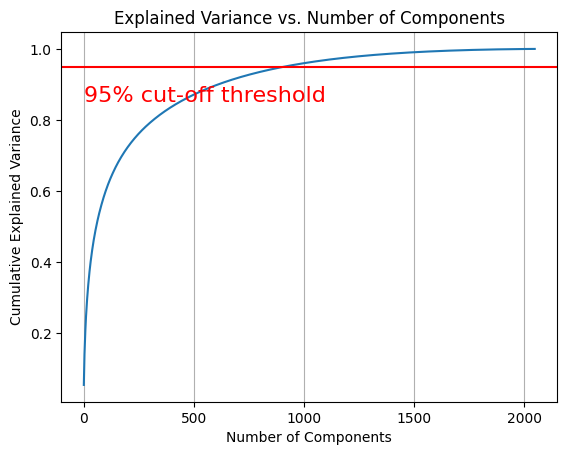

In [7]:
import matplotlib.pyplot as plt
# Plot the explained variance
fig, ax = plt.subplots()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
ax.grid(axis='x')
plt.show()

In [8]:
# Choose the number of components based on your requirements
n_components = 100
pca = PCA(n_components=n_components)
features_resnet50_pca = pca.fit_transform(features_resnet50_std)

In [5]:
from sklearn.metrics import silhouette_score
# Choose a range of cluster numbers to test
def find_Keams_Cluster(features_array):
  cluster_range = range(3, 8)
  distortions = []

  # Find the optimal number of clusters using Silhouette Score
  best_score = -1
  best_n_clusters = -1

  for n_clusters in cluster_range:
      kmeans = KMeans(n_clusters=n_clusters, random_state=42)
      cluster_labels = kmeans.fit_predict(features_array)
      silhouette_avg = silhouette_score(features_array, cluster_labels)
      distortions.append(kmeans.inertia_)
      print(f"For n_clusters={n_clusters}, the silhouette score is {silhouette_avg}")

      if silhouette_avg > best_score:
          best_score = silhouette_avg
          best_n_clusters = n_clusters

  print(f"Best number of clusters: {best_n_clusters} with silhouette score: {best_score}")
  return best_n_clusters,distortions;

In [6]:
# Plot the Elbow curve
# Adjust this visualization based on your specific needs
import matplotlib.pyplot as plt

def PlotElowCurve(distortions, best_n_clusters):
  # Plot the elbow method graph
  plt.plot(range(3, 8), distortions, marker='o')
  plt.xlabel('Number of Clusters')
  plt.ylabel('Inertia')
  plt.title('Elbow Method for Optimal K')
  plt.show()
  print(distortions)
  # Choose the optimal number of clusters based on the Elbow curve
  optimal_k = distortions.index(min(distortions)) + 1
  print(f"Optimal number of clusters: {best_n_clusters}")

In [7]:
from collections import Counter
def Get_ClusterItems(feature_array,best_n_clusters):
  # Apply K-means with the optimal number of clusters
  kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
  kmeans_labels = kmeans.fit_predict(feature_array)

  # Count the number of images in each cluster
  cluster_counts = Counter(kmeans_labels)

  # Print the count of images in each cluster
  for cluster, count in cluster_counts.items():
      print(f"Cluster {cluster + 1}: {count} images")
  return kmeans_labels;

In [8]:
def ShowClusters(feature_array):
  # Visualize the clusters in a scatter plot
  plt.scatter(feature_array[:, 0], feature_array[:, 1], c=cluster_labels, cmap='viridis')
  plt.title('K-Means Clustering with ResNet50 Features')
  plt.xlabel('Principal Component 1')
  plt.ylabel('Principal Component 2')
  plt.show()

In [9]:
# Organize items by cluster label
def cluster_image_mappping(cluster_labels):
  cluster_items = {}
  for idx, cluster_label in enumerate(cluster_labels):
      if cluster_label not in cluster_items:
          cluster_items[cluster_label] = []
      cluster_items[cluster_label].append(image_files[idx])
  return cluster_items;

For n_clusters=3, the silhouette score is 0.050544191151857376
For n_clusters=4, the silhouette score is 0.048201821744441986
For n_clusters=5, the silhouette score is 0.051599759608507156
For n_clusters=6, the silhouette score is 0.04806051775813103
For n_clusters=7, the silhouette score is 0.043848950415849686
Best number of clusters: 5 with silhouette score: 0.051599759608507156


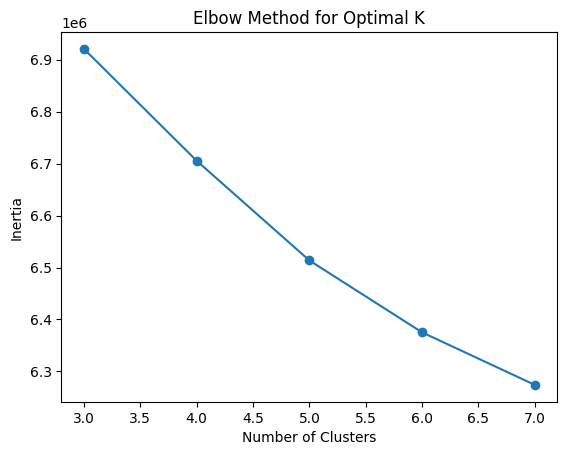

[6920735.0, 6705454.0, 6513540.0, 6375133.0, 6273995.0]
Optimal number of clusters: 5
Cluster 1: 522 images
Cluster 3: 979 images
Cluster 4: 698 images
Cluster 5: 626 images
Cluster 2: 844 images


NameError: ignored

In [16]:
#without standard scaler
best_n_clusters,distortions = find_Keams_Cluster(features_resnet50)
PlotElowCurve(distortions,best_n_clusters)
kmeans_clusters = Get_ClusterItems(features_resnet50,best_n_clusters)
ShowClusters(features_resnet50)


In [67]:
import random

def PlotImages(dic_Clusters_images):
  for cluster_label, items in dic_Clusters_images.items():
      print(f"Cluster {cluster_label}: {len(items)} items")

      # Select a random subset of 10 images
      random_subset = random.sample(items, min(10, len(items)))

      # Display images
      plt.figure(figsize=(15, 1.5))
      for i, img_name in enumerate(random_subset):
          img_path = os.path.join(data_dir, img_name)
          img = image.load_img(img_path, target_size=(100, 100))
          plt.subplot(1, 10, i + 1)
          plt.imshow(img)
          plt.axis('off')
      plt.show()
      print()

Cluster 0: 522 items


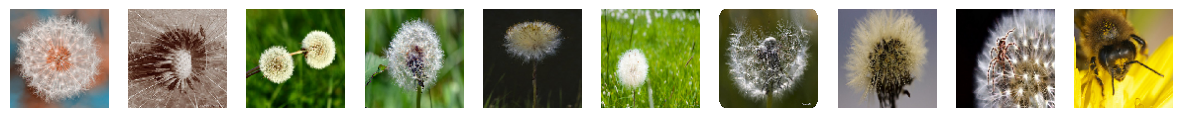


Cluster 2: 979 items


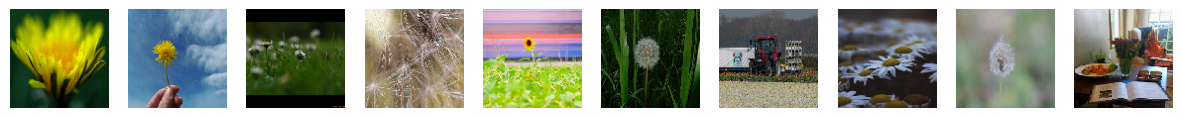


Cluster 3: 698 items


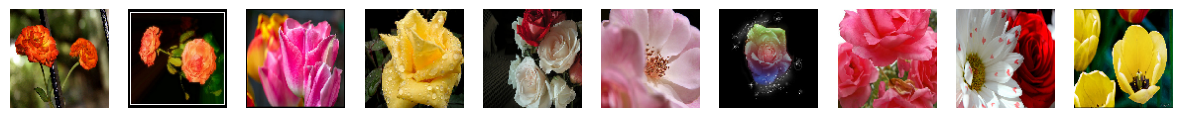


Cluster 4: 626 items


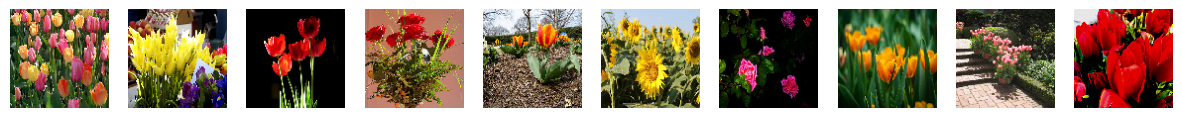


Cluster 1: 844 items


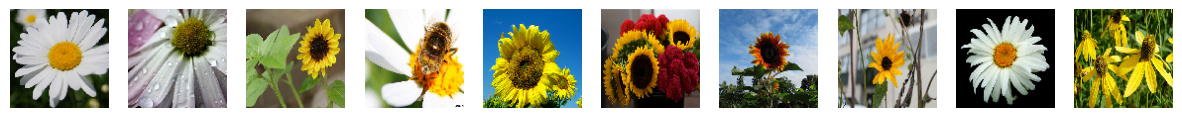

In [68]:
dic_Clusters = cluster_image_mappping(kmeans_clusters)
PlotImages(dic_Clusters)

In [73]:
import shutil
def MoveImagesToOutput(dic_Clusters_images):
  outputPath = "/content/flower_Result"
  os.makedirs(outputPath, exist_ok=True)
  for cluster_label, items in dic_Clusters_images.items():
    output_cluster_dir = os.path.join(outputPath, f'cluster_{cluster_label}')
    os.makedirs(output_cluster_dir, exist_ok=True)
    for img_name in items:
        src_path = os.path.join(data_dir, img_name)
        dst_path = os.path.join(output_cluster_dir, img_name)
        shutil.copy2(src_path, dst_path)

In [74]:
MoveImagesToOutput(dic_Clusters)

with standard scaler

For n_clusters=3, the silhouette score is 0.011529626324772835
For n_clusters=4, the silhouette score is 0.008603020571172237
For n_clusters=5, the silhouette score is 0.0013128559803590178
For n_clusters=6, the silhouette score is -0.0005704457871615887
For n_clusters=7, the silhouette score is -0.004639558959752321
Best number of clusters: 3 with silhouette score: 0.011529626324772835


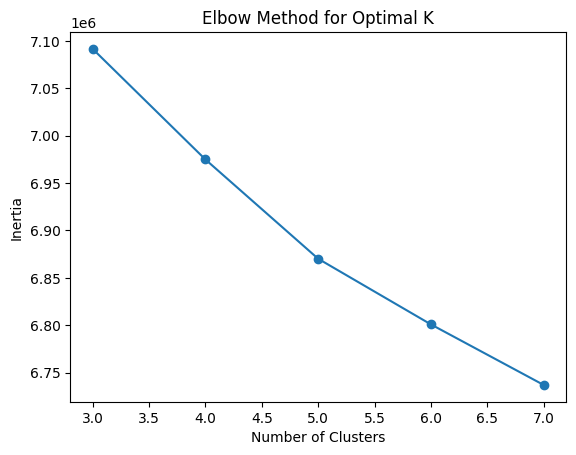

[7091717.0, 6974965.0, 6870143.0, 6800837.0, 6736906.0]
Optimal number of clusters: 3
Cluster 2: 989 images
Cluster 1: 905 images
Cluster 3: 1775 images


In [51]:
# Standardize the features
scaler = StandardScaler()
features_resnet50_std = scaler.fit_transform(features_resnet50)

best_n_clusters_std,distortions_std = find_Keams_Cluster(features_resnet50_std)
PlotElowCurve(distortions_std,best_n_clusters_std)
Get_ClusterItems(features_resnet50_std,best_n_clusters_std)

For n_clusters=3, the silhouette score is 0.4063553214073181
For n_clusters=4, the silhouette score is 0.3853883743286133
For n_clusters=5, the silhouette score is 0.36960986256599426
For n_clusters=6, the silhouette score is 0.3525852560997009
For n_clusters=7, the silhouette score is 0.3523353040218353
Best number of clusters: 3 with silhouette score: 0.4063553214073181


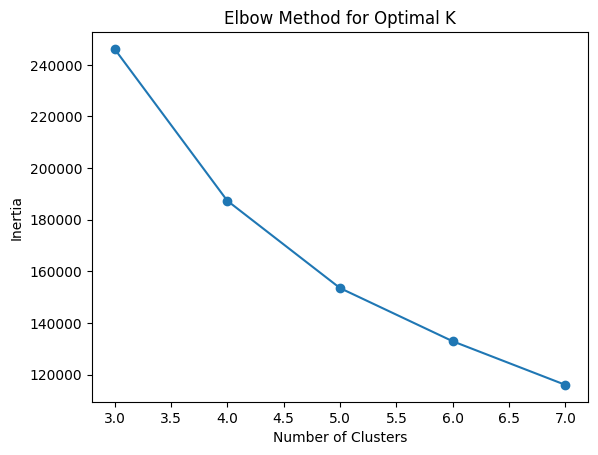

[246190.75, 187349.6875, 153495.5, 132878.46875, 115967.8125]
Optimal number of clusters: 3
Cluster 3: 1064 images
Cluster 1: 883 images
Cluster 2: 1722 images


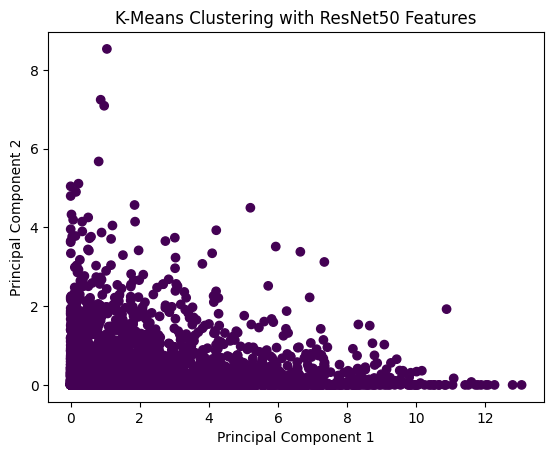

In [57]:
n_components = 2
pca = PCA(n_components=n_components)
features_resnet50_pca = pca.fit_transform(features_resnet50_std)

best_n_clusters_pca,distortions_pca = find_Keams_Cluster(features_resnet50_pca)
PlotElowCurve(distortions_pca,best_n_clusters_pca)
Get_ClusterItems(features_resnet50_pca,best_n_clusters_pca)

In [42]:
from sklearn.cluster import DBSCAN
# Use DBSCAN for clustering
dbscan = DBSCAN()  # Adjust parameters as needed
cluster_labels = dbscan.fit_predict(features_resnet50)

# Visualize the clusters (2D projection for simplicity)
# plt.scatter(features_resnet50[:, 0], features_resnet50[:, 1], c=cluster_labels, cmap='viridis')
# plt.title('DBSCAN Clustering with ResNet50 Features')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.show()

# Display the number of clusters and their sizes
unique_clusters, cluster_sizes = np.unique(cluster_labels, return_counts=True)
for cluster, size in zip(unique_clusters, cluster_sizes):
    print(f"Cluster {cluster}: {size} images")

Cluster -1: 3669 images
